# ДИПЛОМНЫЙ ПРОЕКТ

Тема: "**Анализ отключений в электрических сетях, повлекших обесточивание потребителей (поиск инсайтов, составление рекомендаций стейкхлодерам)**"

Автор: **Калинин Алексей** (DA-55I)

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scikit_posthocs as sp
# !pip install scikit-posthocs

## Часть 1. EDA и подготовка данных

### I. Исходные данные об отключениях в электрических сетях с обесточением потребителй

In [2]:
df = pd.read_excel('01_outages_input.xlsx')     # загрузка данных из исходного файла (формат Excel)
df.head()

,01_id,02_TSO,03_object_type,04_object_name,05_U_nom,06_time_start,07_time_end,08_outage_type,09_duration,10_causing_objects,...,19_points_SN2,20_points_NN,21_other_companies,22_outage_power,23_other_TSO,24_act_data,25_org_code,26_tech_code,27_flag,28_division
0,1,ТСО № 1,ВЛ,Чигири 20,10,"18,32 2017.12.31","18,32 2017.12.31",В,0.000000,ВЛ,...,0,0,0,0.000000,NaN,№ 1 от 09.01.2018,3.4.8.5,4.17,0,ЦЭС
1,2,ТСО № 1,ВЛ,ТП 10-5 ф3,0.4,"05,55 2018.01.03","06,24 2018.01.03",В,0.483333,ВЛ,...,0,1,0,15.000000,NaN,2оп от 03.01.2018,3.4.8.5,4.14,0,ЦЭС
2,3,ТСО № 1,ВЛ,Чалбачи 8,10,"06,50 2018.01.03","07,25 2018.01.03",В,0.583333,ВЛ,...,0,56,0,17.142857,NaN,№ 2 от 10.01.2018,3.4.12.5,4.14,0,СЭС
3,4,ТСО № 1,ВЛ,ПС Базовая ф15-10 ТП-1 ф1,0.4,"09,20 2018.01.03","10,08 2018.01.03",В,0.800000,ВЛ,...,0,40,0,441.000000,NaN,№ 5/2 от 12.01.2018,3.4.8.5,4.4,0,ЗЭС
4,5,ТСО № 1,ВЛ,ТП 10-13 ф3,0.4,"08,13 2018.01.05","11,00 2018.01.05",В,2.783333,ВЛ,...,0,1,0,14.000000,NaN,1/4 от 12.01.2018,3.4.8.5,4.14,0,ЦЭС


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115578 entries, 0 to 115577
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   01_id                115578 non-null  int64  
 1   02_TSO               115578 non-null  object 
 2   03_object_type       115578 non-null  object 
 3   04_object_name       115578 non-null  object 
 4   05_U_nom             115578 non-null  object 
 5   06_time_start        115578 non-null  object 
 6   07_time_end          115578 non-null  object 
 7   08_outage_type       115578 non-null  object 
 8   09_duration          115578 non-null  float64
 9   10_causing_objects   115578 non-null  object 
 10  11_hi_cat_cons_full  107974 non-null  object 
 11  12_hi_cat_cons_part  107301 non-null  object 
 12  13_points_overall    115578 non-null  int64  
 13  14_points_1cat       115578 non-null  int64  
 14  15_points_2cat       115578 non-null  int64  
 15  16_points_3cat   

Краткое описание полей датасета:

- 01_id	- номер прекращения передачи электрической энергии

- 02_TSO - наименование ТСО

- 03_object_type - Вид энергообъекта (КЛ / ВЛ / ПС / ТП / РП / КВЛ)

- 04_object_name - Наименование энергообъекта

- 05_U_nom - Высший класс напряжения отключенного оборудования, кВ

- 06_time_start - Время начала прекращения передачи электроэнергии

- 07_time_end	- Время восстановления передачи электроэнергии

- 08_outage_type - Вид прекращения передачи электроэнергии

- 09_duration	- Продолжительность прекращения передачи электрической энергии

- 10_causing_objects - Перечень объектов, отключение которых привело к обесточиванию

- 11_hi_cat_cons_full -	Перечень потребителей 1-2 категорий надежности, полностью обесточенных

- 12_hi_cat_cons_part	- Перечень потребителей 1-2 категорий надежности, частично обесточенных

- 13_points_overall - Количество точек поставки потребителей, в отношении которых произошел перерыв электроснабжения

- 14_points_1cat - Количество точек поставки обесточенных потребителей 1 категории надежности

- 15_points_2cat - Количество точек поставки обесточенных потребителей 2 категории надежности

- 16_points_3cat - Количество точек поставки обесточенных потребителей 3 категории надежности

- 17_points_VN - Количество точек поставки обесточенных потребителей высокого напряжения (ВН)

- 18_points_SN1 -	Количество точек поставки обесточенных потребителей среднего напряжения 1 (СН1)

- 19_points_SN2	- Количество точек поставки обесточенных потребителей среднего напряжения 2 (СН2)

- 20_points_NN - Количество точек поставки обесточенных потребителей низкого напряжения (НН)

- 21_other_companies - Смежные ТСО и производители электрической энергии

- 22_outage_power - Суммарный объем нагрузки на обесточенных присоединениях потребителей, кВт

- 23_other_TSO - Перечень смежных сетевых организаций, затронутых обесточиванием

- 24_act_data - Номер и дата акта расследования причин аварии

- 25_org_code - Код организационной причины аварии

- 26_tech_code - Код технической причины повреждения оборудования

- 27_flag	- Учет отключения в показателях надежности (0 / 1)

- 28_division	- Подразделение (СП, РЭС) территориальной сетевой организации

*Приведение типов данных к необходимым форматам, исключение дублирующих вариантов заполнения и пропусков:*

In [4]:
df[df.duplicated() == True]     # поиск строк-дубликатов

,01_id,02_TSO,03_object_type,04_object_name,05_U_nom,06_time_start,07_time_end,08_outage_type,09_duration,10_causing_objects,...,19_points_SN2,20_points_NN,21_other_companies,22_outage_power,23_other_TSO,24_act_data,25_org_code,26_tech_code,27_flag,28_division
87710,138,ТСО № 2,ВЛ,ВЛ 110 Артемовская ТЭЦ - Шахта-7,110,"14,44 2021.01.07","14,44 2021.01.07",В,0.0,ВЛ,...,0,0,0,0.0,NaN,33,3.4.7.4,4.13,1,ЮЭС


In [5]:
df.drop_duplicates(keep='first', inplace=True)
len(df)

115577

In [6]:
# атрибут "Тип объекта":
df['03_object_type'].value_counts()

ТП     46839
ВЛ     44319
ПС     20784
КВЛ     2958
КЛ       589
РП        76
вл         6
Вл         3
Пс         2
кл         1
Name: 03_object_type, dtype: int64

In [7]:
# единообразное заполнение графы будет обеспечено при переводе текста в верхний регистр:
df['03_object_type'] = df['03_object_type'].str.upper()
df['03_object_type'].value_counts()

ТП     46839
ВЛ     44328
ПС     20786
КВЛ     2958
КЛ       590
РП        76
Name: 03_object_type, dtype: int64

In [8]:
# атрибут "Номинальное напряжение (кВ)":
df['05_U_nom'].value_counts()

0.38         49334
10 (10.5)    34856
6 (6.3)      14217
35            3701
110           3618
10            3197
0,4           3065
0.4           2189
6             1350
20 (21)         37
220              9
0.22             4
Name: 05_U_nom, dtype: int64

In [9]:
# приведение вариантов написания классов напряжения к единообразию:
df['05_U_nom'].loc[df['05_U_nom'].isin(['0.38', '0,4', '0.22'])] = '0.4'
df['05_U_nom'].loc[df['05_U_nom'].isin(['6', '6 (6.3)', '10', '10 (10.5)', '20 (21)'])] = '6-20'
df['05_U_nom'].value_counts()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.4     54592
6-20    53657
35       3701
110      3618
220         9
Name: 05_U_nom, dtype: int64

In [10]:
# атрибуты "Время начала (окончания) обесточения потребителей"
df[['06_time_start', '07_time_end']].head()

,06_time_start,07_time_end
0,"18,32 2017.12.31","18,32 2017.12.31"
1,"05,55 2018.01.03","06,24 2018.01.03"
2,"06,50 2018.01.03","07,25 2018.01.03"
3,"09,20 2018.01.03","10,08 2018.01.03"
4,"08,13 2018.01.05","11,00 2018.01.05"


In [11]:
# приведение к формату datetime:
df['06_time_start'] = pd.to_datetime(df['06_time_start'], format='%H,%M %Y.%m.%d')
df['07_time_end'] = pd.to_datetime(df['07_time_end'], format='%H,%M %Y.%m.%d')
df[['06_time_start', '07_time_end']].head()

,06_time_start,07_time_end
0,2017-12-31 18:32:00,2017-12-31 18:32:00
1,2018-01-03 05:55:00,2018-01-03 06:24:00
2,2018-01-03 06:50:00,2018-01-03 07:25:00
3,2018-01-03 09:20:00,2018-01-03 10:08:00
4,2018-01-05 08:13:00,2018-01-05 11:00:00


In [12]:
# атрибут "Тип отключения"
df['08_outage_type'].value_counts()

П     73035
В     41561
А       941
В1       40
Name: 08_outage_type, dtype: int64

In [13]:
df['08_outage_type'].loc[df['08_outage_type'] == 'В1'] = 'В'    # приведение типа "В1" к "В" ("внеплановое"):
df['08_outage_type'].value_counts()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


П    73035
В    41601
А      941
Name: 08_outage_type, dtype: int64

In [14]:
# атрибут "длительность отключения" - выражен в часах, заполнен корректно
# для удобства дальнейшего использования преобразование в тип данных timedelta не требуется
df['09_duration'].head()

0    0.000000
1    0.483333
2    0.583333
3    0.800000
4    2.783333
Name: 09_duration, dtype: float64

In [15]:
# проверка корректности заполнения полей 14-16 - сумма столбцов 14-16 должна быть равна столбцу 13
def points_check(row):
    if row['13_points_overall'] == row['14_points_1cat'] + row['15_points_2cat'] + row['16_points_3cat']:
        return True
    return False

df['points_check'] = df.apply(points_check, axis=1)
print(df['points_check'].value_counts())

# проверка корректности заполнения полей 17-20 - сумма столбцов 17-20 должна быть равна столбцу 13
def points_check_voltage(row):
    if row['13_points_overall'] == row['17_points_VN'] + row['18_points_SN1'] + row['19_points_SN2'] + row['20_points_NN']:
        return True
    return False

df['points_check_volt'] = df.apply(points_check_voltage, axis=1)
print(df['points_check_volt'].value_counts())

True     105569
False     10008
Name: points_check, dtype: int64
True     105569
False     10008
Name: points_check_volt, dtype: int64


In [16]:
df.groupby(['02_TSO', 'points_check_volt']).agg({'points_check_volt': 'count',  'points_check': 'count'})

points_check_volt  points_check
02_TSO  points_check_volt                                 
ТСО № 1 False                              2             2
        True                           23733         23733
ТСО № 2 False                           6149          6149
        True                           64084         64084
ТСО № 3 False                           3418          3418
        True                            6425          6425
ТСО № 4 False                            439           439
        True                            5492          5492
ТСО № 5 True                            5835          5835

-------------------------

ВЫВОДЫ:

1) В ~8.5% случаев количество точек поставки занесено некорректно

2) Количество точек поставки некорректно заполненяется в ТСО № 3, 2, 4

-------------------------

In [17]:
# Количество точек поставки 1 и 2 категории, ВН, СН1 и СН2 в подавляющем большинстве случаев достоверно известно
# В связи с этим уточнение количества точек поставки необходимо проводить по 3 категории и НН (низкому напряжению) - столбцы 16 и 20

# уточнение количества точек поставки 3 категории для строк с несовпадающими суммами по столбцам 13, 14-16:
def points_3cat_correction(row):
    if row['points_check'] is False:
        corrected = row['13_points_overall'] - row['15_points_2cat'] - row['14_points_1cat']
        return corrected
    return row['16_points_3cat']

# уточнение количества точек поставки низкого напряжения для строк с несовпадающими суммами по столбцам 13, 17-20
def points_NN_correction(row):
    if row['points_check_volt'] is False:
        corrected = row['13_points_overall'] - row['17_points_VN'] - row['18_points_SN1'] - row['19_points_SN2']
        return corrected
    return row['20_points_NN']

df['16_points_3cat'] = df.apply(points_3cat_correction, axis=1)
df['20_points_NN'] = df.apply(points_NN_correction, axis=1)

# проверка отсутствия отрицательных значений количества точек поставки после преобразований:
df[['01_id', '16_points_3cat', '20_points_NN']][(df['16_points_3cat'] < 0) | (df['20_points_NN'] < 0)]

,01_id,16_points_3cat,20_points_NN


In [18]:
# Можно удалять проверочные столбцы - "points_check_volt" и "points_check":
df.drop(['points_check_volt', 'points_check'], axis=1, inplace=True)

In [19]:
# атрибут "Организационная причина аварии, повлекшей ограничение электроснабжения"
# отключения могут не иметь кода орг. причины (не все отключения расследуются)
# отключения могут иметь несколько кодов орг. причин (тогда основной причиной считается первая из перечисленных)
df['25_org_code'].unique()

array(['3.4.8.5', '3.4.12.5', '3.4.8.3', '3.4.8', nan, '3.4.7.3',
       '3.4.14', '3.4.10', '3.4.9.3', '3.4.9.1', '3.4.7.4', '3.4.13.2',
       '3.4.11', '3.4.8.4', '3.4.8.1', '3.4.8.2', '3.4.9', '3.4.13.1',
       '3.4.12', '3.4.12.2', '3.4.12.1', '3.4.12.3', '3.4.7', '3.4.12.4',
       '3.4.13', '3.4.7.2', '3.4.13.4', '3.4.13.3', '3.4.7.1', '3.4.3',
       '3.4.9.2', '3.4.1', '3.4.12.3, 3.4.12.5',
       '3.4.10, 3.4.12.3, 3.4.12.5', '3.4.12.2, 3.4.12.5',
       '3.4.12.2, 3.4.12.3, 3.4.12.5', '3.4.7.3, 3.4.14',
       '3.4.7.4, 3.4.12.3', '3.4.7.4, 3.4.14', '3.4.7.4, 3.4.8.5',
       '3.4.9.3, 3.4.12.3', '3.4.12.3, 3.4.9.3', '3.4.7.4, 3.4.12.5',
       '3.4.8.5,3.4.12.3', '3.4.7.4, 3.4.13.3', '3.4.9.3, 3.4.13.3',
       '3.4.12.2, 3.4.12.3', '3.4.9.3, 3.4.12.5',
       '3.4.9.3, 3.4.12.2, 3.4.12.3', '3.4.9.3, 3.4.12.2, 3.4.12.5',
       '3.4.9.3, 3.4.12.2', '3.4.8.4, 3.4.9.3', '3.4.4',
       '3.4.13.2, 3.4.12.5', '3.4.7.4, 3.4.9.3', '3.4.7.3, 3.4.13.4',
       '3.4.7.3, 3.4.9.3', 

In [20]:
# выделение основной орг. причины для отключений с несколькими орг. причинами:
def causes(cause):
    if cause:
        if ',' in str(cause):
            cause_main = cause.split(',')[0].strip()
        else:
            cause_main = cause
        return cause_main
    return cause

df['25_org_code'] = df['25_org_code'].apply(causes)
df['25_org_code'].value_counts().sort_values(ascending=False)

3.4.12.2    8513
3.4.7.4     6239
3.4.12.5    5891
3.4.14      4318
3.4.9.3     3479
3.4.12.3    2939
3.4.7.3     2924
3.4.10      2136
3.4.8.5     1606
3.4.9.1      833
3.4.13.3     320
3.4.13.4     317
3.4.8.4      296
3.4.8.2      289
3.4.8.1      281
3.4.8.3      233
3.4.13.2     233
3.4.11       186
3.4.12.1     183
3.4.8        161
3.4.12.4     101
3.4.12        87
3.4.9         78
3.4.13.1      77
3.4.7.1       62
3.4.7.2       27
3.4.9.2       27
3.4.3         16
3.4.13         8
3.4.7          7
3.4.1          4
3.4.4          1
3.4.6          1
Name: 25_org_code, dtype: int64

In [21]:
# атрибут "Техническая причина аварии, повлекшей ограничение электроснабжения"
# особенности заполнения аналогичны столбцу 25
df['26_tech_code'].unique()

array(['4.17', '4.14', '4.4', '4.13', nan, '4.10', '4.16', '4.2', '4.12',
       '4.21', '4.20', '4.3', '4.9', '4.11', '4.7', '4.15', '4.1',
       '4.2, 4.13, 4.16', '4.1, 4.21', '4.8', '4.18', '4.1, 4.10',
       '4.1, 4.10, 4.12, 4.14', '4.11, 4.10', '4.11, 4.13',
       '4.12, 4.13, 4.14', '4.2, 4.4', '4.11, 4.14', '4.1, 4.11',
       '4.3, 4.11', '4.2, 4.17', '4.7, 4.11, 4.14, 4.17', '4.2, 4.18',
       '4.11, 4.17', '4.7, 4.11, 4.12, 4.14, 4.17', '4.4, 4.11', '4.6',
       '4.4, 4.12, 4.17, 4.21', '4.4, 4.17, 4.21', '4.7, 4.11',
       '4.4, 4.21', '4.4, 4.10, 4.12, 4.17, 4.21', '4.10, 4.17, 4.21',
       '4.2, 4.21', '4.4, 4.10', '4.3, 4.16', '4.17, 4.10', '4.17, 4.21',
       '4.4, 4.11, 4.13, 4.21', '4.4, 4.13, 4.21', '4.11, 4.17, 4.21',
       '4.13, 4.14', '4.11, 4.21', '4.21, 4.4, 4.4', '4.21, 4.11, 4.4',
       '4.21, 4.4, 4.13', '4.21, 4.13, 4.11', '4.3, 4.21', '4.11, 4.4',
       '4.11, 4.21, 4.4', '4.4, 4.11, 4.21', '4.12, 4.13', '4.4, 4.13',
       '4.16, 4.21', '4.13,

In [22]:
df['26_tech_code'] = df['26_tech_code'].apply(causes)
df['26_tech_code'].value_counts().sort_values(ascending=False)

4.12    9222
4.4     9082
4.21    7658
4.11    5067
4.13    2594
4.10    2134
4.3     1125
4.17    1072
4.14     753
4.1      374
4.16     288
4.2      231
4.7      204
4.20      97
4.15      73
4.9       46
4.5       34
4.6       28
4.8        5
4.18       4
Name: 26_tech_code, dtype: int64

In [23]:
# атрибут "Подразделение ТСО", заполняется наименование структурного подразделения (СП) либо района эл. сетей (РЭС)
df['28_division'] = df['28_division'].fillna('не определено')
df.groupby(['02_TSO', '28_division']).agg({'01_id': 'count'})

01_id
02_TSO  28_division         
ТСО № 1 ВЭС             5506
        ЗЭС             5088
        СЭС             1759
        ЦЭС             7435
        не определено   3947
ТСО № 2 ЗЭС            18387
        СЭС             9670
        ЦЭС            21976
        ЮЭС            20197
        не определено      3
ТСО № 3 СЭС             1442
        ЦЭС             7336
        не определено   1065
ТСО № 4 БиРЭС             44
        ГорРЭС           274
        ЛенРЭС           231
        ОДИАС           1567
        ОблРЭС           296
        ОктРЭС           133
        СмиРЭС           134
        ТепРЭС           286
        не определено   2966
ТСО № 5 АлРЭС           3350
        НеРЭС             62
        ОДИАС              3
        ТомРЭС          1296
        ТуТРЭС            19
        не определено   1105

-------------------------

ВЫВОДЫ:

1) Только ТСО № 2 корректно заполняет указанную графу в большинстве случаев

2) По прочим ТСО атрибут не позволит проводить углубленный анализ очагов аварийности

-------------------------

In [24]:
df.info()     # просмотр информации о датафрейме по итогам преобразования и очистки данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115577 entries, 0 to 115577
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   01_id                115577 non-null  int64         
 1   02_TSO               115577 non-null  object        
 2   03_object_type       115577 non-null  object        
 3   04_object_name       115577 non-null  object        
 4   05_U_nom             115577 non-null  object        
 5   06_time_start        115577 non-null  datetime64[ns]
 6   07_time_end          115577 non-null  datetime64[ns]
 7   08_outage_type       115577 non-null  object        
 8   09_duration          115577 non-null  float64       
 9   10_causing_objects   115577 non-null  object        
 10  11_hi_cat_cons_full  107973 non-null  object        
 11  12_hi_cat_cons_part  107300 non-null  object        
 12  13_points_overall    115577 non-null  int64         
 13  14_points_1cat

*Проверка наличия недопустимых пропусков в столбце 25 (орг. причина аварий) и корректности заполнения столбца 27 (признак учета отключений при расчсете показателей надежности):*

In [25]:
# столбец 25 (орг. причина аварии) должен быть заполнен для всех записей с параметрами:
   # - тип отключения (столбец 08) - "внеплановое" ("В")
   # - учет отключения (столбец 27) - "учитывается" ("1")
   
df[(df['25_org_code'].isnull()) & (df['27_flag'] == 1) & (df['08_outage_type'] == 'В')][['01_id', '02_TSO', '25_org_code', '27_flag']]

,01_id,02_TSO,25_org_code,27_flag


In [26]:
# столбец 27 (признак учета отключения) должен быть равен "1" для всех отключений типа "П":
df[(df['08_outage_type'] == 'П') & (df['27_flag'] == 0)][['01_id', '02_TSO', '06_time_start', '25_org_code', '27_flag']]

,01_id,02_TSO,06_time_start,25_org_code,27_flag


*Добавление новых атрибутов (столбцов), необходимых для проведения анализа:*

In [27]:
# Добавление атрибута с классификацией причин аварий по 3 основным группам:
   # - природные явления (гроза, гололед, ветер, природные пожары и т.п.)
   # - сторонние воздействия (воздействие сторонних лиц и организаций, воздействие животных и птиц и т.п.)
   # - недостатки эксплуатации (прочие причины - связаны с организацией эксплуатации со стороны ТСО)

reasons_full = list(df['25_org_code'][df['25_org_code'].notnull()].unique())
sorted(reasons_full)

['3.4.1',
 '3.4.10',
 '3.4.11',
 '3.4.12',
 '3.4.12.1',
 '3.4.12.2',
 '3.4.12.3',
 '3.4.12.4',
 '3.4.12.5',
 '3.4.13',
 '3.4.13.1',
 '3.4.13.2',
 '3.4.13.3',
 '3.4.13.4',
 '3.4.14',
 '3.4.3',
 '3.4.4',
 '3.4.6',
 '3.4.7',
 '3.4.7.1',
 '3.4.7.2',
 '3.4.7.3',
 '3.4.7.4',
 '3.4.8',
 '3.4.8.1',
 '3.4.8.2',
 '3.4.8.3',
 '3.4.8.4',
 '3.4.8.5',
 '3.4.9',
 '3.4.9.1',
 '3.4.9.2',
 '3.4.9.3']

In [28]:
# распределение причин по 3 указанным категориям:
reasons_climatic = ['3.4.11', '3.4.12', '3.4.12.1', '3.4.12.2', '3.4.12.3', '3.4.12.4', '3.4.12.5']
reasons_3rdparty = ['3.4.10', '3.4.13', '3.4.13.1', '3.4.13.2', '3.4.13.3', '3.4.13.4', '3.4.8', '3.4.8.1', '3.4.8.2', '3.4.8.3', '3.4.8.4', '3.4.8.5', '3.4.9', '3.4.9.1', '3.4.9.2', '3.4.9.3']
reasons_exploitation = ['3.4.1', '3.4.14', '3.4.3', '3.4.4', '3.4.6', '3.4.7', '3.4.7.1', '3.4.7.2', '3.4.7.3', '3.4.7.4']

In [29]:
# создание атрибута (столбца) с указанием нужной категории
df.loc[df['25_org_code'].isin(reasons_climatic), 'reason_class'] = 'Природные воздействия'
df.loc[df['25_org_code'].isin(reasons_3rdparty), 'reason_class'] = 'Сторонние воздействия'
df.loc[df['25_org_code'].isin(reasons_exploitation), 'reason_class'] = 'Недостатки эксплуатации'
df[['01_id', '02_TSO', '08_outage_type', '25_org_code', '27_flag', 'reason_class']].head()

,01_id,02_TSO,08_outage_type,25_org_code,27_flag,reason_class
0,1,ТСО № 1,В,3.4.8.5,0,Сторонние воздействия
1,2,ТСО № 1,В,3.4.8.5,0,Сторонние воздействия
2,3,ТСО № 1,В,3.4.12.5,0,Природные воздействия
3,4,ТСО № 1,В,3.4.8.5,0,Сторонние воздействия
4,5,ТСО № 1,В,3.4.8.5,0,Сторонние воздействия


In [30]:
# добавление атрибутов (столбцов), отражающих суммарный масштаб обесточения потребителей

# функция для расчета масштаба прекращения электроснабжения (суммарного):
def calc_outage_scale_full(row):
    return row['09_duration'] * row['13_points_overall']

# функция для расчета масштаба прекращения электроснабжения (1 категория):
def calc_outage_scale_1cat(row):
    return row['09_duration'] * row['14_points_1cat']

# функция для расчета масштаба прекращения электроснабжения (2 категория):
def calc_outage_scale_2cat(row):
    return row['09_duration'] * row['15_points_2cat']

# функция для расчета масштаба прекращения электроснабжения (3 категория)
def calc_outage_scale_3cat(row):
    return row['09_duration'] * row['16_points_3cat']  

df['scale_full'] = df.apply(calc_outage_scale_full, axis=1)
df['scale_1cat'] = df.apply(calc_outage_scale_1cat, axis=1)
df['scale_2cat'] = df.apply(calc_outage_scale_2cat, axis=1)
df['scale_3cat'] = df.apply(calc_outage_scale_3cat, axis=1)
df[['01_id', '02_TSO', '08_outage_type', 'scale_full', 'scale_1cat', 'scale_2cat', 'scale_3cat']].head()

,01_id,02_TSO,08_outage_type,scale_full,scale_1cat,scale_2cat,scale_3cat
0,1,ТСО № 1,В,0.000000,0.0,0.0,0.000000
1,2,ТСО № 1,В,0.483333,0.0,0.0,0.483333
2,3,ТСО № 1,В,32.666667,0.0,0.0,32.666667
3,4,ТСО № 1,В,32.000000,0.0,0.0,32.000000
4,5,ТСО № 1,В,2.783333,0.0,0.0,2.783333


In [31]:
# создание отдельных столбцов для года и месяца зафиксированного отключения
df['year'] = pd.DatetimeIndex(df['07_time_end']).year
df['month'] = pd.DatetimeIndex(df['07_time_end']).month
df[['01_id', '02_TSO', '07_time_end', 'year', 'month']].head()

,01_id,02_TSO,07_time_end,year,month
0,1,ТСО № 1,2017-12-31 18:32:00,2017,12
1,2,ТСО № 1,2018-01-03 06:24:00,2018,1
2,3,ТСО № 1,2018-01-03 07:25:00,2018,1
3,4,ТСО № 1,2018-01-03 10:08:00,2018,1
4,5,ТСО № 1,2018-01-05 11:00:00,2018,1


In [32]:
df.groupby(['year', 'month']).count()['01_id']      # оценка периода данных, отраженного в датасете:

year  month
2017  12          6
2018  1        1098
      2         969
      3        1749
      4        1696
      5        2383
      6        2437
      7        3234
      8        2931
      9        2335
      10       2030
      11       1959
      12       1759
2019  1        1261
      2        1490
      3        1977
      4        2453
      5        3165
      6        2762
      7        3388
      8        3096
      9        3247
      10       2637
      11       2376
      12       1937
2020  1        1318
      2        1476
      3        2341
      4        2132
      5        2160
      6        2468
      7        2657
      8        2721
      9        2691
      10       2689
      11       1399
      12       1541
2021  1        1238
      2        1526
      3        1745
      4        2018
      5        1685
      6        1985
      7        2345
      8        2096
      9        1595
      10       1562
      11       1325
      12       1504
2022  1 

------------------------------

ВЫВОДЫ:

1) Данные представлены за 2018-2021 гг. (целиком) и 9 мес. 2022 г.

2) Частично занесены данные за 2017 г. и октябрь 2022 г.

------------------------------

In [33]:
# удаление данных за 2017 г. и октябрь 2022 г. (для обеспечения сопоставимости периодов анализа для различных ТСО):
df = df[ (df['year'].isin([2018, 2019, 2020, 2021])) | ((df['year'] == 2022) & (df['month'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])))]

Разведочный анализ данных в части числовых значений атрибутов:

In [34]:
df.describe()

,01_id,09_duration,13_points_overall,14_points_1cat,15_points_2cat,16_points_3cat,17_points_VN,18_points_SN1,19_points_SN2,20_points_NN,21_other_companies,22_outage_power,27_flag,scale_full,scale_1cat,scale_2cat,scale_3cat,year,month
count,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000,114666.000000
mean,5120.869604,2.948540,144.825755,0.013866,0.156018,144.655870,0.016596,0.036018,2.013038,142.760103,0.381778,304.056836,0.769086,407.690623,0.047689,0.583058,407.059876,2019.736932,6.642431
std,4602.544642,12.158173,346.535352,0.198190,1.053361,346.199409,0.421167,2.515134,13.177478,342.633103,4.630348,1457.156128,0.421419,2361.715829,2.707332,44.342636,2345.317865,1.311134,3.043232
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000
25%,1225.000000,0.783333,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000,10.998000,0.000000,0.000000,10.800000,2019.000000,4.000000
50%,3617.000000,1.783333,36.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,36.000000,0.000000,20.000000,1.000000,57.750000,0.000000,0.000000,57.600000,2020.000000,7.000000
75%,8150.000000,3.700000,127.000000,0.000000,0.000000,127.000000,0.000000,0.000000,1.000000,125.000000,0.000000,180.000000,1.000000,246.410500,0.000000,0.000000,246.000000,2021.000000,9.000000
max,18144.000000,2209.350000,29775.000000,15.000000,69.000000,29727.000000,53.000000,450.000000,1675.000000,29538.000000,476.000000,130000.000000,1.000000,470591.550000,694.383000,11836.341000,461754.150000,2022.000000,12.000000


In [35]:
# атрибут "09_duration" - длительность обесточения (в часах):
  # в соответствии с законодательством, обесточение потребителей более чем на 24 часа подряд недопустимо
  # оценка количество таких отключений:
df[['02_TSO', '03_object_type', '05_U_nom', '06_time_start', '08_outage_type', '09_duration', '25_org_code', '27_flag']]\
.loc[df['09_duration'] > 24]

,02_TSO,03_object_type,05_U_nom,06_time_start,08_outage_type,09_duration,25_org_code,27_flag
2493,ТСО № 1,ВЛ,6-20,2018-07-13 10:00:00,П,25.366667,NaN,1
2852,ТСО № 1,ВЛ,35,2018-07-27 16:00:00,П,46.033333,NaN,1
2906,ТСО № 1,ВЛ,6-20,2018-07-31 03:47:00,П,24.050000,NaN,1
3543,ТСО № 1,ТП,6-20,2018-08-29 02:36:00,П,26.700000,NaN,1
3717,ТСО № 1,ВЛ,0.4,2018-09-08 07:09:00,П,25.183333,NaN,1
...,...,...,...,...,...,...,...,...
84789,ТСО № 3,ТП,0.4,2021-05-04 02:00:00,П,56.000000,NaN,1
84821,ТСО № 3,КВЛ,0.4,2021-05-17 03:00:00,П,51.000000,NaN,1
88875,ТСО № 2,ПС,6-20,2021-02-08 02:45:00,П,150.583333,NaN,1
89042,ТСО № 2,ПС,6-20,2021-02-12 02:01:00,П,106.116667,NaN,1


-------------------------

ВЫВОДЫ:

1) За рассматриваемый период зафикисровано более 300 отключений более чем на 24 часа

2) Выбросы по атрибуту "09_duration" в целом имеют естественный характер (разброс значений огромен - некоторые отключения устранялись неделями, а некоторые - мгновенно)

3) Анализ будет проведен с учетом всех отключений (вне зависимости от длительности), т.к. в таком виде отчетность передается и анализируется органами власти

4) Удаление выбросов исказит результаты (нет достоверной информации об ошибочности данных), в связи с чем производиться на этапе первичного анализа данных не будет. Выбросы будут удалены при статистической проверке гипотез

-------------------------

Атрибуты "Количество точек поставки" (столбцы 13-20):

- разброс значений огромен, что имеет естественный характер (часть объектов питает отдельный дом, часть - целые города и даже регионы)

- удаление выбросов исказит результаты, в связи с чем производиться не будет

Атрибут "Отключенная мощность" (столбец 22):

- разброс значений огромен, что имеет естественный характер (часть объектов питает отдельный дом, часть - целые города и даже регионы)
- удаление выбросов исказит результаты, в связи с чем производиться не будет

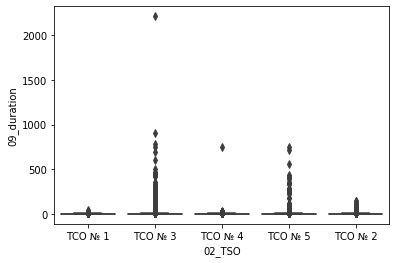

In [36]:
# боксплоты, с учетом вышеуказанного, имеют значительные выбросы:
sns.boxplot( x=df['02_TSO'], y=df['09_duration'] )

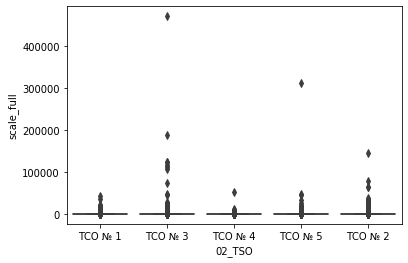

In [37]:
sns.boxplot( x=df['02_TSO'], y=df['scale_full'] )

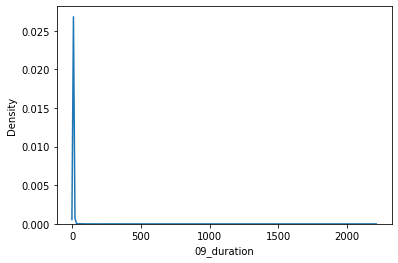

In [38]:
# распределение длительности прекращения электроснабжения (чрезвычайно длинный правый хвост):
sns.kdeplot(df['09_duration'])

In [39]:
# аналогичные визуализации при исключении отключений свыше 24 часов (для оценки изменений):
df_2 = df[df['09_duration'] <= 24]
df_2.describe()

,01_id,09_duration,13_points_overall,14_points_1cat,15_points_2cat,16_points_3cat,17_points_VN,18_points_SN1,19_points_SN2,20_points_NN,21_other_companies,22_outage_power,27_flag,scale_full,scale_1cat,scale_2cat,scale_3cat,year,month
count,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000,114349.000000
mean,5127.960096,2.608615,144.922317,0.013826,0.155576,144.752914,0.014972,0.035680,2.012908,142.858757,0.380904,303.612311,0.769679,383.228098,0.030356,0.350585,382.847157,2019.740549,6.642306
std,4603.543775,2.766253,346.716416,0.198270,1.046478,346.379504,0.331743,2.517887,13.193022,342.809785,4.635839,1458.150057,0.421040,1211.793381,0.785576,3.685760,1210.749929,1.310554,3.045632
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000
25%,1230.000000,0.783333,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,10.933333,0.000000,0.000000,10.766667,2019.000000,4.000000
50%,3627.000000,1.783300,36.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,36.000000,0.000000,20.000000,1.000000,57.510000,0.000000,0.000000,57.400000,2020.000000,7.000000
75%,8157.000000,3.680000,127.000000,0.000000,0.000000,127.000000,0.000000,0.000000,1.000000,125.000000,0.000000,180.000000,1.000000,245.000000,0.000000,0.000000,244.800000,2021.000000,9.000000
max,18144.000000,23.983333,29775.000000,15.000000,69.000000,29727.000000,53.000000,450.000000,1675.000000,29538.000000,476.000000,130000.000000,1.000000,78396.033333,171.000000,501.200000,77853.066667,2022.000000,12.000000


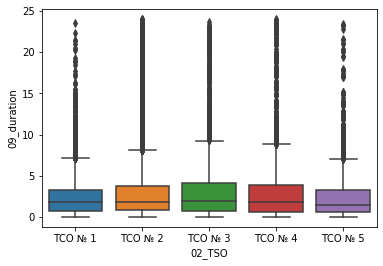

In [40]:
sns.boxplot( x=df_2['02_TSO'].sort_values(), y=df_2['09_duration'] )

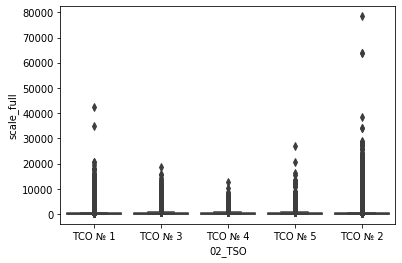

In [41]:
sns.boxplot( x=df_2['02_TSO'], y=df_2['scale_full'] )

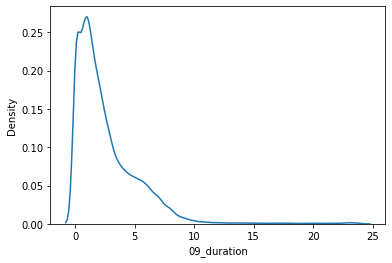

In [42]:
sns.kdeplot(df_2['09_duration'])

------------------------------

Выводы:

1) Даже при исключении записей с отключениями свыше 24 часов, боксплоты в целом имеют нехарактерный вид и не нормальный характер

2) Это связано с естественными выбросами значений атрибутов, что объясняется спецификой отрасли анализа

3) Удаление выбросов исказит результаты, в т.ч. приведет к их несоответствию отчтеным данным, анализируемым органами власти, в связи с чем производиться на этапе первичного анализа данных не будет. Выбросы будут удалены при статистической проверке гипотез.

------------------------------

In [43]:
# Выгрузка предобработанного (очищенного) датафрейма в файл (в качестве резервной копии):
# df.to_excel('01_outages_(output).xlsx', index=False)

### II. Данные о суммарном количестве точек поставки, установленных региональными тарифными органами для ТСО предельных показателях надежности Saidi и Saifi

In [44]:
df_points = pd.read_excel('02_points_input.xlsx')
df_points

,02_TSO,year,max_points,limit_saidi,limit_saifi
0,ТСО № 1,2018,147640,2.5300,4.6700
1,ТСО № 1,2019,152121,2.4900,4.6000
2,ТСО № 1,2020,154179,2.4500,4.5300
3,ТСО № 1,2021,156990,2.4200,4.4600
4,ТСО № 1,2022,159020,2.3800,4.4000
5,ТСО № 2,2018,137517,5.4005,2.9695
6,ТСО № 2,2019,137274,5.2455,2.7349
7,ТСО № 2,2020,135711,5.0950,2.5188
8,ТСО № 2,2021,137751,4.9487,2.3198
9,ТСО № 2,2022,138998,4.8067,2.1366


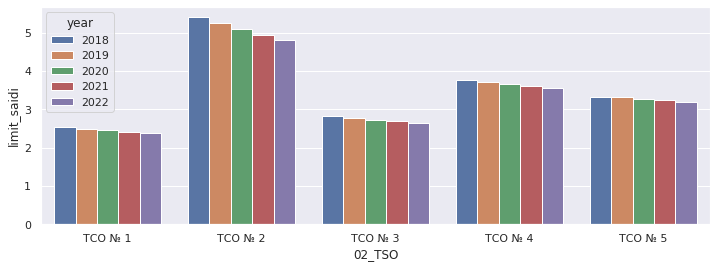

In [45]:
# визуализация предельных показателей надежности SAIDI, установленных для ТСО тарифными органами
sns.set(style="darkgrid")
plt.figure(figsize=(12, 4))
sns.barplot(x="02_TSO", y="limit_saidi", hue='year', data=df_points, ci=None);

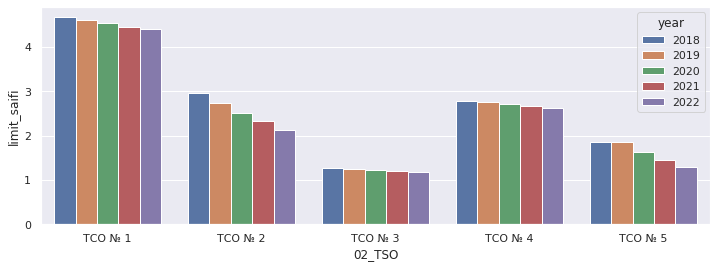

In [46]:
# визуализация предельных показателей надежности SAIFI, установленных для ТСО тарифными органами
sns.set(style="darkgrid")
plt.figure(figsize=(12, 4))
sns.barplot(x="02_TSO", y="limit_saifi", hue='year', data=df_points, ci=None);

-------------------------

1) Таблица заполнена корректно, пропуски и выбросы отсутствуют

2) Целевые (предельные) значения показателей надежности ежегодно улучшаются (снижаются) для всех ТСО

-------------------------

In [47]:
# для последующего сравнения фактических показателей надежности (saidi, saifi) с предельными,
# требуется создание двух дополнительных столбцов:
   # - предельное суммарное количество отключений в год (шт.)
   # - предельный суммарный масштаб (длительность) отключений в год (час.)

df_points['sum_limit_saidi'] = df_points['max_points'] * df_points['limit_saidi']
df_points['sum_limit_saifi'] = df_points['max_points'] * df_points['limit_saifi']
df_points.head()

,02_TSO,year,max_points,limit_saidi,limit_saifi,sum_limit_saidi,sum_limit_saifi
0,ТСО № 1,2018,147640,2.53,4.67,373529.20,689478.80
1,ТСО № 1,2019,152121,2.49,4.60,378781.29,699756.60
2,ТСО № 1,2020,154179,2.45,4.53,377738.55,698430.87
3,ТСО № 1,2021,156990,2.42,4.46,379915.80,700175.40
4,ТСО № 1,2022,159020,2.38,4.40,378467.60,699688.00


In [48]:
# для удобства дальнейшей работы с таблицей на этапе анализа, переведем первые 2 столбца в мультииндекс:
idx = pd.MultiIndex.from_frame(df_points[['02_TSO', 'year']])
df_points = df_points.set_index(idx).drop(['02_TSO', 'year'], axis=1)
df_points.head()

max_points  limit_saidi  limit_saifi  sum_limit_saidi  \
02_TSO  year                                                          
ТСО № 1 2018      147640         2.53         4.67        373529.20   
        2019      152121         2.49         4.60        378781.29   
        2020      154179         2.45         4.53        377738.55   
        2021      156990         2.42         4.46        379915.80   
        2022      159020         2.38         4.40        378467.60   

              sum_limit_saifi  
02_TSO  year                   
ТСО № 1 2018        689478.80  
        2019        699756.60  
        2020        698430.87  
        2021        700175.40  
        2022        699688.00

### III. Справочник классификационных признаков организационных причин аварий

In [49]:
df_org_reasons = pd.read_excel('03_reasons_org_input.xlsx')
df_org_reasons.head()

,org_code,org_reason
0,3.4.1,Ошибочные или неправильные действия оперативно...
1,3.4.2,Ошибочные или неправильные действия (или безде...
2,3.4.3,Ошибочные или неправильные действия привлеченн...
3,3.4.4,Ошибочные или неправильные действия собственно...
4,3.4.5,Ошибочные или неправильные действия (или безде...


-------------------------

Предобработка файла не требуется 

Файл представляет справочник расшифровок значений графы "	25_org_code" основного датасета

-------------------------

### IV. Данные об износе электрических сетей ТСО

In [50]:
df_deter = pd.read_excel('04_deterioration.xlsx')
df_deter.head()

,TSO,year,%over40
0,ТСО № 1,2018,0.29
1,ТСО № 1,2019,0.29
2,ТСО № 1,2020,0.30
3,ТСО № 1,2021,0.30
4,ТСО № 1,2022,0.31


-------------------------

Предобработка файла не требуется 

Файл представляет данные о доле электрических сетей ТСО, находящихся в эксплуатации более 40 лет

-------------------------

## Часть 2. Анализ данных

### I. Оценка показателей надежности (saidi, saifi) ТСО

#### Вариант А - все причины отключений

In [51]:
# создание сводной таблицы с фактическими данными о суммарной длительности обесточения потребителей
saidi_scale_fact = pd.pivot_table(df, values='scale_full', index='02_TSO', columns='year', aggfunc='sum', fill_value=None, dropna=True)
pd.options.display.float_format = '{:20,.3f}'.format     # уход от научной нотации числовых показателей
saidi_scale_fact

year,2018,2019,2020,2021,2022
02_TSO,,,,,
ТСО № 1,"1,605,410.764","1,885,551.168","1,495,504.400","2,157,190.140","2,436,881.967"
ТСО № 2,"4,432,335.231","5,982,010.871","6,840,572.763","4,838,321.332","4,542,637.436"
ТСО № 3,"2,368,058.820","1,478,616.586","1,030,712.977","377,941.822","408,036.380"
ТСО № 4,"389,967.811","383,744.224","355,031.742","314,587.510","357,074.630"
ТСО № 5,"535,461.277","1,109,648.364","591,226.466","373,024.702","458,703.602"


In [52]:
# создание сводной таблицы с фактическими данными о частоте обесточения потребителей
saifi_scale_fact = pd.pivot_table(df, values='13_points_overall', index='02_TSO', columns='year', aggfunc='sum', fill_value=None, dropna=True)
saifi_scale_fact.style.format(thousands=',')

year,2018,2019,2020,2021,2022
02_TSO,,,,,
ТСО № 1,"652,054","938,102","528,427","716,892","846,444"
ТСО № 2,"1,765,618","2,242,545","2,151,927","1,710,863","1,508,261"
ТСО № 3,"314,183","499,736","390,885","197,829","189,554"
ТСО № 4,"187,111","207,947","179,261","168,057","211,537"
ТСО № 5,"163,710","272,237","228,725","182,752","151,933"


In [53]:
# группировка данных по saidi в нужном формате для последующей конкатенации таблиц
saidi_scale_fact_group = df.groupby(['02_TSO', 'year']).sum()['scale_full']
saidi_scale_fact_group.head()

02_TSO   year
ТСО № 1  2018          1,605,410.764
         2019          1,885,551.168
         2020          1,495,504.400
         2021          2,157,190.140
         2022          2,436,881.967
Name: scale_full, dtype: float64

In [54]:
# группировка данных по saifi в нужном формате для последующей конкатенации таблиц
saifi_scale_fact_group = df.groupby(['02_TSO', 'year']).sum()['13_points_overall']
saifi_scale_fact_group.head()

02_TSO   year
ТСО № 1  2018    652054
         2019    938102
         2020    528427
         2021    716892
         2022    846444
Name: 13_points_overall, dtype: int64

In [55]:
# конкатенация трех подготовленных ранее датафреймов - создание таблицы для оценки показателей надежности
saidi_saifi_stacked = pd.concat([saidi_scale_fact_group, saifi_scale_fact_group, df_points], axis = 1)
saidi_saifi_stacked

scale_full  13_points_overall  max_points  \
02_TSO  year                                                       
ТСО № 1 2018        1,605,410.764             652054      147640   
        2019        1,885,551.168             938102      152121   
        2020        1,495,504.400             528427      154179   
        2021        2,157,190.140             716892      156990   
        2022        2,436,881.967             846444      159020   
ТСО № 2 2018        4,432,335.231            1765618      137517   
        2019        5,982,010.871            2242545      137274   
        2020        6,840,572.763            2151927      135711   
        2021        4,838,321.332            1710863      137751   
        2022        4,542,637.436            1508261      138998   
ТСО № 3 2018        2,368,058.820             314183       54312   
        2019        1,478,616.586             499736       57226   
        2020        1,030,712.977             390885       58128   
        2021          377,941.822             197829       59595   
        2022          408,036.380             189554       60335   
ТСО № 4 2018          389,967.811             187111       40107   
        2019          383,744.224             207947       41121   
        2020          355,031.742             179261       41715   
        2021          314,587.510             168057       42185   
        2022          357,074.630             211537       42746   
ТСО № 5 2018          535,461.277             163710       15035   
        2019        1,109,648.364             272237       15168   
        2020          591,226.466             228725       15232   
        2021          373,024.702             182752       15253   
        2022          458,703.602             151933       15434   

                      limit_saidi          limit_saifi      sum_limit_saidi  \
02_TSO  year                                                                  
ТСО № 1 2018                2.530                4.670          373,529.200   
        2019                2.490                4.600          378,781.290   
        2020                2.450                4.530          377,738.550   
        2021                2.420                4.460          379,915.800   
        2022                2.380                4.400          378,467.600   
ТСО № 2 2018                5.401                2.970          742,660.559   
        2019                5.245                2.735          720,070.767   
        2020                5.095                2.519          691,447.545   
        2021                4.949                2.320          681,688.374   
        2022                4.807                2.137          668,121.687   
ТСО № 3 2018                2.815                1.262          152,904.574   
        2019                2.773                1.244          158,693.421   
        2020                2.732                1.225          158,776.632   
        2021                2.691                1.207          160,340.348   
        2022                2.650                1.188          159,899.817   
ТСО № 4 2018                3.771                2.788          151,255.529   
        2019                3.715                2.748          152,756.291   
        2020                3.659                2.707          152,635.185   
        2021                3.604                2.666          152,043.177   
        2022                3.550                2.626          151,752.575   
ТСО № 5 2018                3.330                1.845           50,068.053   
        2019                3.330                1.845           50,510.957   
        2020                3.280                1.635           49,962.483   
        2021                3.231                1.448           49,280.918   
        2022                3.182                1.284           49,117.162   

                  sum_limit_saifi  
02_TSO  year    

In [56]:
# добавление расчетных столбцов с фактическими показателями надежности saidi и saifi
saidi_saifi_stacked['saidi_fact'] = saidi_saifi_stacked['scale_full'] / saidi_saifi_stacked['max_points']
saidi_saifi_stacked['saifi_fact'] = saidi_saifi_stacked['13_points_overall'] / saidi_saifi_stacked['max_points']
saidi_saifi_stacked = saidi_saifi_stacked.reset_index()
saidi_saifi_stacked

,02_TSO,year,scale_full,13_points_overall,max_points,limit_saidi,limit_saifi,sum_limit_saidi,sum_limit_saifi,saidi_fact,saifi_fact
0,ТСО № 1,2018,"1,605,410.764",652054,147640,2.530,4.670,"373,529.200","689,478.800",10.874,4.417
1,ТСО № 1,2019,"1,885,551.168",938102,152121,2.490,4.600,"378,781.290","699,756.600",12.395,6.167
2,ТСО № 1,2020,"1,495,504.400",528427,154179,2.450,4.530,"377,738.550","698,430.870",9.700,3.427
3,ТСО № 1,2021,"2,157,190.140",716892,156990,2.420,4.460,"379,915.800","700,175.400",13.741,4.566
4,ТСО № 1,2022,"2,436,881.967",846444,159020,2.380,4.400,"378,467.600","699,688.000",15.324,5.323
5,ТСО № 2,2018,"4,432,335.231",1765618,137517,5.401,2.970,"742,660.559","408,356.731",32.231,12.839
6,ТСО № 2,2019,"5,982,010.871",2242545,137274,5.245,2.735,"720,070.767","375,430.663",43.577,16.336
7,ТСО № 2,2020,"6,840,572.763",2151927,135711,5.095,2.519,"691,447.545","341,828.867",50.405,15.857
8,ТСО № 2,2021,"4,838,321.332",1710863,137751,4.949,2.320,"681,688.374","319,554.770",35.124,12.420
9,ТСО № 2,2022,"4,542,637.436",1508261,138998,4.807,2.137,"668,121.687","296,983.127",32.681,10.851


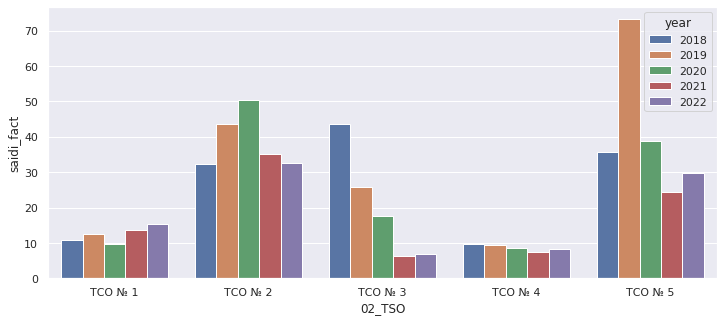

In [57]:
# визуализация фактических показателей надежности saidi в разрезе ТСО
sns.set(style="darkgrid")
plt.figure(figsize=(12, 5))
sns.barplot(x="02_TSO", y='saidi_fact', hue='year', data=saidi_saifi_stacked, ci=None);

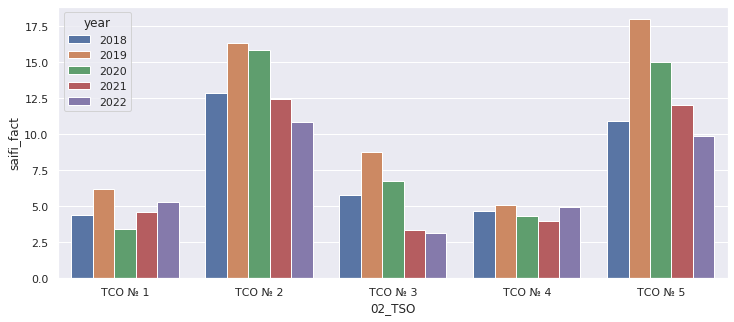

In [58]:
# визуализация фактических показателей надежности saifi в разрезе ТСО
sns.set(style="darkgrid")
plt.figure(figsize=(12, 5))
sns.barplot(x="02_TSO", y='saifi_fact', hue='year', data=saidi_saifi_stacked, ci=None);

-------------------------

Выводы:

1) наиболее проблемными ТСО в части абсолютных значений показателей надежности (отключения по всем причинам) являются ТСО № 2 и ТСО № 5

2) отсутствует устойчивая динамика улучшения показателей надежности (отключения по всем причинам) в ТСО № 1, ТСО № 4 и ТСО № 5

3) по ТСО № 1 и ТСО № 4 по итогам 9 месяцев 2022 г. уже превышены уровни 2020-2021 гг., по ТСО № 2, ТСО № 3 и ТСО № 5 - эти уровни почти достигнуты

-------------------------

In [59]:
TSO_list = sorted(list(df['02_TSO'].unique()))    # составление списка с перечнем ПО
TSO_list

['ТСО № 1', 'ТСО № 2', 'ТСО № 3', 'ТСО № 4', 'ТСО № 5']

In [60]:
# Оценка подразделений ТСО № 2, по которым зафиксирована наибольшая продолжительность обесточений:
pd.pivot_table(df[df['02_TSO'] == TSO_list[1]], values='scale_full', index='28_division', columns='year', aggfunc='sum', fill_value=0, margins=True, margins_name='ИТОГО')

year,2018,2019,2020,2021,2022,ИТОГО
28_division,,,,,,
ЗЭС,"786,928.180","1,441,523.790","1,388,879.142","1,134,193.283","870,876.033","5,622,400.429"
СЭС,"924,962.633","972,110.339","1,081,845.495","897,005.749","741,606.407","4,617,530.623"
ЦЭС,"879,575.379","1,312,450.860","1,676,680.152","922,878.089","602,574.174","5,394,158.654"
ЮЭС,"1,823,510.215","2,255,925.882","2,693,167.973","1,884,240.144","2,326,214.022","10,983,058.236"
не определено,"17,358.825",0.000,0.000,4.067,"1,366.800","18,729.692"
ИТОГО,"4,432,335.231","5,982,010.871","6,840,572.763","4,838,321.332","4,542,637.436","26,635,877.633"


-------------------------

ВЫВОДЫ:

1) Львиная доля (в различные годы от ~35% до ~60%) суммарных обесточений потребителей приходится на структурное подразделение "ЮЭС"

2) Однако, не имея информации о количестве точек поставки в разрезе СП, сделать гарантированно корректные выводы из приведенных данных невозможно (возможно, данное СП имеет еще большую долю точек поставки)

-------------------------

#### Вариант Б - только внеплановые отключения (тип "В"), учитываемые при оценке показателей надежности (признак учёта "1") - по принципу, применяемому тарифными органами

In [61]:
# аналогичные варианту "А" преобразования для датафрейма с необходимыми фильтрами:
df_proper = df[ (df['08_outage_type'] == 'В') & (df['27_flag'] == 1) ]
saidi_scale_fact_proper = pd.pivot_table(df_proper, values='scale_full', index='02_TSO', columns='year', aggfunc='sum', fill_value=None, dropna=True)
saidi_scale_fact_proper

year,2018,2019,2020,2021,2022
02_TSO,,,,,
ТСО № 1,"52,548.309","222,271.966","186,312.883","175,634.357","92,990.967"
ТСО № 2,"386,664.692","522,241.812","574,979.450","483,419.877","304,443.586"
ТСО № 3,"57,010.014","26,903.929","70,845.643","36,031.663","26,547.037"
ТСО № 4,"43,218.924","43,357.074","54,287.180","53,525.730","33,647.370"
ТСО № 5,"32,680.410","3,846.152","3,499.274","2,035.702",399.236


In [62]:
saifi_scale_fact_proper = pd.pivot_table(df_proper, values='13_points_overall', index='02_TSO', columns='year', aggfunc='sum', fill_value=None, dropna=True)
saifi_scale_fact_proper.style.format(thousands=',')

year,2018,2019,2020,2021,2022
02_TSO,,,,,
ТСО № 1,"60,786","215,060","126,875","121,758","132,261"
ТСО № 2,"310,145","375,314","370,945","304,274","236,122"
ТСО № 3,"44,320","13,403","37,065","25,858","29,337"
ТСО № 4,"34,167","47,963","59,368","39,420","58,309"
ТСО № 5,"11,182","6,218","1,972","5,329",378


In [63]:
saidi_scale_fact_proper_group = df_proper.groupby(['02_TSO', 'year']).sum()['scale_full']
saifi_scale_fact_proper_group = df_proper.groupby(['02_TSO', 'year']).sum()['13_points_overall']
saidi_saifi_proper_stacked = pd.concat([saidi_scale_fact_proper_group, saifi_scale_fact_proper_group, df_points], axis = 1)
saidi_saifi_proper_stacked.head()

scale_full  13_points_overall  max_points  \
02_TSO  year                                                       
ТСО № 1 2018           52,548.309              60786      147640   
        2019          222,271.966             215060      152121   
        2020          186,312.883             126875      154179   
        2021          175,634.357             121758      156990   
        2022           92,990.967             132261      159020   

                      limit_saidi          limit_saifi      sum_limit_saidi  \
02_TSO  year                                                                  
ТСО № 1 2018                2.530                4.670          373,529.200   
        2019                2.490                4.600          378,781.290   
        2020                2.450                4.530          377,738.550   
        2021                2.420                4.460          379,915.800   
        2022                2.380                4.400          378,467.600   

                  sum_limit_saifi  
02_TSO  year                       
ТСО № 1 2018          689,478.800  
        2019          699,756.600  
        2020          698,430.870  
        2021          700,175.400  
        2022          699,688.000

In [64]:
saidi_saifi_proper_stacked['saidi_fact'] = saidi_saifi_proper_stacked['scale_full'] / saidi_saifi_proper_stacked['max_points']
saidi_saifi_proper_stacked['saifi_fact'] = saidi_saifi_proper_stacked['13_points_overall'] / saidi_saifi_proper_stacked['max_points']
saidi_saifi_proper_stacked = saidi_saifi_proper_stacked.reset_index()
saidi_saifi_proper_stacked

,02_TSO,year,scale_full,13_points_overall,max_points,limit_saidi,limit_saifi,sum_limit_saidi,sum_limit_saifi,saidi_fact,saifi_fact
0,ТСО № 1,2018,"52,548.309",60786,147640,2.530,4.670,"373,529.200","689,478.800",0.356,0.412
1,ТСО № 1,2019,"222,271.966",215060,152121,2.490,4.600,"378,781.290","699,756.600",1.461,1.414
2,ТСО № 1,2020,"186,312.883",126875,154179,2.450,4.530,"377,738.550","698,430.870",1.208,0.823
3,ТСО № 1,2021,"175,634.357",121758,156990,2.420,4.460,"379,915.800","700,175.400",1.119,0.776
4,ТСО № 1,2022,"92,990.967",132261,159020,2.380,4.400,"378,467.600","699,688.000",0.585,0.832
5,ТСО № 2,2018,"386,664.692",310145,137517,5.401,2.970,"742,660.559","408,356.731",2.812,2.255
6,ТСО № 2,2019,"522,241.812",375314,137274,5.245,2.735,"720,070.767","375,430.663",3.804,2.734
7,ТСО № 2,2020,"574,979.450",370945,135711,5.095,2.519,"691,447.545","341,828.867",4.237,2.733
8,ТСО № 2,2021,"483,419.877",304274,137751,4.949,2.320,"681,688.374","319,554.770",3.509,2.209
9,ТСО № 2,2022,"304,443.586",236122,138998,4.807,2.137,"668,121.687","296,983.127",2.190,1.699


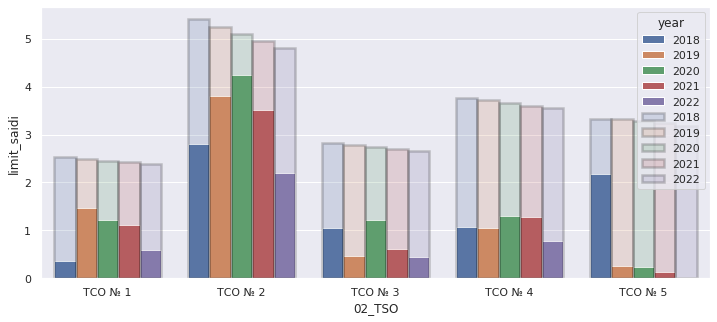

In [65]:
# визуализация фактических (сплошная заливка) и предельных (прозрачная заливка) показателей надежности saidi
sns.set(style="darkgrid")
plt.figure(figsize=(12, 5))
sns.barplot(x="02_TSO", y='saidi_fact', hue='year', data=saidi_saifi_proper_stacked);
sns.barplot(x="02_TSO", y='limit_saidi', hue='year', linewidth=2.5, edgecolor='black', data=saidi_saifi_proper_stacked, alpha=0.2);

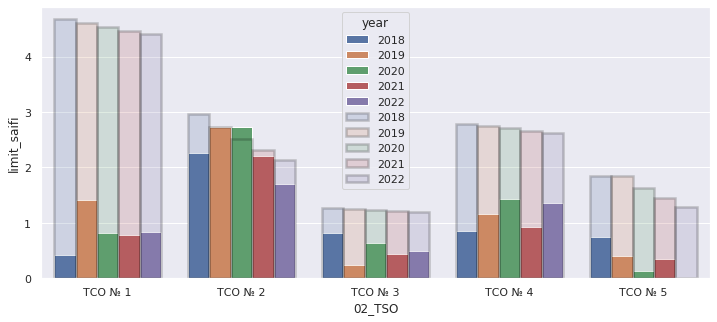

In [66]:
# визуализация фактических (сплошная заливка) и предельных (прозрачная заливка) показателей надежности saifi
sns.set(style="darkgrid")
plt.figure(figsize=(12, 5))

sns.barplot(x="02_TSO", y='saifi_fact', hue='year', data=saidi_saifi_proper_stacked);
sns.barplot(x="02_TSO", y='limit_saifi', hue='year', linewidth=2.5, edgecolor='black', data=saidi_saifi_proper_stacked, alpha=0.2);

In [67]:
# расчет соотношения фактических и предельных (установленных тарифными органами) показателей надежности
saidi_saifi_proper_stacked['% saidi'] = saidi_saifi_proper_stacked['saidi_fact'] / saidi_saifi_proper_stacked['limit_saidi'] * 100
saidi_saifi_proper_stacked['% saifi'] = saidi_saifi_proper_stacked['saifi_fact'] / saidi_saifi_proper_stacked['limit_saifi'] * 100
saidi_saifi_percent = saidi_saifi_proper_stacked.drop(columns=['scale_full', '13_points_overall', 'max_points', 'sum_limit_saidi', 'sum_limit_saifi'], axis=1)
saidi_saifi_percent

,02_TSO,year,limit_saidi,limit_saifi,saidi_fact,saifi_fact,% saidi,% saifi
0,ТСО № 1,2018,2.530,4.670,0.356,0.412,14.068,8.816
1,ТСО № 1,2019,2.490,4.600,1.461,1.414,58.681,30.734
2,ТСО № 1,2020,2.450,4.530,1.208,0.823,49.323,18.166
3,ТСО № 1,2021,2.420,4.460,1.119,0.776,46.230,17.390
4,ТСО № 1,2022,2.380,4.400,0.585,0.832,24.570,18.903
5,ТСО № 2,2018,5.401,2.970,2.812,2.255,52.065,75.950
6,ТСО № 2,2019,5.245,2.735,3.804,2.734,72.526,99.969
7,ТСО № 2,2020,5.095,2.519,4.237,2.733,83.156,108.518
8,ТСО № 2,2021,4.949,2.320,3.509,2.209,70.915,95.218
9,ТСО № 2,2022,4.807,2.137,2.190,1.699,45.567,79.507


In [68]:
# фильтр по показателям надежности, составившим более 85% от предельных значений, в 2018-2021 гг.:
saidi_saifi_percent[ ( (saidi_saifi_percent['% saidi'] > 85) | (saidi_saifi_percent['% saifi'] > 85) ) \
                   & (saidi_saifi_percent['year'].isin([2018, 2019, 2020, 2021]) )]

,02_TSO,year,limit_saidi,limit_saifi,saidi_fact,saifi_fact,% saidi,% saifi
6,ТСО № 2,2019,5.245,2.735,3.804,2.734,72.526,99.969
7,ТСО № 2,2020,5.095,2.519,4.237,2.733,83.156,108.518
8,ТСО № 2,2021,4.949,2.320,3.509,2.209,70.915,95.218


In [69]:
# фильтр по показателям надежности по итогам 9 мес. 2022 г., составляющим более 65% от предельных значений:
saidi_saifi_percent[ ( (saidi_saifi_percent['% saidi'] > 65) | (saidi_saifi_percent['% saifi'] > 65) ) \
                   & ( saidi_saifi_percent['year'] == 2022)]

,02_TSO,year,limit_saidi,limit_saifi,saidi_fact,saifi_fact,% saidi,% saifi
9,ТСО № 2,2022,4.807,2.137,2.190,1.699,45.567,79.507


-------------------------

ВЫВОДЫ:

1) Единственный зафиксированный случай превышения предельных показателей надежности отмечен в ТСО № 2 (2020 г. - показател saifi)

2) Еще в 2 случаях имелся риск превышения предельных показателей надежности (более 90% от предельного) - также в ТСО № 2 (2019 и 2021 г. - saifi)

3) В 2022 г. риски превышения предельных значений показателей надежности отмечаются также по ТСО № 2 (за 9 мес. выбрано 79.5% предельного показателя - saifi)

-------------------------

#### Выявление объектов электросетевого хозяйства, имеющих наибольшее влияние на показатели надежности

#####   - по всем отключениям с обесточением потребителей (вариант А):

In [70]:
# Распределение масштабов прекращения электроснабжения по видам объектов, по которым зафиксировано отключение:
pd.pivot_table(df, values='scale_full', index='02_TSO', columns='03_object_type', aggfunc='sum', dropna=True, fill_value=0, margins=True)

03_object_type,ВЛ,КВЛ,КЛ,ПС,РП,ТП,All
02_TSO,,,,,,,
ТСО № 1,"7,880,184.571",0.000,"29,343.533","1,047,972.667","9,002.700","614,034.967","9,580,538.438"
ТСО № 2,"10,004,792.675","1,188,526.250","21,290.633","10,714,929.816","2,076.250","4,704,262.009","26,635,877.633"
ТСО № 3,"3,805,286.739","906,996.748","97,651.751","664,473.405","3,057.301","185,900.642","5,663,366.586"
ТСО № 4,"956,069.800","553,777.100","15,819.198","144,241.702",3.990,"130,494.128","1,800,405.917"
ТСО № 5,"2,093,965.461","15,908.737",48.000,"820,960.757",0.000,"137,181.456","3,068,064.411"
All,"24,740,299.246","2,665,208.834","164,153.115","13,392,578.346","14,140.241","5,771,873.202","46,748,252.986"


-------------------------

ВЫВОД: более половины масштабов перерывов электроснабжения связаны с отключениями ВЛ (воздушные ЛЭП)

-------------------------

In [71]:
# Распределение масштабов прекращения электроснабжения из-за отключений ВЛ по классам напряжения:
pd.pivot_table(df[df['03_object_type'] == 'ВЛ'], values='scale_full', index='02_TSO', columns='05_U_nom', aggfunc='sum', dropna=True, fill_value=0, margins=True)

05_U_nom,0.4,110,220,35,6-20,All
02_TSO,,,,,,
ТСО № 1,"762,675.459","405,933.403",0.000,"902,774.407","5,808,801.303","7,880,184.571"
ТСО № 2,"109,404.845","1,691,962.346","6,592.987","988,784.315","7,208,048.183","10,004,792.675"
ТСО № 3,"304,230.512","128,985.479",0.000,"78,503.277","3,293,567.471","3,805,286.739"
ТСО № 4,"159,751.631","12,941.810",0.000,"45,953.730","737,422.629","956,069.800"
ТСО № 5,"225,544.643","38,732.380",0.000,"629,395.794","1,200,292.643","2,093,965.461"
All,"1,561,607.089","2,278,555.418","6,592.987","2,645,411.523","18,248,132.229","24,740,299.246"


-------------------------

ВЫВОД: 2/3 объемов прекращения электроснабжения при отключениях ВЛ связана с ВЛ напряжением 6-20 кВ

-------------------------

In [72]:
# Определение 5 объектов по каждому ТСО, вносящих наибольший вклад в показатели надежности за 2018-2022 гг.:

for i in range(5):
    print(f'5 объектов {TSO_list[i]}, вносящих наибольший вклад в показатель saidi:')
    mask = df['02_TSO'] == TSO_list[i]
    top = df[mask].groupby(['04_object_name', '05_U_nom']).sum()['scale_full'].sort_values(ascending=False)
    print(top.head())
    print('-------------------------------')
    print()

5 объектов ТСО № 1, вносящих наибольший вклад в показатель saidi:
04_object_name                   05_U_nom
ВЛ 110 кВ Сиваки - Октябрьская   110                 186,805.817
ПС 35 кВ Южная\Ф-4               6-20                146,565.233
ПС 35 кВ Прогресс\Ф-7            6-20                139,823.600
ПС 35 кВ Пера\ф6-10 кВ ПС Пера   6-20                128,553.683
ВЛ-35 кВ А-Ст.Райчиха            35                   77,987.367
Name: scale_full, dtype: float64
-------------------------------

5 объектов ТСО № 2, вносящих наибольший вклад в показатель saidi:
04_object_name  05_U_nom
ПС Лесозаводск  6-20                384,398.867
ПС Партизан     6-20                330,603.633
ПС Анучино      6-20                233,423.355
ПС Кировка      6-20                226,921.083
ПС Милоградово  6-20                222,497.200
Name: scale_full, dtype: float64
-------------------------------

5 объектов ТСО № 3, вносящих наибольший вклад в показатель saidi:
04_object_name         05_U_nom
ПС 110

------------------------------------------------

**РЕКОМЕНДАЦИЯ (в целях снижения масштабов перерывов электроснабжения):**

при формировании планов технического обслуживания и ремонта, технического перевооружения и реконструкции в приоритетном порядке предусматривать технические воздействия на указанных выше объектах

------------------------------------------------

#####   - только по отключениям, учитываемым в показателях надежности (вариант Б):

In [73]:
# Распределение масштабов прекращения электроснабжения по видам объектов, по которым зафиксировано отключение:
pd.pivot_table(df_proper, values='scale_full', index='02_TSO', columns='03_object_type', aggfunc='sum', dropna=True, fill_value=0, margins=True)

03_object_type,ВЛ,КВЛ,КЛ,ПС,РП,ТП,All
02_TSO,,,,,,,
ТСО № 1,"686,002.282",0.000,"6,181.367","27,117.750",774.900,"9,682.183","729,758.482"
ТСО № 2,"151,298.886",347.717,0.000,"1,711,913.374",0.000,"408,189.440","2,271,749.417"
ТСО № 3,"143,402.724","50,798.160",727.520,"18,626.082",225.420,"3,558.380","217,338.286"
ТСО № 4,"93,292.602","88,338.520","9,128.690","29,818.949",0.000,"7,457.517","228,036.278"
ТСО № 5,"10,073.934",0.000,0.000,"30,122.410",0.000,"2,264.430","42,460.774"
All,"1,084,070.428","139,484.397","16,037.577","1,817,598.565","1,000.320","431,151.950","3,489,343.237"


-------------------------

ВЫВОД: более половины масштабов перерывов электроснабжения связаны с отключениями на подстанциях (ПС) 35 кВ и выше

-------------------------

In [74]:
# Распределение масштабов прекращения электроснабжения из-за отключений на ПС по классам напряжения оборудования:
pd.pivot_table(df_proper[df_proper['03_object_type'] == 'ПС'], values='scale_full', index='02_TSO', columns='05_U_nom', aggfunc='sum', dropna=True, fill_value=0, margins=True)

05_U_nom,0.4,110,220,35,6-20,All
02_TSO,,,,,,
ТСО № 1,418.533,"10,626.433",0.000,"5,690.483","10,382.300","27,117.750"
ТСО № 2,0.000,"28,897.141","1,135.250","60,478.835","1,621,402.149","1,711,913.374"
ТСО № 3,0.000,"13,276.282",0.000,748.659,"4,601.140","18,626.082"
ТСО № 4,79.680,332.580,0.000,"3,656.040","25,750.649","29,818.949"
ТСО № 5,0.000,920.601,0.000,"2,563.650","26,638.159","30,122.410"
All,498.213,"54,053.038","1,135.250","73,137.667","1,688,774.397","1,817,598.565"


-------------------------

ВЫВОД: более 90% объемов прекращения электроснабжения при отключениях на ПС связана с повреждением оборудования 6-20 кВ

-------------------------

In [75]:
# Определение 5 объектов по каждому ТСО, вносящих наибольший вклад в показатели надежности:

for i in range(5):
    print(f'5 объектов {TSO_list[i]}, вносящих наибольший вклад в показатель saidi:')
    mask = df_proper['02_TSO'] == TSO_list[i]
    top = df_proper[mask].groupby(['04_object_name', '05_U_nom']).sum()['scale_full'].sort_values(ascending=False)
    print(top.head())
    print('-------------------------------')
    print()

5 объектов ТСО № 1, вносящих наибольший вклад в показатель saidi:
04_object_name                  05_U_nom
ПС 220 кВ Магдагачи\Ф-6 \3\Ф-2  0.4                  17,456.500
Прогресс 4                      6-20                 16,908.733
Костюковка - Сычевка            35                   16,016.550
Ромны 1                         6-20                 15,440.567
ПС 35 кВ Сычевка\Ф-4\15-16\ф-1  0.4                  15,181.000
Name: scale_full, dtype: float64
-------------------------------

5 объектов ТСО № 2, вносящих наибольший вклад в показатель saidi:
04_object_name                                               05_U_nom
Ф-11 РП 80201 яч17 (80201-82017),  ПС 110/35/10 Промысловка  6-20                 80,465.800
Ф-6,  ПС 35/6 Соловей ключ                                   6-20                 48,862.985
Ф-16,  ПС 110/6 Береговая-1                                  6-20                 34,198.042
Ф-12,  ПС 35/6 Сергеевка                                     6-20                 30,697.221

------------------------------------------------

**РЕКОМЕНДАЦИЯ (в целях снижения рисков превышения предельных показателей, устанавливаемых тарифными органами):**

при формировании планов технического обслуживания и ремонта, технического перевооружения и реконструкции в приоритетном порядке предусматривать технические воздействия на указанных выше объектах

------------------------------------------------

#### Анализ влияния причин аварий на показатели надежности

Распределение причин отключений по ТСО "ТСО № 1":


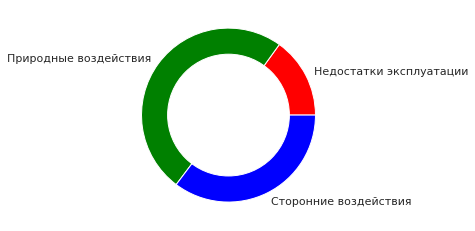


Распределение причин отключений по ТСО "ТСО № 2":


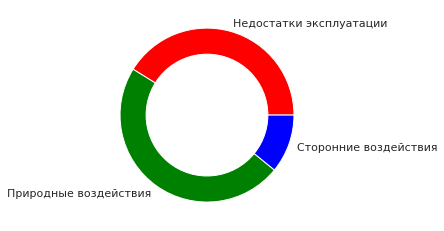


Распределение причин отключений по ТСО "ТСО № 3":


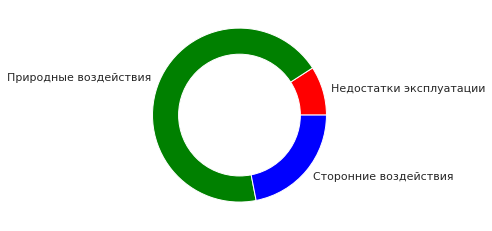


Распределение причин отключений по ТСО "ТСО № 4":


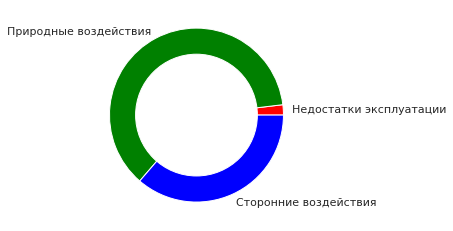


Распределение причин отключений по ТСО "ТСО № 5":


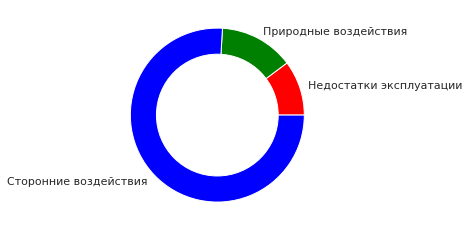

In [76]:
# Рекомендации по расследованию аварий были уточнены в 2020 году, в связи с чем для анализа берется период 2021-2022 гг.:
df_reasons = df[df['year'].isin([2021, 2022])]

# Визуализация распределения причин аварий, повлекших обесточение потребителей, в каждом из ТСО:

for TSO in TSO_list:
    donut_data = df_reasons[df_reasons['02_TSO'] == TSO].groupby('reason_class').sum()['scale_full'].reset_index()
    names = donut_data['reason_class']
    size = donut_data['scale_full']
    print(f'Распределение причин отключений по ТСО "{TSO}":')
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(size, labels=names, colors=['red','green','blue'])
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    print()

In [77]:
# группировка масштаба обесточения потребителей в разрезе ТСО и групп причин аварий:
reasons_table = df_reasons.groupby(['02_TSO', 'reason_class']).sum()['scale_full'].reset_index()
reasons_table

,02_TSO,reason_class,scale_full
0,ТСО № 1,Недостатки эксплуатации,"57,938.223"
1,ТСО № 1,Природные воздействия,"191,011.517"
2,ТСО № 1,Сторонние воздействия,"135,627.400"
3,ТСО № 2,Недостатки эксплуатации,"789,084.196"
4,ТСО № 2,Природные воздействия,"919,265.258"
5,ТСО № 2,Сторонние воздействия,"208,560.036"
6,ТСО № 3,Недостатки эксплуатации,"26,032.827"
7,ТСО № 3,Природные воздействия,"196,837.100"
8,ТСО № 3,Сторонние воздействия,"62,604.640"
9,ТСО № 4,Недостатки эксплуатации,"4,138.000"


In [78]:
# расчет вклада каждой группы причин аварий (в разрезе ТСО) через оконную функцию:

def share(df):
    total_scale = df['scale_full'].sum()
    df['share_%'] = df['scale_full'] / total_scale * 100

    return df

reasons_table.groupby('02_TSO').apply(share).sort_values('02_TSO')

,02_TSO,reason_class,scale_full,share_%
0,ТСО № 1,Недостатки эксплуатации,"57,938.223",15.065
1,ТСО № 1,Природные воздействия,"191,011.517",49.668
2,ТСО № 1,Сторонние воздействия,"135,627.400",35.267
3,ТСО № 2,Недостатки эксплуатации,"789,084.196",41.164
4,ТСО № 2,Природные воздействия,"919,265.258",47.956
5,ТСО № 2,Сторонние воздействия,"208,560.036",10.880
6,ТСО № 3,Недостатки эксплуатации,"26,032.827",9.119
7,ТСО № 3,Природные воздействия,"196,837.100",68.951
8,ТСО № 3,Сторонние воздействия,"62,604.640",21.930
9,ТСО № 4,Недостатки эксплуатации,"4,138.000",1.908


-------------------------

**ВЫВОДЫ:**

1) по ТСО № 4, 3 и 5 - **аномально низкая** доля аварий из-за недостатков эксплуатации

2) по ТСО № 2 - **аномально высокая** доля аварий из-за недостатков эксплуатации

3) по ТСО № 3, 4 - **аномально высокая** доля из-за природных воздействий

4) по ТСО № 5 - **аномально высокая** доля из-за сторонних воздействий

5) по ТСО № 1 - распределение причин аварий равномерно и в целом не вызывает вопросов

-------------------------

In [79]:
# Детализация причин аварийности по ТСО № 2 - 5 (с учетом вышеприведенных выводов):

TSO_nums = [1, 2, 3, 4]

for TSO_num in TSO_nums:
    df_cut = df_reasons[df_reasons['02_TSO'] == TSO_list[TSO_num]]
    reasons_table = df_cut.groupby('25_org_code').sum()['scale_full'].reset_index()
    scale_sum = reasons_table.sum()['scale_full']
    print(scale_sum)
    reasons_table['share_%'] = reasons_table['scale_full'] * 100 / scale_sum
    # объединение с таблицей расшифровки организационных причин аварий:
    reasons_codes = reasons_table.merge(df_org_reasons, how='left', left_on='25_org_code', right_on='org_code')
    
    print(f'Распределение причин аварий по {TSO_list[TSO_num]}:')
    print(reasons_codes[['25_org_code', 'org_reason', 'share_%']].sort_values('share_%', ascending=False))
    print()

1916909.4899222972
Распределение причин аварий по ТСО № 2:
   25_org_code                                         org_reason  \
3     3.4.12.2                                  Ветровые нагрузки   
12     3.4.7.3    Несвоевременное выявление и устранение дефектов   
13     3.4.7.4                           Прочие нарушения (износ)   
6     3.4.12.5  Прочие воздействия неблагоприятных природных я...   
1       3.4.11  Превышение параметров воздействия стихийных яв...   
21     3.4.9.3  Отключение (повреждение) оборудования потребит...   
4     3.4.12.3                 Атмосферные перенапряжения (гроза)   
10      3.4.14                              Не выявленные причины   
18     3.4.8.5                                 Прочие воздействия   
0       3.4.10                        Воздействие животных и птиц   
5     3.4.12.4                                   Природные пожары   
14     3.4.8.1  Производство несанкционированных строительных ...   
15     3.4.8.2                    Проезд кру

---------

**Выводы по ТСО № 2:**

1) Отмечается высокая доля аварий из-за **ветровых нагрузок** (25%) и **прочих воздействий неблагоприятных природных явлений** (10%), что коррелирует с приморским расположением ТСО (регулярно фиксируются тайфуны и тропические штормы).

2) 21% общей продолжительности аварий с обесточением потребителей вызвано **несвоевременным выявлением и устранением дефектов**, в связи с чем требуется оценка качества организации технического обслуживания и ремонтов электрических сетей, достаточности выделяемых на указанные цели средств и ресурсов.

3) 17% общей продолжительности аварий с обесточением потребителей связано с **физическим износом оборудования**, что соответствует имеющейся информации о значительной доле оборудования ТСО, выработавшего нормативный срок службы.

---------

**Выводы по ТСО № 3:**

1) Отмечается высокая доля аварий из-за **ветровых нагрузок** (27%), **прочих воздействий неблагоприятных природных явлений** (17%) и **превышения параметров воздействия стихийных явлений относительно условий проекта** (11%), что коррелирует с приморским расположением ТСО (периодически фиксируются тайфуны и тропические штормы).

2) Более 10% общей продолжительности аварий с обесточением потребителей связывается с **повреждениями оборудования потребителей электрической энергии**, обоснованность классификации аварий по указанной причине требует проведения отдельного анализа актов расследования аварий.

---------

**Выводы по ТСО № 4:**

1) Отмечается высокая доля аварий из-за **превышения параметров воздействия стихийных явлений относительно условий проекта** (33%) и **ветровых нагрузок** (19%), обоснованность классификации аварий по указанной причине требует проведения отдельного анализа актов расследования аварий в связи с гораздо более мягкими климатическими условиями в зоне работы ТСО № 4 в сравнении с ТСО № 2 и ТСО № 3.

2) 13% общей продолжительности аварий с обесточением потребителей связывается с **недостатками конструкции оборудования**, что вызывает сомнения в связи с низким влиянием указанной причины на аварийность в других ТСО, расположенных в соседних регионах и эксплуатирующих оборудование тех же производителей. Требуется отдельный анализ обоснованности классификации аварий по указанной причине.

---------

**Выводы по ТСО № 5:**

1) Отмечается аномально высокая доля аварий из-за **повреждений оборудования потребителей электрической энергии** (42%), что с высокой долей вероятности является следствием некорректной классификации причин аварий либо умышленного сокрытия истинных причин аварийности. Требуется аудит процесса организации расследования аварий в данном ТСО.

2) Более 9% общей продолжительности аварий с обесточением потребителей вызвано **проездом крупногабаритной техники**, еще 14% - **прочими воздействиями сторонних лиц и организаций**, что свидетельствует либо о сокрытии истинных причин аварий, либо о недостаточной работе с подрядными организациями и строительными организациями региона, осуществляющими несогласованные действия в охранных зонах ВЛ, приводящие к аварийным отключениям. Рекомендуется также усилить работу по обустройству путей проезда под линиями электропередачи с установкой соответствующих указателей, обеспечением соблюдения необходимых габаритных расстояний от проводов ВЛ до земли и реализацией иных аналогичных мероприятий.

### II. Анализ прочих характеристик отключений с обесточением потребителей

#### Обесточение потребителей в разрезе категорий надежности

-------------------------

В действующем законодательстве определены 3 категории надежности потребителей электроэнергии:
  - 1 категория (особо важные потребители, должны питаться от двух независимых источников питания, обесточение не допускается)
  - 2 категория (важные потребители, должны питаться от двух независимых источников питания, допускаются перерывы электроснабжения до 2 часов)
  - 3 категория (остальные потребители, допускаются перерывы электроснабжения на 72 ч в год (суммарно) и на 24 ч единовременно)

-------------------------

In [80]:
# распределение масштаба перерывов электроснабжения по категориям:
cat_distr = df.groupby(['02_TSO']).sum()[['scale_1cat', 'scale_2cat', 'scale_3cat', 'scale_full']]
cat_distr

,scale_1cat,scale_2cat,scale_3cat,scale_full
02_TSO,,,,
ТСО № 1,738.883,"8,242.183","9,571,557.372","9,580,538.438"
ТСО № 2,"1,780.562","25,389.393","26,608,707.678","26,635,877.633"
ТСО № 3,"2,874.480","15,255.758","5,645,236.348","5,663,366.586"
ТСО № 4,72.033,"1,876.376","1,798,457.509","1,800,405.917"
ТСО № 5,2.317,"16,093.203","3,051,968.891","3,068,064.411"


In [81]:
# расчет долей масштабов обесточения по каждой категории:
cat_distr['1cat_%'] = cat_distr['scale_1cat'] * 100 / cat_distr['scale_full']
cat_distr['2cat_%'] = cat_distr['scale_2cat'] * 100 / cat_distr['scale_full']
cat_distr['3cat_%'] = cat_distr['scale_3cat'] * 100 / cat_distr['scale_full']
cat_distr[['1cat_%', '2cat_%', '3cat_%']]

,1cat_%,2cat_%,3cat_%
02_TSO,,,
ТСО № 1,0.008,0.086,99.906
ТСО № 2,0.007,0.095,99.898
ТСО № 3,0.051,0.269,99.680
ТСО № 4,0.004,0.104,99.892
ТСО № 5,0.000,0.525,99.475


-------------------------

**ВЫВОДЫ:**

1) Масштабы обесточения 1-2 категорий потребителей от общих объемов обесточения в ТСО составляют от 0.1% до 1.4%.

2) Недопустимо высокие показатели - в ТСО № 3 и ТСО № 5 (более 0.5% объемов обесточений - потребители 1-2 категорий).

-------------------------

In [82]:
# анализ распределения обесточения потребителей 1 категории по видам отключений:
types_1cat = pd.pivot_table( df[df['14_points_1cat'] > 0], values='scale_1cat', index='02_TSO', columns='08_outage_type', aggfunc='sum', margins=True, fill_value=0)
types_1cat

08_outage_type,А,В,П,All
02_TSO,,,,
ТСО № 1,0.000,89.700,649.183,738.883
ТСО № 2,35.482,714.850,"1,030.230","1,780.562"
ТСО № 3,9.336,625.342,"2,239.802","2,874.480"
ТСО № 4,1.920,36.830,33.283,72.033
ТСО № 5,0.000,2.317,0.000,2.317
All,46.738,"1,469.039","3,952.499","5,468.276"


<ipython-input-83-9c939b2513fd>:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(types_1cat.loc[['All'], ['А', 'В', 'П']], labels=['А (аварийные)', 'В (внеплановые)', 'П (плановые)'], colors=['red', 'orange', 'green'])


([<matplotlib.patches.Wedge at 0x7f99f34ccee0>,
 [Text(1.099603469597744, 0.029533195705909208, 'А (аварийные)'),
  Text(0.6857643542008974, 0.8600739796711828, 'В (внеплановые)'),
  Text(-0.7086086501220038, -0.8413523524494787, 'П (плановые)')])

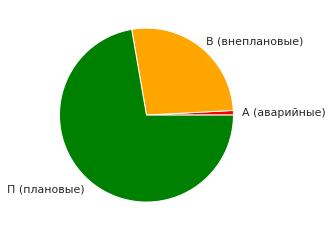

In [83]:
# круговая диаграмма распределения отключений с обесточениям по типам:
cmap = plt.cm.prism
plt.pie(types_1cat.loc[['All'], ['А', 'В', 'П']], labels=['А (аварийные)', 'В (внеплановые)', 'П (плановые)'], colors=['red', 'orange', 'green'])

-------------------------

**ВЫВОДЫ:**

1) Основную часть случаев обесточения потребителей 1 категории составляют плановые отключения.

2) Однако отключения потребителей 1 категории планироваться не могут, т.к. это **протворечит требованиям нормативных документов** !

3) Рекомендуется:
- принять меры по повышению надежности функционирования энергообъектов, питающих потребителей 1 категории
- провести работу с собственниками электроустановок 1 категории в части повторного их оповещения о необходимости организации электроснабжения от двух независимых источников питания (в т.ч. о необходимости приобретения и обеспечения работоспособности собственных дизель-генераторных установок потребителей).

-------------------------

In [84]:
# анализ распределения обесточения потребителей 2 категории по продолжительности отключений:
df_2cat = df[df['15_points_2cat'] > 0]
len(df_2cat)

7219

In [85]:
# функция возвращает "1", если есть нарушение по времени обесточения потребителя 2 категории (не более 2 часов):
def over2h(dur):
    if dur > 2:
        return 1
    return 0

df_2cat['over2h'] = df_2cat['09_duration'].apply(over2h)
df_2cat['over2h'].value_counts()

<ipython-input-85-abdce90040e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2cat['over2h'] = df_2cat['09_duration'].apply(over2h)


0    4179
1    3040
Name: over2h, dtype: int64

In [86]:
# оценка количества случаев нарушения 2-часового норматива в разрезе ТСО:
df_2cat.groupby('02_TSO').agg({'scale_2cat': 'count', 'over2h': 'sum'})       # выведено общее количество отключений 2 категории и случаи нарушений

,scale_2cat,over2h
02_TSO,,
ТСО № 1,1287,606
ТСО № 2,4310,1868
ТСО № 3,719,261
ТСО № 4,629,176
ТСО № 5,274,129


In [87]:
# подготовка данных для построения диаграммы
diag_2cat_data = df_2cat.groupby('02_TSO').agg({'scale_2cat': 'count', 'over2h': 'sum'}).reset_index()
diag_2cat_data['less2h'] = diag_2cat_data['scale_2cat'] - diag_2cat_data['over2h']
diag_2cat_data = diag_2cat_data[['02_TSO', 'over2h', 'less2h']]
diag_2cat_data

,02_TSO,over2h,less2h
0,ТСО № 1,606,681
1,ТСО № 2,1868,2442
2,ТСО № 3,261,458
3,ТСО № 4,176,453
4,ТСО № 5,129,145


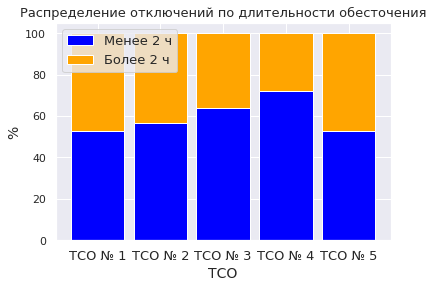

In [88]:
# диаграмма распределения отключений потребителей 2 категории по длительности (порог - 2 часа):
r = [0,1,2,3,4]
raw_data = {'Менее 2 ч.': diag_2cat_data['less2h'], 'Более 2 ч.': diag_2cat_data['over2h']}
df_diag = pd.DataFrame(raw_data)

totals = [i+j for i,j in zip(df_diag['Менее 2 ч.'], df_diag['Более 2 ч.'])]
less2h = [i / j * 100 for i,j in zip(df_diag['Менее 2 ч.'], totals)]
over2h = [i / j * 100 for i,j in zip(df_diag['Более 2 ч.'], totals)]

barWidth = 0.85
names = (diag_2cat_data['02_TSO'])
plt.bar(r, less2h, color='blue', edgecolor='white', width=barWidth)
plt.bar(r, over2h, bottom=less2h, color='orange', edgecolor='white', width=barWidth)

plt.title('Распределение отключений по длительности обесточения', fontsize=13)
plt.xticks(r, names, fontsize=13)
plt.xlabel("ТСО", fontsize=14)
plt.ylabel('%', fontsize=14)
plt.legend(['Менее 2 ч', 'Более 2 ч'], loc=2, fontsize=13)
plt.show()

-------------------------

**ВЫВОДЫ:**

1) Более 40% от общего количества случаев обесточения потребителей 2 категории длятся более 2 часов, что **противоречит требованиям нормативных документов** !

2) Такие нарушения на систематической основе отмечаются во всех ТСО (при этом в ТСО № 4 - в наименьшей степени).

3) Рекомендуется:
- принять меры по повышению надежности функционирования энергообъектов, питающих потребителей 2 категории, в том числе готовность к порведению аварийно-восстановительных работ либо запитке от независимого источника в течение 2 часов
- провести работу с собственниками электроустановок 2 категории в части повторного их оповещения о необходимости организации электроснабжения от двух независимых источников питания (в т.ч. о необходимости приобретения и обеспечения работоспособности собственных дизель-генераторных установок потребителей).

-------------------------

In [89]:
# анализ распределения обесточения потребителей 3 категории по продолжительности отключений:
types_3cat = pd.pivot_table( df[df['16_points_3cat'] > 0], values='scale_3cat', index='02_TSO', columns='08_outage_type', aggfunc='sum', margins=True )
types_3cat

08_outage_type,А,В,П,All
02_TSO,,,,
ТСО № 1,"1,281.517","1,292,793.062","8,277,482.793","9,571,557.372"
ТСО № 2,"77,191.900","7,665,389.876","18,866,125.902","26,608,707.678"
ТСО № 3,"17,825.745","1,697,131.503","3,930,279.100","5,645,236.348"
ТСО № 4,"4,221.600","614,795.272","1,179,440.637","1,798,457.509"
ТСО № 5,"8,721.153","120,591.486","2,922,656.252","3,051,968.891"
All,"109,241.915","11,390,701.198","35,175,984.684","46,675,927.797"


In [90]:
df_3cat = df[df['16_points_3cat'] > 0]    # оценка количества обесточиваний
len(df_3cat)

106502

In [91]:
# функция возвращает "1", если есть нарушение по времени обесточения потребителя 3 категории (не более 24 часов):
def over24h(dur):
    if dur > 24:
        return 1
    return 0

df_3cat['over24h'] = df_3cat['09_duration'].apply(over24h)
df_3cat['over24h'].value_counts()

<ipython-input-91-2972f8640a8d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3cat['over24h'] = df_3cat['09_duration'].apply(over24h)


0    106241
1       261
Name: over24h, dtype: int64

In [92]:
# проверка наличия ПЛАНОВЫХ отключений длиннее 24 часов:
df_3cat[df_3cat['08_outage_type'] == 'П']['over24h'].value_counts()

0    70902
1      118
Name: over24h, dtype: int64

In [93]:
# оценка количества случаев нарушения 24-часового норматива в разрезе ТСО:
df_3cat = df_3cat.groupby('02_TSO').agg({'scale_3cat': 'count', 'over24h': 'sum'})    # общее количество отключений 3 кат. и случаи нарушений
df_3cat['%'] = df_3cat['over24h'] * 100 / df_3cat['scale_3cat']
df_3cat

,scale_3cat,over24h,%
02_TSO,,,
ТСО № 1,21859,11,0.050
ТСО № 2,64652,67,0.104
ТСО № 3,8989,143,1.591
ТСО № 4,5458,2,0.037
ТСО № 5,5544,38,0.685


-------------------------

**ВЫВОДЫ:**

1) Порядка 3/4 случаев обесточения потребителей 3 категории составляют плановые отключения.

2) Зафиксированы сотни отключений, при которых продолжительность обесточения потребителей составляла более 24 часов подряд, что **протворечит требованиям нормативных документов** !

3) Такие нарушения на систематической основе отмечаются в ТСО № 3 и ТСО № 5.

4) Большая часть (118 из 199) таких отключений - плановые отключения. Однако отключения с обесточением потребителей более чем на 24 часа подряд планироваться не могут, т.к. это **протворечит требованиям нормативных документов** !

5) ТСО № 3 и ТСО № 5 рекомендуется:
- обеспечить электроснабжения потребителей 3 категории в соответствии с требованиями нормативных документов, в том числе обеспечить готовность сил и средств к проведению аварийно-восстановительных работт.
- принять меры по повышению качества планирования и подготовки к проведению плановых отключений в целях обеспечения соблюдения предельной продолжительности обесточения потребителей (не более 24 часов единовременно).

-------------------------

#### Обесточение потребителей по месяцам

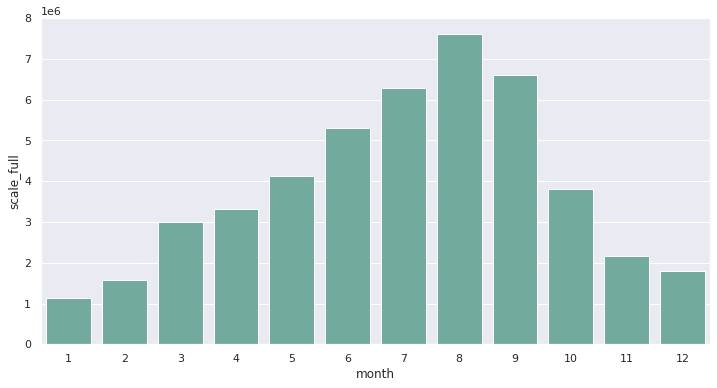

In [94]:
# суммарные масштабы обесточения потребителей по месяцам за 2018-2022 гг.:
# по 2022 г. данные имеются только за 9 месяцев!

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.barplot(
    x="month", 
    y="scale_full", 
    data=df, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2')

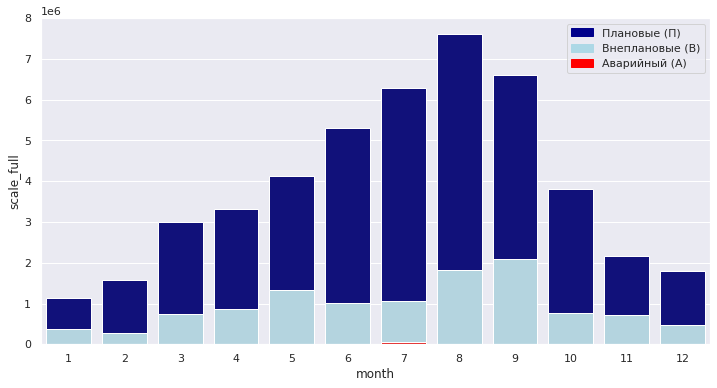

In [95]:
# то же с детализацией по типам отключений:

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

total = df.groupby('month')['scale_full'].sum().reset_index()
bar1 = sns.barplot(x="month",  y="scale_full", data=total, color='darkblue')

failures_and_unplanned = df[df['08_outage_type'].isin(['А', 'В'])]
bar2 = sns.barplot(x="month", y="scale_full", data=failures_and_unplanned, estimator=sum, ci=None,  color='lightblue')

failures = df[df['08_outage_type'] == 'А']
bar3 = sns.barplot(x="month", y="scale_full", data=failures, estimator=sum, ci=None,  color='red')

top_bar = mpatches.Patch(color='darkblue', label='Плановые (П)')
middle_bar = mpatches.Patch(color='lightblue', label='Внеплановые (В)')
bottom_bar = mpatches.Patch(color='red', label='Аварийный (А)')
plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.show()

-------------------------

**ВЫВОДЫ:**

1) Распределение масштабов обесточения потребителей по месяцам года имеет вид, близкий к нормальному распределению, с ярко выраженным пиком в июле-сентябре

2) Такой характер распределения связан с тем, что в плановые отключения (для проведения ремонтов и иных плановых работ) производятся, в основном, вне пределов отопительного сезона (как периода с наибольшей загрузкой электрических сетей)

3) Рост масштабов обесточения потребителей из-за внеплановых отключений в летние месяцы также связан с большим количеством плановых ремонтов в этот период, что вызывает ослабление схемы и снижение уровня резервирования объектов на случай их внеплановых / аварийных отключений.

4) Аварийные отключения ("А", отключения из-за аварий в сетях иных субъектов энергетики) имеют пренебрежительно малый вклад в общие масштабы обесточения потребителей.

-------------------------

In [96]:
# сводная таблица мастабов обесточения по типам отключений в каждом из месяцев:
pd.pivot_table(df, values='scale_full', index=('02_TSO', '08_outage_type'), columns='month', aggfunc='sum', fill_value=0, margins=True, margins_name='ИТОГО')

month                                     1                    2  \
02_TSO  08_outage_type                                             
ТСО № 1 А                             0.000                0.000   
        В                        24,221.130           14,435.883   
        П                        73,005.683          133,002.850   
ТСО № 2 А                           232.500              287.537   
        В                       293,282.149          219,039.630   
        П                       523,434.686          889,334.923   
ТСО № 3 А                           394.997                0.000   
        В                        28,483.641           26,150.011   
        П                        97,511.318          165,215.544   
ТСО № 4 А                             0.000                0.000   
        В                        12,280.704           11,503.110   
        П                        26,898.045           43,779.518   
ТСО № 5 А                             0.000                0.000   
        В                        15,264.374              772.491   
        П                        32,788.389           62,976.973   
ИТОГО                         1,127,797.616        1,566,498.471   

month                                     3                    4  \
02_TSO  08_outage_type                                             
ТСО № 1 А                             0.000                0.000   
        В                        68,712.000           81,215.351   
        П                       527,940.233          666,511.817   
ТСО № 2 А                             0.000              258.800   
        В                       581,111.073          619,282.502   
        П                     1,211,825.299        1,445,019.604   
ТСО № 3 А                         2,639.058                0.000   
        В                        55,892.774          111,509.262   
        П                       268,354.836          155,460.431   
ТСО № 4 А                             0.000                0.000   
        В                        27,177.173           42,961.999   
        П                        65,241.712           80,117.027   
ТСО № 5 А                             0.000                0.000   
        В                         6,025.450           15,352.821   
        П                       192,614.699          100,028.602   
ИТОГО                         3,007,534.308        3,317,718.216   

month                                     5                    6  \
02_TSO  08_outage_type                                             
ТСО № 1 А                             0.000                0.000   
        В                       186,290.229          199,031.700   
        П                       677,763.517        1,041,440.291   
ТСО № 2 А                             0.000            9,587.733   
        В                       909,787.999          663,603.069   
        П                     1,554,815.156        2,004,355.090   
ТСО № 3 А                            75.805              210.316   
        В                       144,011.782           87,348.651   
        П                       295,012.879          223,300.613   
ТСО № 4 А                         4,239.360                0.000   
        В                        51,167.087           54,168.223   
        П                       120,725.431          156,927.492   
ТСО № 5 А                             0.000                0.000   
        В                        37,984.087            4,710.125   
        П                       155,875.591          860,433.622   
ИТОГО                         4,137,748.921        5,305,116.925   

month                                     7                    8  \
02_TSO  08_outage_type                                             
ТСО № 1 А                             0.000              354.200   
        В                       214,312.317          205,856.926   
        П                     1,429,101.983        1,

Cуммарные масштабы обесточения потребителей по месяцам в ТСО № 1:


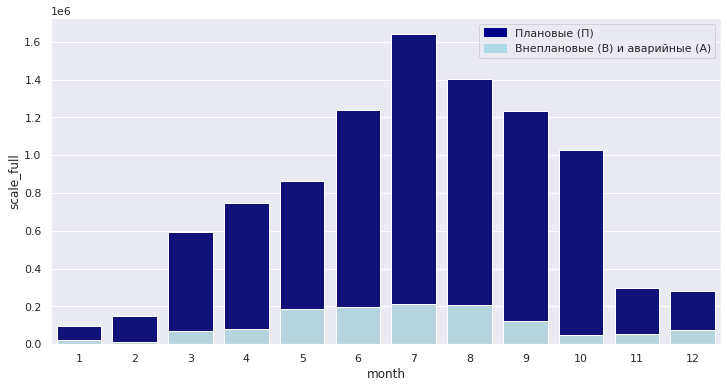


Cуммарные масштабы обесточения потребителей по месяцам в ТСО № 2:


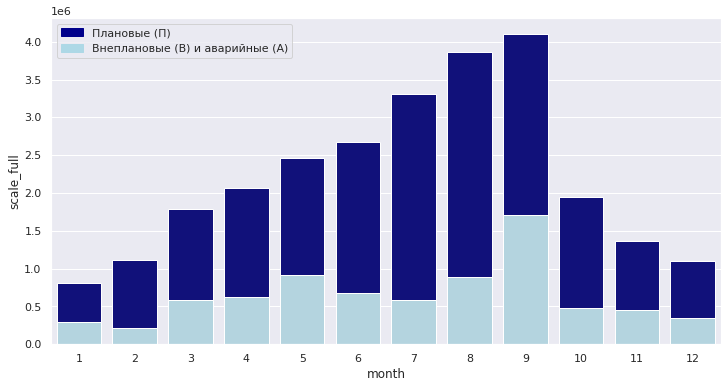


Cуммарные масштабы обесточения потребителей по месяцам в ТСО № 3:


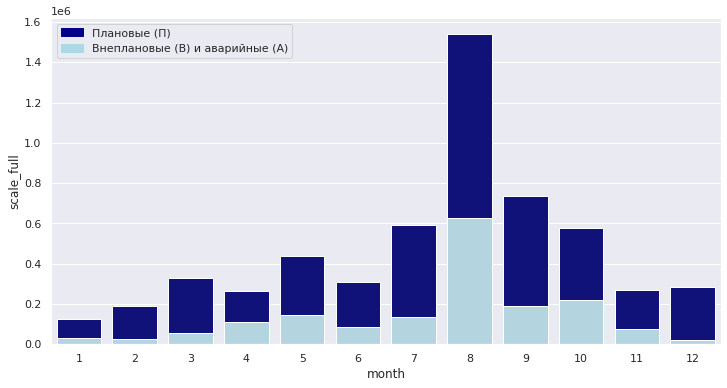


Cуммарные масштабы обесточения потребителей по месяцам в ТСО № 4:


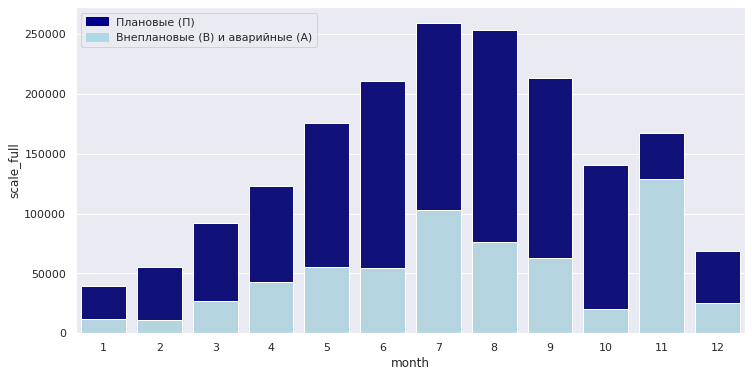


Cуммарные масштабы обесточения потребителей по месяцам в ТСО № 5:


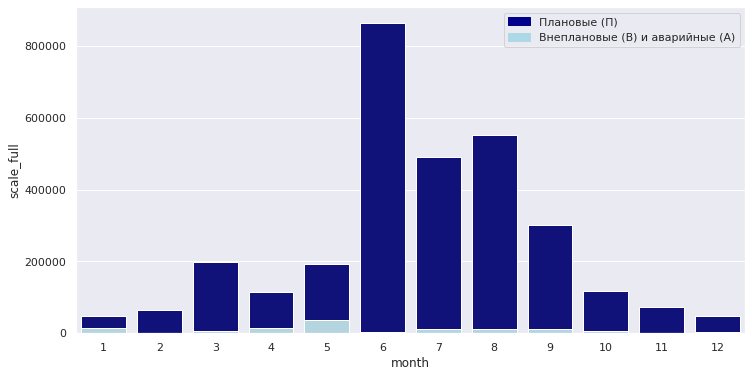

In [97]:
# визуализация в разрезе каждого ТСО:

for TSO in TSO_list:
    print(f'Cуммарные масштабы обесточения потребителей по месяцам в {TSO}:')
   
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 6))

    df_TSO = df[df['02_TSO'] == TSO]
    total = df_TSO.groupby('month')['scale_full'].sum().reset_index()
    bar1 = sns.barplot(x="month",  y="scale_full", data=total, color='darkblue')

    failures_and_unplanned = df_TSO[df_TSO['08_outage_type'].isin(['А', 'В'])]
    bar2 = sns.barplot(x="month", y="scale_full", data=failures_and_unplanned, estimator=sum, ci=None,  color='lightblue')

    top_bar = mpatches.Patch(color='darkblue', label='Плановые (П)')
    middle_bar = mpatches.Patch(color='lightblue', label='Внеплановые (В) и аварийные (А)')
    plt.legend(handles=[top_bar, middle_bar])

    plt.show()
    
    print()

-------------------------

**ВЫВОДЫ:**

1) В ТСО № 1 и ТСО № 5 масштабы обесточения потребителей практически целиком приходятся на плановые отключения. Внеплановые и аварийные отключения вносят чрезвычайно низкий вклад в показатель.

2) В ТСО № 2, ТСО № 3 и ТСО № 4 внеплановые и аварийные отключения играют значительную роль в общих масштабах обесточения потребителей.

3) Пиковые значения внеплановых и аварийных отключений приходятся на следующие месяцы:

- ТСО № 2 - сентябрь (часто отмечаются тайфуны и тропические штормы)

- ТСО № 3 - август (в условиях ослабленной схемы сети из-за ремонтов оборудования)

- ТСО № 4 - ноябрь (необходим отдельный аудит по выявлению причин)

-------------------------




Построение накопительных диаграмм показателей надежности Saidi / Saifi:

In [98]:
# подготовка данных для накопительной диаграммы показателей saidi / saifi по месяцам
# используется созданный ранее датафрейм df_proper (внеплановые отключения ("В") с признаком учёта "1")
df_proper.head(3)

,01_id,02_TSO,03_object_type,04_object_name,05_U_nom,06_time_start,07_time_end,08_outage_type,09_duration,10_causing_objects,...,26_tech_code,27_flag,28_division,reason_class,scale_full,scale_1cat,scale_2cat,scale_3cat,year,month
10,11,ТСО № 1,ВЛ,Желтоярово 4,6-20,2018-01-07 23:42:00,2018-01-08 02:47:00,В,3.083,ВЛ,...,4.10,1,ЗЭС,Недостатки эксплуатации,983.583,0.000,0.000,983.583,2018,1
11,12,ТСО № 1,ВЛ,Куприяновка 1,6-20,2018-01-09 03:26:00,2018-01-09 11:50:00,В,8.400,ВЛ,...,4.16,1,ВЭС,Недостатки эксплуатации,"1,352.400",0.000,0.000,"1,352.400",2018,1
15,16,ТСО № 1,ПС,Таежная В-10 Т-1,6-20,2018-01-09 15:14:00,2018-01-09 15:49:00,В,0.583,ПС,...,4.14,1,ВЭС,Недостатки эксплуатации,627.083,0.000,0.000,627.083,2018,1


In [99]:
# расчет накопительных показателей в разрезе месяцев каждого из ТСО по каждому из годов:
df_monthly = df_proper[['02_TSO', 'year', 'month', '13_points_overall', 'scale_full']].groupby(['02_TSO', 'year', 'month']).sum().groupby(level=(0, 1)).cumsum().reset_index()
df_monthly.head()

,02_TSO,year,month,13_points_overall,scale_full
0,ТСО № 1,2018,1,4952,"5,302.917"
1,ТСО № 1,2018,2,5376,"5,878.300"
2,ТСО № 1,2018,3,13418,"10,815.583"
3,ТСО № 1,2018,4,17730,"16,652.333"
4,ТСО № 1,2018,5,24401,"19,764.067"


In [100]:
# требуется объединение с таблицей df_points
df_points.head()

max_points          limit_saidi          limit_saifi  \
02_TSO  year                                                         
ТСО № 1 2018      147640                2.530                4.670   
        2019      152121                2.490                4.600   
        2020      154179                2.450                4.530   
        2021      156990                2.420                4.460   
        2022      159020                2.380                4.400   

                  sum_limit_saidi      sum_limit_saifi  
02_TSO  year                                            
ТСО № 1 2018          373,529.200          689,478.800  
        2019          378,781.290          699,756.600  
        2020          377,738.550          698,430.870  
        2021          379,915.800          700,175.400  
        2022          378,467.600          699,688.000

In [101]:
# добавление столбца с количеством точек поставки:
df_monthly = df_monthly.merge(df_points.reset_index(), how='left', left_on=('02_TSO', 'year'), right_on=('02_TSO', 'year')).reset_index()
df_monthly = df_monthly[['02_TSO', 'year', 'month', '13_points_overall', 'scale_full', 'max_points', 'limit_saidi', 'limit_saifi']]
df_monthly.head(15)

,02_TSO,year,month,13_points_overall,scale_full,max_points,limit_saidi,limit_saifi
0,ТСО № 1,2018,1,4952,"5,302.917",147640,2.530,4.670
1,ТСО № 1,2018,2,5376,"5,878.300",147640,2.530,4.670
2,ТСО № 1,2018,3,13418,"10,815.583",147640,2.530,4.670
3,ТСО № 1,2018,4,17730,"16,652.333",147640,2.530,4.670
4,ТСО № 1,2018,5,24401,"19,764.067",147640,2.530,4.670
5,ТСО № 1,2018,6,30380,"32,720.567",147640,2.530,4.670
6,ТСО № 1,2018,7,32670,"35,955.383",147640,2.530,4.670
7,ТСО № 1,2018,8,40262,"42,398.911",147640,2.530,4.670
8,ТСО № 1,2018,9,45130,"46,211.461",147640,2.530,4.670
9,ТСО № 1,2018,10,50016,"47,522.311",147640,2.530,4.670


In [102]:
# расчет фактического (накопительного) показателя saidi по итогам каждого из месяцев:
def calc_saidi(row):
    saidi_fact = row['scale_full'] / row['max_points']
    return saidi_fact

# расчет фактического (накопительного) показателя saidi по итогам каждого из месяцев:
def calc_saifi(row):
    saifi_fact = row['13_points_overall'] / row['max_points']
    return saifi_fact

df_monthly['saidi_cumsum'] = df_monthly.apply(calc_saidi, axis=1)
df_monthly['saifi_cumsum'] = df_monthly.apply(calc_saifi, axis=1)
df_monthly.head(14)

,02_TSO,year,month,13_points_overall,scale_full,max_points,limit_saidi,limit_saifi,saidi_cumsum,saifi_cumsum
0,ТСО № 1,2018,1,4952,"5,302.917",147640,2.530,4.670,0.036,0.034
1,ТСО № 1,2018,2,5376,"5,878.300",147640,2.530,4.670,0.040,0.036
2,ТСО № 1,2018,3,13418,"10,815.583",147640,2.530,4.670,0.073,0.091
3,ТСО № 1,2018,4,17730,"16,652.333",147640,2.530,4.670,0.113,0.120
4,ТСО № 1,2018,5,24401,"19,764.067",147640,2.530,4.670,0.134,0.165
5,ТСО № 1,2018,6,30380,"32,720.567",147640,2.530,4.670,0.222,0.206
6,ТСО № 1,2018,7,32670,"35,955.383",147640,2.530,4.670,0.244,0.221
7,ТСО № 1,2018,8,40262,"42,398.911",147640,2.530,4.670,0.287,0.273
8,ТСО № 1,2018,9,45130,"46,211.461",147640,2.530,4.670,0.313,0.306
9,ТСО № 1,2018,10,50016,"47,522.311",147640,2.530,4.670,0.322,0.339


In [103]:
# оставляем только необходимые для диаграммы столбцы:
df_monthly_plot = df_monthly[['02_TSO', 'year', 'month', 'saidi_cumsum', 'saifi_cumsum']]
df_monthly_plot.head()

,02_TSO,year,month,saidi_cumsum,saifi_cumsum
0,ТСО № 1,2018,1,0.036,0.034
1,ТСО № 1,2018,2,0.040,0.036
2,ТСО № 1,2018,3,0.073,0.091
3,ТСО № 1,2018,4,0.113,0.120
4,ТСО № 1,2018,5,0.134,0.165


Помесячная динамика показателя надежности SAIDI по ТСО № 1:


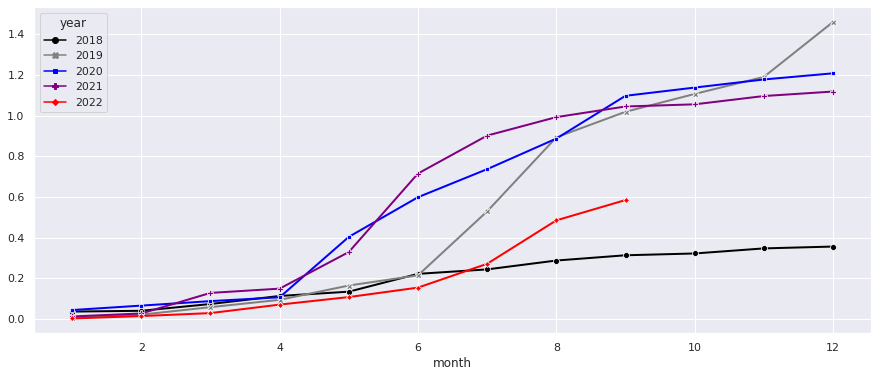


Помесячная динамика показателя надежности SAIDI по ТСО № 2:


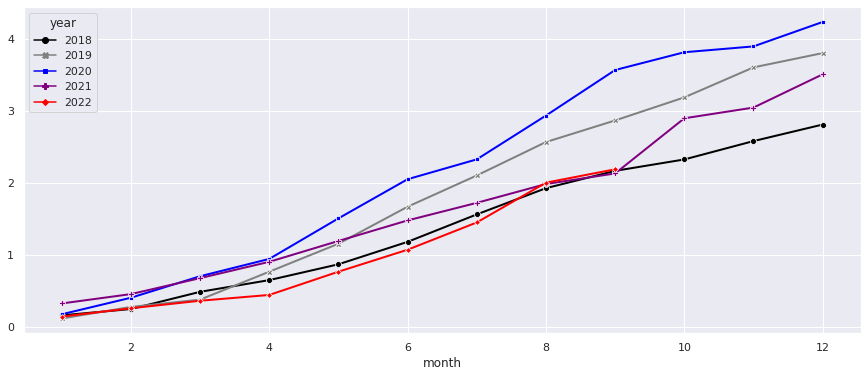


Помесячная динамика показателя надежности SAIDI по ТСО № 3:


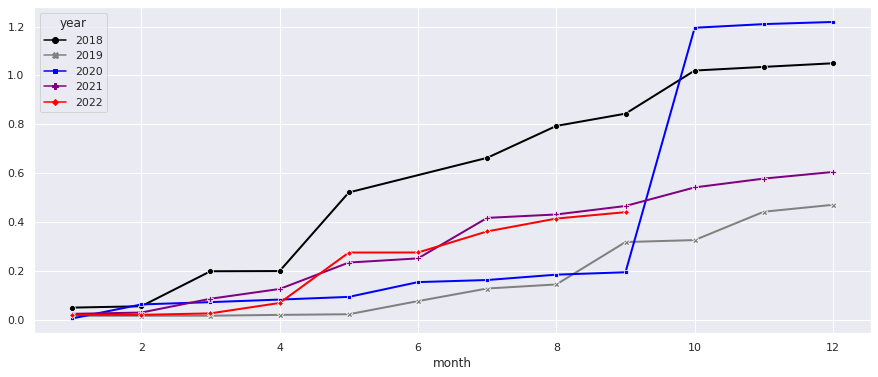


Помесячная динамика показателя надежности SAIDI по ТСО № 4:


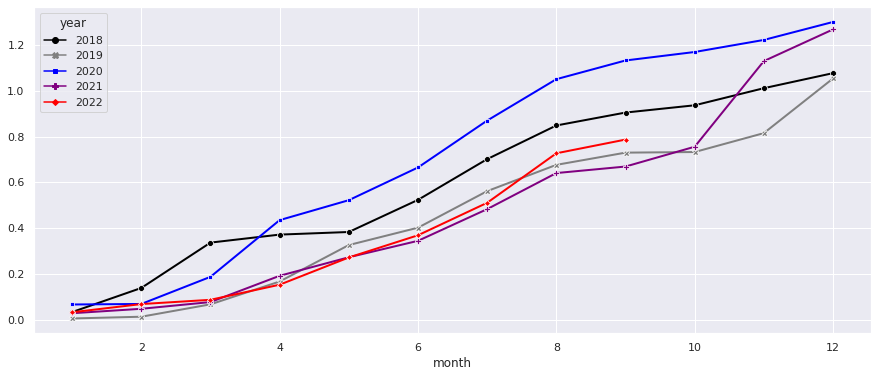


Помесячная динамика показателя надежности SAIDI по ТСО № 5:


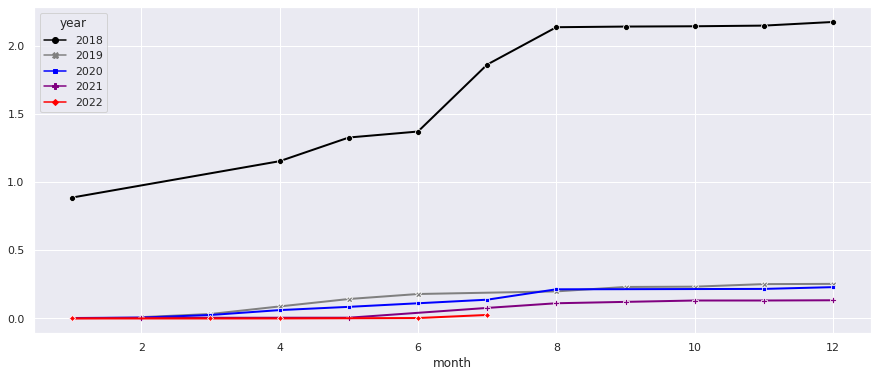

In [104]:
# построение диаграммы (показатель saidi) с временными рядами по каждому ТСО:

for TSO in TSO_list:
    df_diag = pd.pivot_table(df_monthly_plot[df_monthly['02_TSO'] == TSO], values='saidi_cumsum', index='month', columns='year', aggfunc='sum')
    sns.set_theme(style="darkgrid")
    sns.set(rc={'figure.figsize':(15,6)})
    print(f'Помесячная динамика показателя надежности SAIDI по {TSO}:')
    sns.lineplot(data=df_diag, linewidth=2, palette=('black', 'gray', 'blue', 'purple', 'red'), markers=True, dashes=False)
    plt.show()
    print()

-------------------------

**ВЫВОДЫ по показателю SAIDI:**

1) По ТСО № 1 и ТСО № 5 2022 год является по динамике показателя лучшим за весь рассматриваемый период, кроме 2018 года.

2) По ТСО № 2 2022 год является одним из лучших за весь рассматриваемый период (наряду с 2018 и 2021 гг.).

3) По ТСО № 3 2022 год по динамике показателя за 9 месяцев является средним между показателям 2019 и 2020 гг. (наилучшие годы) и 2018 и 2021 гг. (наихудшие годы).

4) По ТСО № 4 2022 год по динамике показателя за 9 месяцев является средним между показателям 2019 и 2021 гг. (наилучшие годы) и 2018 и 2020 гг. (наихудшие годы).

-------------------------

Помесячная динамика показателя надежности SAIFI по ТСО № 1:


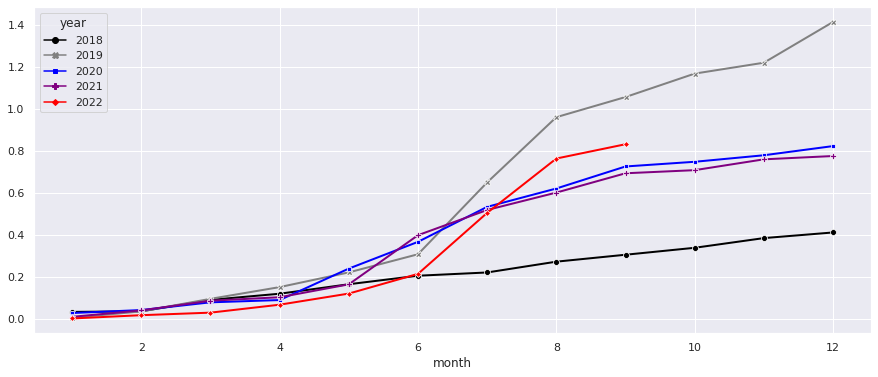


Помесячная динамика показателя надежности SAIFI по ТСО № 2:


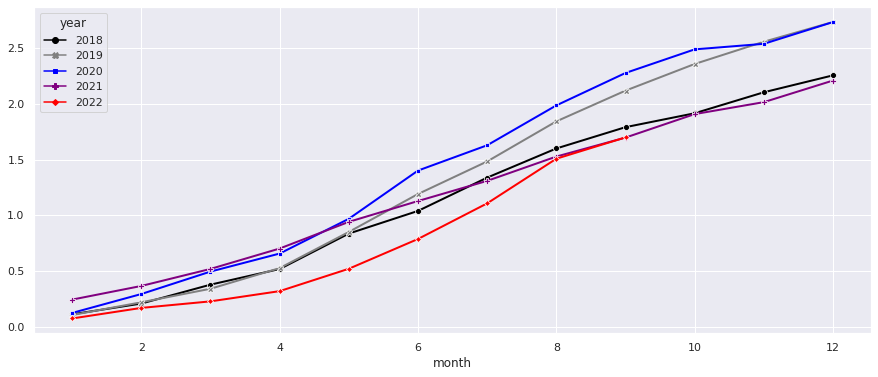


Помесячная динамика показателя надежности SAIFI по ТСО № 3:


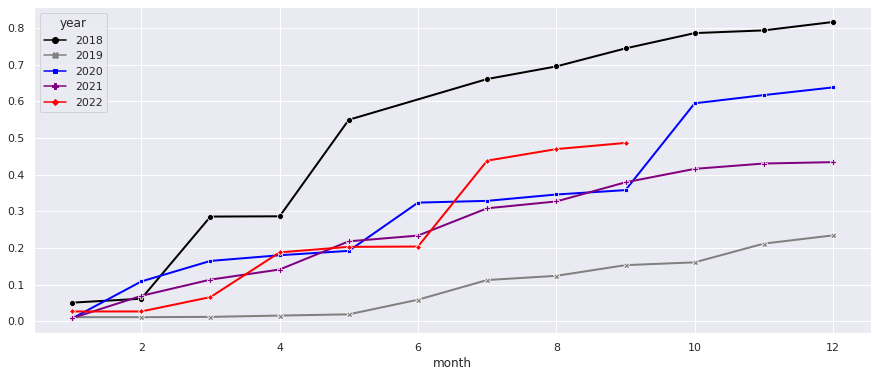


Помесячная динамика показателя надежности SAIFI по ТСО № 4:


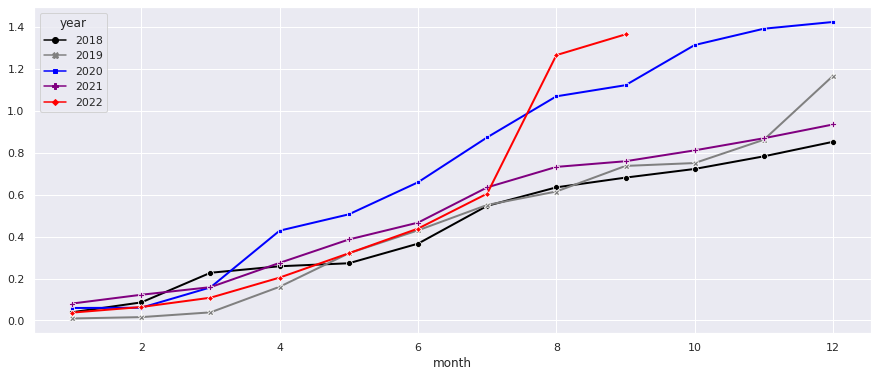


Помесячная динамика показателя надежности SAIFI по ТСО № 5:


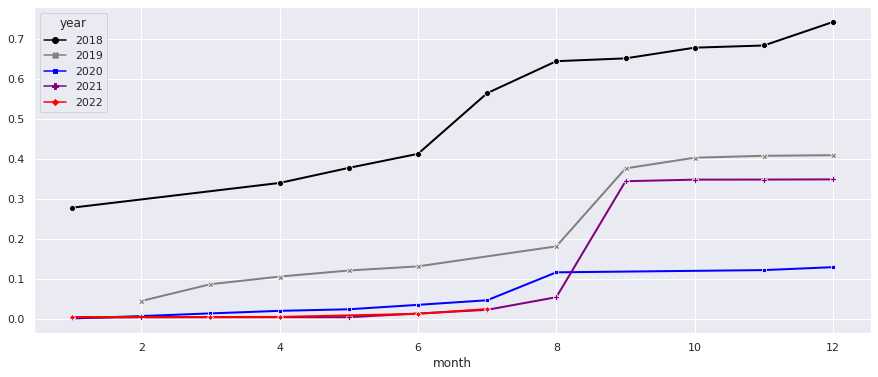

In [105]:
# построение аналогичной диаграммы (показатель saifi) с временными рядами по каждому ТСО:

for TSO in TSO_list:
    df_diag = pd.pivot_table(df_monthly_plot[df_monthly['02_TSO'] == TSO], values='saifi_cumsum', index='month', columns='year', aggfunc='sum')
    sns.set_theme(style="darkgrid")
    sns.set(rc={'figure.figsize':(15,6)})
    print(f'Помесячная динамика показателя надежности SAIFI по {TSO}:')
    sns.lineplot(data=df_diag, linewidth=2, palette=('black', 'gray', 'blue', 'purple', 'red'), markers=True, dashes=False)
    plt.show()
    print()

-------------------------

**ВЫВОДЫ по показателю SAIFI:**

1) По ТСО № 1 по итогам 9 мес. 2022 г. уже превышены годовые показатели за все предыдущие годы, кроме 2019 г., что связано с резким скачком показателя (большим количеством обесточенных потребителей) в июле-августе 2022 года.

2) По ТСО № 2 и ТСО № 5 (по итогам 9 месяцев) 2022 г. является лучшим по динамике за весь рассматриваемый период наблюдений.

3) По ТСО № 3 показатели по итогам 9 мес. 2022 г. являются наихудшими, за исключением 2018 года, что связано с резким скачком показателя (большим количеством обесточенных потребителей) в июле 2022 года.

4) По ТСО № 4 показатели по итогам 9 мес. 2022 г. являются наихудшими за весь рассматриваемый период наблюдений, что связано с резким скачком показателя (большим количеством обесточенных потребителей) в августе 2022 года.

-------------------------

#### Оценка распределения длительности обесточений потребителей

In [106]:
# распределение отключений по длительности обесточения потребителей на 4 равные по количесту записей группы
dur_score = pd.qcut(df['09_duration'], 4)
dur_score.head()

1    (-0.001, 0.783]
2    (-0.001, 0.783]
3     (0.783, 1.783]
4       (1.783, 3.7]
5     (0.783, 1.783]
Name: 09_duration, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 0.783] < (0.783, 1.783] < (1.783, 3.7] <
                                           (3.7, 2209.35]]

In [107]:
# распределение отключений по группам с присвоением текстовых лейблов вместо границ интервалов:
names = ['1 - оперативное', '2 - лучше среднего', '3 - хуже среднего', '4 - длительное']
dur_score = pd.qcut(df['09_duration'], 4, labels=names)
dur_score.head()
df['duration_score'] = dur_score
df.head()

,01_id,02_TSO,03_object_type,04_object_name,05_U_nom,06_time_start,07_time_end,08_outage_type,09_duration,10_causing_objects,...,27_flag,28_division,reason_class,scale_full,scale_1cat,scale_2cat,scale_3cat,year,month,duration_score
1,2,ТСО № 1,ВЛ,ТП 10-5 ф3,0.4,2018-01-03 05:55:00,2018-01-03 06:24:00,В,0.483,ВЛ,...,0,ЦЭС,Сторонние воздействия,0.483,0.000,0.000,0.483,2018,1,1 - оперативное
2,3,ТСО № 1,ВЛ,Чалбачи 8,6-20,2018-01-03 06:50:00,2018-01-03 07:25:00,В,0.583,ВЛ,...,0,СЭС,Природные воздействия,32.667,0.000,0.000,32.667,2018,1,1 - оперативное
3,4,ТСО № 1,ВЛ,ПС Базовая ф15-10 ТП-1 ф1,0.4,2018-01-03 09:20:00,2018-01-03 10:08:00,В,0.800,ВЛ,...,0,ЗЭС,Сторонние воздействия,32.000,0.000,0.000,32.000,2018,1,2 - лучше среднего
4,5,ТСО № 1,ВЛ,ТП 10-13 ф3,0.4,2018-01-05 08:13:00,2018-01-05 11:00:00,В,2.783,ВЛ,...,0,ЦЭС,Сторонние воздействия,2.783,0.000,0.000,2.783,2018,1,3 - хуже среднего
5,6,ТСО № 1,ВЛ,Дачная 14,6-20,2018-01-06 04:47:00,2018-01-06 05:37:00,В,0.833,ВЛ,...,0,ЦЭС,Сторонние воздействия,95.833,0.000,0.000,95.833,2018,1,2 - лучше среднего


In [108]:
# группировка в разрезе ТСО и количества записей по созданным группам:
dur_table = df.groupby(['02_TSO', 'duration_score']).count()['09_duration'].reset_index()
dur_table

,02_TSO,duration_score,09_duration
0,ТСО № 1,1 - оперативное,6279
1,ТСО № 1,2 - лучше среднего,5452
2,ТСО № 1,3 - хуже среднего,6874
3,ТСО № 1,4 - длительное,5129
4,ТСО № 2,1 - оперативное,16410
5,ТСО № 2,2 - лучше среднего,18477
6,ТСО № 2,3 - хуже среднего,16825
7,ТСО № 2,4 - длительное,17699
8,ТСО № 3,1 - оперативное,2615
9,ТСО № 3,2 - лучше среднего,2008


In [109]:
# расчет доли каждой группы по длительности ликвидации обесточения потребителей (в разрезе ТСО) через оконную функцию:

def share_dur(df):
    total_dur = df['09_duration'].sum()
    df['share_dur_%'] = df['09_duration'] / total_dur * 100

    return df

dur_table = dur_table.groupby('02_TSO').apply(share_dur).sort_values('02_TSO')

In [110]:
# сводная таблица по доле отключений (в %) по каждому ТСО на каждую группу по длительности:
pd.pivot_table(dur_table, values='share_dur_%', index='02_TSO', columns='duration_score', aggfunc='sum')

duration_score,1 - оперативное,2 - лучше среднего,3 - хуже среднего,4 - длительное
02_TSO,,,,
ТСО № 1,26.456,22.971,28.963,21.610
ТСО № 2,23.642,26.620,24.240,25.499
ТСО № 3,26.567,20.400,23.133,29.899
ТСО № 4,29.359,20.776,23.288,26.577
ТСО № 5,29.715,26.653,20.790,22.843


-------------------------

**ВЫВОДЫ:**

1) В целом оперативность восстановления электроснабжения потребителей по всем ТСО примерно равномерно распределена по всем 4 категориям (интервалам).

2) Наибольшая доля случаев обесточения, попавших в 4 категорию (время ликвидации более 3,68 ч.), зафиксировано в ТСО № 3 (~30%).

3) Наилучшая эффективность восстановления электроснабжения потребителей отмечена в ТСО № 5 (на 3 и 4 группы приходится лишь 43% отключений).

4) По ТСО № 3 рекомендуется провести анализ оптимальности размещения производственных баз и аварийно-восстановительных бригад, достаточности аварийного запаса оборудования и материалов для повышения оперативности восстановления электроснабжения потребителей.

-------------------------

#### Оценка корретности учета / неучета отключений в расчете показателей надежности в зависимости от организационных причин аварий

-------------------------

1) В соответствии с требованиями действующих нормативно-правовых актов, учету в расчете показателей надежности (значение поля '27_flag', равное "1") подлежат все отключения, **связанные с виной электросетевой организации**.

2) Классификатор организационных причин аварий позволяет выделить ряд причин, при которых наличие вины электросетевой организации бесспорно (например, 3.4.7.3 - "Несвоевременное выявление и устранение дефектов").

3) Аналогичным образом можно выделить ряд причин, при которых в явном виде отсутствует вина электросетевой организации в обесточении потребителей (например, 3.4.11 - "Превышение параметров воздействия стихийных явлений относительно условий проекта").

4) При этом существует и третья группа причин аварий, при которых о наличии либо отсутствии вины электросетевой организации можно судить только исходя из анализа каждой конкретной аварийной ситуации (например, 3.4.12.4 - "Природные пожары" - необходима оценка достаточности мер, предпринятых электросетевой организацией для исключения пожаров в охранной зоне воздушной ЛЭП).

-------------------------

In [111]:
# анализ будет проводиться по данным за 2021-2022 гг. (в 2020 г. были уточнены рекомендации по определению орг. причин аварий):
df_codes = df[ (~df['25_org_code'].isnull()) & (df['year'].isin([2020, 2021])) ]
print(f'Всего отключений, имеющих коды организационных причин аварий (за 2021-2022 гг.): {len(df_codes)}')

Всего отключений, имеющих коды организационных причин аварий (за 2021-2022 гг.): 16041


In [112]:
# выделение столбцов, требующихся для дальнейшего анализа:
df_codes = df_codes[['02_TSO', '08_outage_type', '25_org_code', '27_flag', 'scale_full', 'year']]

In [113]:
df_codes_full = df_codes.merge(df_org_reasons, how='left', left_on='25_org_code', right_on='org_code')
df_codes_full.head()

,02_TSO,08_outage_type,25_org_code,27_flag,scale_full,year,org_code,org_reason
0,ТСО № 1,В,3.4.8.5,0,0.567,2020,3.4.8.5,Прочие воздействия
1,ТСО № 1,В,3.4.8.5,0,0.483,2020,3.4.8.5,Прочие воздействия
2,ТСО № 1,В,3.4.7.4,1,138.333,2020,3.4.7.4,Прочие нарушения (износ)
3,ТСО № 1,В,3.4.8.5,0,1.717,2020,3.4.8.5,Прочие воздействия
4,ТСО № 1,В,3.4.7.4,1,86.667,2020,3.4.7.4,Прочие нарушения (износ)


In [114]:
# распределение причин по 3 указанным категориям:
reasons_to_blame = ['3.4.1', '3.4.3', '3.4.4', '3.4.6', '3.4.7', '3.4.7.1', '3.4.7.2', '3.4.7.3', '3.4.7.4', '3.4.14']
reasons_no_blame = ['3.4.8', '3.4.8.1', '3.4.8.2', '3.4.8.3', '3.4.8.4', '3.4.8.5', '3.4.9', '3.4.9.1', '3.4.9.2', '3.4.9.3', '3.4.11']
reasons_uncertain_blame = ['3.4.12', '3.4.12.1', '3.4.12.2', '3.4.12.3', '3.4.12.4', '3.4.12.5', '3.4.10', '3.4.13', '3.4.13.1', '3.4.13.2', '3.4.13.3', '3.4.13.4']

# создание атрибута (столбца) с указанием нужной категории
df_codes_full.loc[df_codes_full['25_org_code'].isin(reasons_to_blame), 'TSO_blame'] = 'Вина ТСО'
df_codes_full.loc[df_codes_full['25_org_code'].isin(reasons_no_blame), 'TSO_blame'] = 'Нет вины ТСО'
df_codes_full.loc[df_codes_full['25_org_code'].isin(reasons_uncertain_blame), 'TSO_blame'] = 'Определяется при расследовании'
df_codes_full.head()

,02_TSO,08_outage_type,25_org_code,27_flag,scale_full,year,org_code,org_reason,TSO_blame
0,ТСО № 1,В,3.4.8.5,0,0.567,2020,3.4.8.5,Прочие воздействия,Нет вины ТСО
1,ТСО № 1,В,3.4.8.5,0,0.483,2020,3.4.8.5,Прочие воздействия,Нет вины ТСО
2,ТСО № 1,В,3.4.7.4,1,138.333,2020,3.4.7.4,Прочие нарушения (износ),Вина ТСО
3,ТСО № 1,В,3.4.8.5,0,1.717,2020,3.4.8.5,Прочие воздействия,Нет вины ТСО
4,ТСО № 1,В,3.4.7.4,1,86.667,2020,3.4.7.4,Прочие нарушения (износ),Вина ТСО


In [115]:
# сводная таблица, отражающая порядок учета аварийных отключений по каждой из причин при расчете показателей надежности:
df_codes_pivot1 = pd.pivot_table(df_codes_full, values='08_outage_type', index=('02_TSO', '27_flag'), columns='TSO_blame', aggfunc='count', fill_value=0, margins=True, margins_name='ИТОГО')
df_codes_pivot1[['Вина ТСО', 'Нет вины ТСО']]

TSO_blame        Вина ТСО  Нет вины ТСО
02_TSO  27_flag                        
ТСО № 1 0               2           741
        1             307             9
ТСО № 2 0              10           997
        1            4720             0
ТСО № 3 0              17           327
        1             212             1
ТСО № 4 0               2           198
        1              40             5
ТСО № 5 0               0            82
        1              31             6
ИТОГО                5341          2366

-------------------------

**ВЫВОДЫ:**

1) В подавляющем большинстве случаев учет/неучет отключений при расчете показателей надежности проводится корректно.

2) Однако во всех ТСО имеются отдельные случаи некорректного определения признака учета отключения при расчете показателей надежности.

-------------------------

In [116]:
# оценка причин, по которым чаще всего происходит некорректная классификация признака учета:
df_codes_full[ ((df_codes_full['27_flag'] == 1) & (df_codes_full['TSO_blame'] == 'Нет вины ТСО')) \
              | ((df_codes_full['27_flag'] == 0) & (df_codes_full['TSO_blame'] == 'Вина ТСО')) ] \
              .groupby(['25_org_code', 'org_reason']).count()['27_flag'].sort_values(ascending=False)

25_org_code  org_reason                                                              
3.4.7.1      Несоблюдение сроков ТО и ремонта оборудования, устройств                    10
3.4.14       Не выявленные причины                                                        8
3.4.7.3      Несвоевременное выявление и устранение дефектов                              7
3.4.7.4      Прочие нарушения (износ)                                                     6
3.4.8.5      Прочие воздействия                                                           6
3.4.9.2      Отключение (повреждение) оборудования на объекте генерации                   6
3.4.9.3      Отключение (повреждение) оборудования потребителей электрической энергии     4
3.4.9.1      Отключение (повреждение) оборудования в смежной электрической сети           3
3.4.8.3      Несанкционированная рубка лесных насаждений                                  1
3.4.8.4      Наброс посторонних предметов на ВЛ                                       

-------------------------

**ВЫВОД:**

Наиболее часто неверная классификация происходит при аварийных отключениях, связанных с несвоевременным выполнением технического обслуживания и ремонтов оборудования (класс причин 3.4.7).

-------------------------

In [117]:
# оценка порядка учета в расчете показателей надежности отключений из-за группы причин "Определяется при расследовании"
df_codes_pivot_data = df_codes_full[ df_codes_full['TSO_blame'] == 'Определяется при расследовании' ]
df_codes_pivot = pd.pivot_table(df_codes_pivot_data, values='08_outage_type', index=('25_org_code', 'org_reason'), columns=('02_TSO', '27_flag'), aggfunc='count', fill_value=0, margins=True, margins_name='Итого')
df_codes_pivot

02_TSO                                                         ТСО № 1        \
27_flag                                                              0     1   
25_org_code org_reason                                                         
3.4.10      Воздействие животных и птиц                            368     3   
3.4.12      Воздействие повторяющихся стихийных явлений              0    44   
3.4.12.1    Гололедно-изморозевые отложения                          0     5   
3.4.12.2    Ветровые нагрузки                                        1   189   
3.4.12.3    Атмосферные перенапряжения (гроза)                       0   403   
3.4.12.4    Природные пожары                                         0     6   
3.4.12.5    Прочие воздействия неблагоприятных природных яв...       0   312   
3.4.13.1    Недостатки проекта                                       0     2   
3.4.13.2    Недостатки конструкции                                   0     7   
3.4.13.3    Дефекты изготовления                                     0    75   
3.4.13.4    Дефекты монтажа                                          0    20   
Итого                                                              369  1066   

02_TSO                                                         ТСО № 2      \
27_flag                                                              0   1   
25_org_code org_reason                                                       
3.4.10      Воздействие животных и птиц                            328   3   
3.4.12      Воздействие повторяющихся стихийных явлений              0   0   
3.4.12.1    Гололедно-изморозевые отложения                         21   0   
3.4.12.2    Ветровые нагрузки                                     2238   0   
3.4.12.3    Атмосферные перенапряжения (гроза)                     273   0   
3.4.12.4    Природные пожары                                        15   0   
3.4.12.5    Прочие воздействия неблагоприятных природных яв...    2263   0   
3.4.13.1    Недостатки проекта                                       0   0   
3.4.13.2    Недостатки конструкции                                   0   9   
3.4.13.3    Дефекты изготовления                                    33  33   
3.4.13.4    Дефекты монтажа                                         27  17   
Итого                                                             5198  62   

02_TSO                                                         ТСО № 3      \
27_flag                                                              0   1   
25_org_code org_reason                                                       
3.4.10      Воздействие животных и птиц                             41   0   
3.4.12      Воздействие повторяющихся стихийных явлений              3   0   
3.4.12.1    Гололедно-изморозевые отложения                         48   2   
3.4.12.2    Ветровые нагрузки                                      331  44   
3.4.12.3    Атмосферные перенапряжения (гроза)                     118   7   
3.4.12.4    Природные пожары                                         2   0   
3.4.12.5    Прочие воздействия неблагоприятных природных яв...     189   1   
3.4.13.1    Недостатки проекта                                       0   7   
3.4.13.2    Недостатки конструкции                                   0  19   
3.4.13.3    Дефекты изготовления                                     0   5   
3.4.13.4    Дефекты монтажа                                          9  13   
Итого                                                              741  98   

02_TSO                                                         ТСО № 4       \
27_flag                                                              0    1   
25_org_code org_reason                                                        
3.4.10      Воздействие животных и птиц                            162    2   
3.4.12      Воздействие повторяющихся стихийных явлений              0    0   
3.4.12.1    Гололедно-изморозевые отложения                   

-------------------------

**ВЫВОД:**

Наблюдаются принципиальные различия порядка учета/неучета в показателях надежности отключений по причинам, относящимся к коду 3.4.12 "Воздействие повторяющихся стихийных явлений".

Данный факт приводит к некорректности сопоставления показателей надежности ТСО, учитываемых тарифными органами.

**Рекомендация:**

Определить единую для всех ТСО методологию принятия решений об учете / неучете отключений по причинам, входящим в блок 3.4.12 "Воздействие повторяющихся стихийных явлений".

-------------------------

#### Оценка недоотпуска электроэнергии в результате отключений с обесточением потребителей

In [118]:
# будут использоваться только отключения с ненулевыми значениями в столбце "22_outage_power" за 2019-2022 гг.

df_power = df[ (df['22_outage_power'] > 0) & (df['year'].isin([2019, 2020, 2021, 2022]) ) ]
len(df_power)

57103

In [119]:
# добавление столбца по объему недоотпущенной электроэнергии (мощность * длительность):
df_power['volume'] = df_power['09_duration'] * df_power['22_outage_power']

<ipython-input-119-8c6037777bad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_power['volume'] = df_power['09_duration'] * df_power['22_outage_power']


In [120]:
# группировка по ТСО и годам в разрезе показателей количества отключений с недоотпуском электроэнергии и мощности
df_power_diag = df_power.groupby(['02_TSO', 'year']).agg({'volume': ('count', 'sum')}).reset_index()
df_power_diag

02_TSO  year volume                     
                   count                  sum
0   ТСО № 1  2019   5435        4,113,052.413
1   ТСО № 1  2020   4139        2,963,708.971
2   ТСО № 1  2021   3889        5,892,462.241
3   ТСО № 1  2022   3131       11,231,583.070
4   ТСО № 2  2019   6944        8,669,222.643
5   ТСО № 2  2020   6656       10,123,256.347
6   ТСО № 2  2021   5342        6,390,969.286
7   ТСО № 2  2022   6406        6,642,252.200
8   ТСО № 3  2019   2537        2,962,442.964
9   ТСО № 3  2020   2226        2,920,334.254
10  ТСО № 3  2021    897        1,144,179.597
11  ТСО № 3  2022    815        1,372,004.040
12  ТСО № 4  2019   1486          422,696.568
13  ТСО № 4  2020   1021          520,833.131
14  ТСО № 4  2021    873          353,559.650
15  ТСО № 4  2022    713          493,264.050
16  ТСО № 5  2019   1350        4,361,857.999
17  ТСО № 5  2020   1226        1,010,754.682
18  ТСО № 5  2021   1107          787,640.235
19  ТСО № 5  2022    910          924,966.566

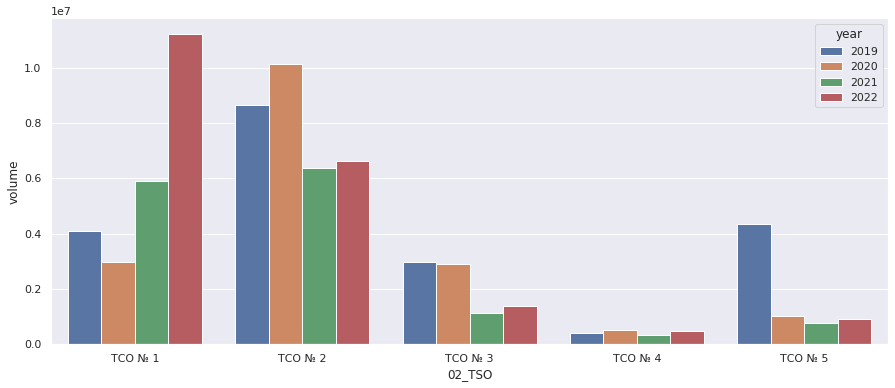

In [121]:
# визуализация объемов неоотпуска электроэнергии
df_power_diag = df_power.groupby(['02_TSO', 'year']).sum()['volume'].reset_index()

sns.set(style="darkgrid")
sns.barplot(x="02_TSO", y="volume", hue="year", data=df_power_diag, ci=None)

------------------------------

**ВЫВОДЫ:**

1) По итогам 9 месяцев 2022 г. по всем ТСО объем недоотпуска электроэнергии (кВт*час) уже превысил значения 2019-2021 гг.

2) Особенно значительное превышение недоотпуска зафиксировано в ТСО № 1.

------------------------------

In [122]:
# группировка в разрезе ТСО и причин отключений по объемам недоотпуска электроэнергии:
pwr_table = df_power.groupby(['02_TSO', 'year', 'reason_class']).sum()['volume'].reset_index()
pwr_table.head()

,02_TSO,year,reason_class,volume
0,ТСО № 1,2019,Недостатки эксплуатации,"127,143.722"
1,ТСО № 1,2019,Природные воздействия,"305,385.058"
2,ТСО № 1,2019,Сторонние воздействия,"204,251.832"
3,ТСО № 1,2020,Недостатки эксплуатации,"82,069.534"
4,ТСО № 1,2020,Природные воздействия,"194,065.065"


In [123]:
# Распределение недоотпуска электроэнергии по группам причин отключений:

def share_power(df):
    total_pwr = df['volume'].sum()
    df['share_power_%'] = df['volume'] / total_pwr * 100

    return df

pwr_table = pwr_table.groupby(['02_TSO', 'year']).apply(share_power).sort_values(['02_TSO', 'year', 'reason_class'])
pwr_table

,02_TSO,year,reason_class,volume,share_power_%
0,ТСО № 1,2019,Недостатки эксплуатации,"127,143.722",19.967
1,ТСО № 1,2019,Природные воздействия,"305,385.058",47.958
2,ТСО № 1,2019,Сторонние воздействия,"204,251.832",32.076
3,ТСО № 1,2020,Недостатки эксплуатации,"82,069.534",19.515
4,ТСО № 1,2020,Природные воздействия,"194,065.065",46.145
5,ТСО № 1,2020,Сторонние воздействия,"144,420.877",34.341
6,ТСО № 1,2021,Недостатки эксплуатации,"42,594.893",10.166
7,ТСО № 1,2021,Природные воздействия,"178,206.695",42.533
8,ТСО № 1,2021,Сторонние воздействия,"198,179.284",47.300
9,ТСО № 1,2022,Недостатки эксплуатации,"99,666.563",16.153


------------------------------

**ВЫВОДЫ:**

1) По ТСО № 2, ТСО № 3, ТСО № 5 распределение объемов недоотпуска электроэнергии по различным группам причин отключений в целом равномерно.

2) В ТСО № 1 и особенно ТСО № 4 отмечается низкая доля обесточений по отключениям, связанным с недостатками эксплуатации.

------------------------------

### III. Кластеризация отключений по длительности восстановления электроснабжения и масштабам обесточения потребителей

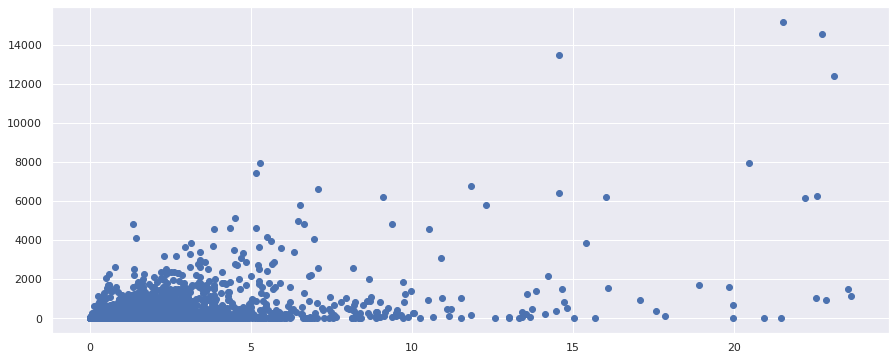

In [124]:
# анализ целесообразно проводить только по внеплановым отключениям ("В") за 2021-2022 гг. (наивысшее качество данных)
data_clust = df_proper[(df_proper['08_outage_type'] == 'В') & (df_proper['year'].isin([2021, 2022]))]
data_clust = data_clust[['09_duration', 'scale_full']]

# исключение выбросов (длительность более 24 ч и масштабы более 20 000 ч * точ. поставки)
data_clust = data_clust[(data_clust['09_duration'] <= 24) & (data_clust['scale_full'] <= 20000)]

# визуализация начальных данных
plt.scatter(data_clust['09_duration'], data_clust['scale_full'], cmap='autumn')

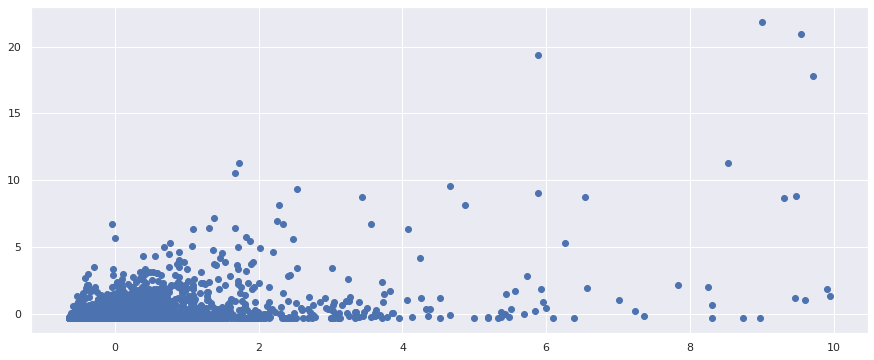

In [125]:
# приведение значений признаков к единому масштабу и визуализация

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_clust)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], cmap='autumn')

In [126]:
# подбор оптимального числа кластеров для алгоритма kmeans
# строим график локтя
# создаем список для инерции
k_inertia = []
# задаем диапазон кластеров
ks = range(1, 10)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clf_kmeans.fit(X_scaled)
    # добавляем инерцию каждой модели в список
    k_inertia.append(clf_kmeans.inertia_)

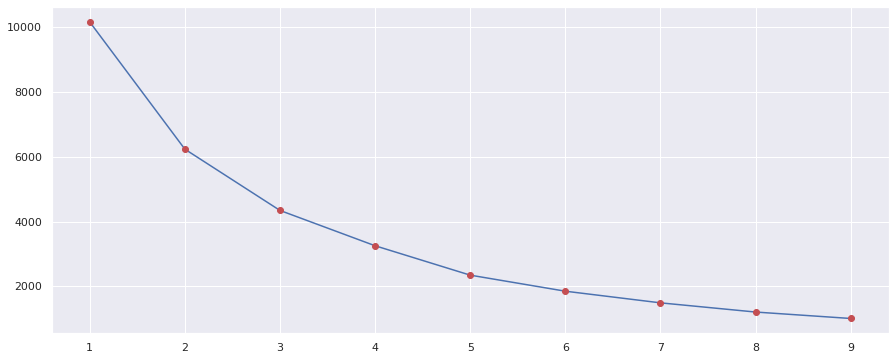

In [127]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia , 'ro')

In [128]:
# принимаем количество кластеров равным 4 (вариант с 5 кластерами излишне усложняет интерпретацию данных)
kmeans = KMeans(n_clusters=4)

# обучение
clusters = kmeans.fit_predict(X_scaled)

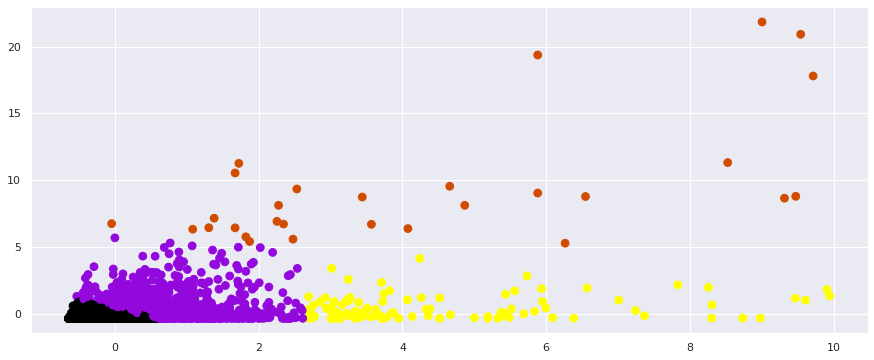

In [129]:
# визуализация кластеров
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], cmap='gnuplot', c=clusters, s=60)

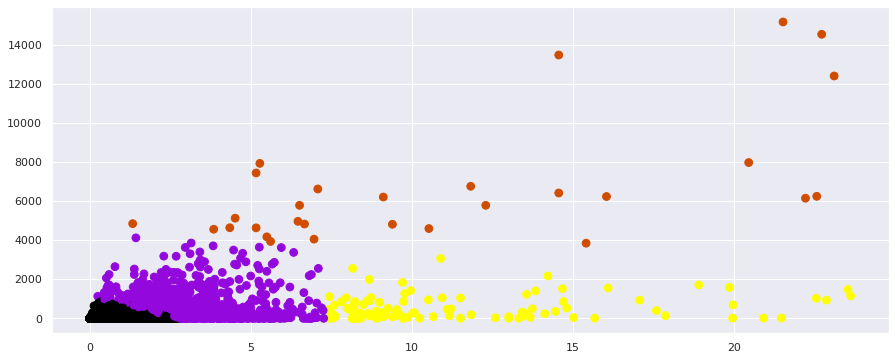

In [130]:
# обратное преобразование отмасштабированных данных в длительность обесточения (ось Х, ч.) и масштабы обесточения (ось Y, ч.*точки поставки)
inversed = scaler.inverse_transform(X_scaled)
plt.scatter(inversed[:, 0], inversed[:, 1], cmap='gnuplot', c=clusters, s=60)

-------------------------

ВЫВОДЫ:

1) Исходя из результатов кластеризации, внеплановые отключения оптимально делить на 4 кластера:
- отключения с незначительными последствиями (1 кластер)
- отключения с умеренными последствиями (2 кластер)
- отключения с высокой длительностью и умеренными масштабами обесточения (3 кластер)
- отключения с высокими масштабами недоотпуска (4 кластер)

2) Примерные границы кластеров:
- 1 кластер - до 2.5 ч. (длительность) и до 1000 ч.*точ. поставки (масштаб)
- 2 кластер - до 7.5 ч. (длительность) и до 4000 ч.*точ. поставки (масштаб)
- 3 кластер - свыше 7.5 ч. (длительность) и до 4000 ч.*точ. поставки (масштаб)
- 4 кластер - свыше 4000 ч.*точ. поставки (масштаб) без ограничений по длительности

-------------------------

In [131]:
# функция определяет кластер, к которому относится отключение:

def define_clusters(row):
    if (row['09_duration'] < 2.5) and (row['scale_full'] < 1000):
        return 1
    elif ((row['09_duration'] >= 2.5) and (row['09_duration'] <= 7.5) and (row['scale_full'] <= 4000)) \
          or ((row['09_duration'] < 2.5) and ((row['scale_full'] <= 4000) and (row['scale_full'] >= 1000))):
        return 2
    elif (row['09_duration'] > 7.5) and (row['scale_full'] <= 4000):
        return 3
    elif row['scale_full'] > 4000:
        return 4
    else:
        return 'Error!'

In [132]:
# создание столбца с значением кластера с сортировкой результатов по ТСО и кластерам:
df_proper['cluster'] = df_proper.apply(define_clusters, axis=1)
df_clusterized = df_proper[['02_TSO', '09_duration', 'scale_full', 'cluster']]
df_clust_gr = df_clusterized.groupby(['02_TSO', 'cluster']).count()['scale_full'].reset_index()
df_clust_gr.head()

<ipython-input-132-dd44f47c3d9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proper['cluster'] = df_proper.apply(define_clusters, axis=1)


,02_TSO,cluster,scale_full
0,ТСО № 1,1,2207
1,ТСО № 1,2,328
2,ТСО № 1,3,23
3,ТСО № 1,4,33
4,ТСО № 2,1,9065


In [133]:
# расчет доли каждого кластера в каждом ТСО через оконную функцию:

def share_clusters(df):
    total = df['scale_full'].sum()
    df['share_cluster_%'] = df['scale_full'] / total * 100

    return df

df_clust_gr = df_clust_gr.groupby('02_TSO').apply(share_clusters).sort_values('02_TSO')
df_clust_gr.head(8)

,02_TSO,cluster,scale_full,share_cluster_%
0,ТСО № 1,1,2207,85.179
1,ТСО № 1,2,328,12.659
2,ТСО № 1,3,23,0.888
3,ТСО № 1,4,33,1.274
4,ТСО № 2,1,9065,78.778
5,ТСО № 2,2,2135,18.554
6,ТСО № 2,3,257,2.233
7,ТСО № 2,4,50,0.435


In [134]:
df_diag = pd.pivot_table(df_clust_gr, values='share_cluster_%', index='02_TSO', columns='cluster', aggfunc='sum')
df_diag = df_diag.rename_axis(None, axis=1).reset_index()     # избавляемся от мультииндекса в столбцах
df_diag

,02_TSO,1,2,3,4
0,ТСО № 1,85.179,12.659,0.888,1.274
1,ТСО № 2,78.778,18.554,2.233,0.435
2,ТСО № 3,77.843,12.682,7.726,1.749
3,ТСО № 4,81.342,15.245,3.072,0.341
4,ТСО № 5,69.620,22.152,6.962,1.266


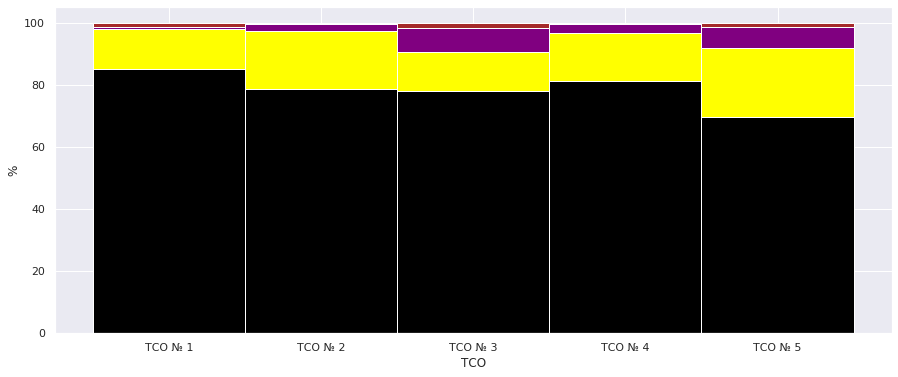

In [135]:
# диаграмма распределения отключений по кластерам в разрезе ТСО:

bars1 = df_diag[1]
bars2 = df_diag[2]
bars3 = df_diag[3]
bars4 = df_diag[4]

bars12 = np.add(bars1, bars2).tolist()
bars123 = np.add(np.add(bars1, bars2), bars3).tolist()

r = [0,1,2,3,4]

names = df_diag['02_TSO']
barWidth = 1

plt.bar(r, bars1, color='black', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=bars1, color='yellow', edgecolor='white', width=barWidth)
plt.bar(r, bars3, bottom=bars12, color='purple', edgecolor='white', width=barWidth)
plt.bar(r, bars4, bottom=bars123, color='brown', edgecolor='white', width=barWidth)

plt.xticks(r, names)
plt.xlabel("ТСО")
plt.ylabel("%")
plt.show()

-------------------------

**ВЫВОДЫ:**

1) Наилучшее распределение отключений по кластерам отмечается в ТСО № 1 и ТСО № 4.

2) Наихудшее распределение отключений по кластерам отмечается в ТСО № 5 и ТСО № 3.

3) ТСО № 5 и ТСО № 3 рекомендуется разработать комплекс мероприятий по повышению уровня готовности к выполнению аварийно-восстановительных работ (при возможности - частично перенять опыт ТСО № 1 и № 4), оценить укомплектованность парка авто- и спецтехники, оснащенность аварийным запасом, оптимальность размещения производственных баз и плеч обслуживания линейных бригад.

-------------------------

### IV. Оценка зависимости показателей надежности saidi, saifi от износа электрических сетей

#### Оценка уровня корреляции:

In [136]:
# создание датафрейма для анализа взаимосвязей и зависимостей
df_corr_merged = saidi_saifi_stacked.merge(df_deter, how='left', left_on=('02_TSO', 'year'), right_on=('TSO', 'year'))
df_corr_merged = df_corr_merged[['02_TSO', 'year', 'saidi_fact', 'saifi_fact', '%over40']]
df_corr_merged

,02_TSO,year,saidi_fact,saifi_fact,%over40
0,ТСО № 1,2018,10.874,4.417,0.290
1,ТСО № 1,2019,12.395,6.167,0.290
2,ТСО № 1,2020,9.700,3.427,0.300
3,ТСО № 1,2021,13.741,4.566,0.300
4,ТСО № 1,2022,15.324,5.323,0.310
5,ТСО № 2,2018,32.231,12.839,0.380
6,ТСО № 2,2019,43.577,16.336,0.390
7,ТСО № 2,2020,50.405,15.857,0.400
8,ТСО № 2,2021,35.124,12.420,0.410
9,ТСО № 2,2022,32.681,10.851,0.420


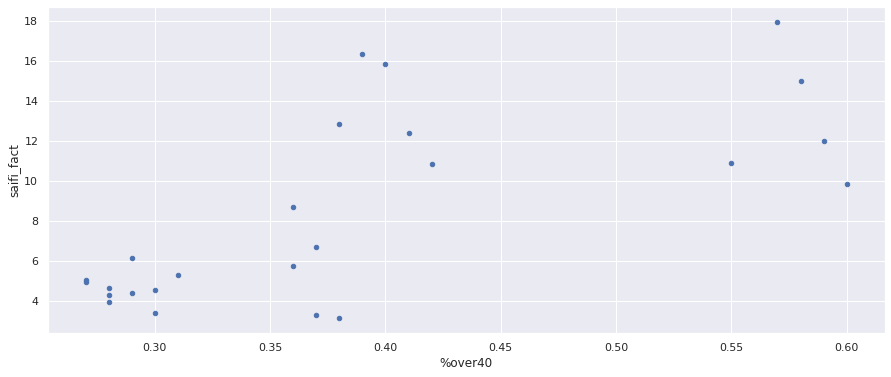

In [137]:
# построение визуализации для предварительной оценки наличия корреляции показателя saidi от износа сетей
df_corr_merged.plot(kind='scatter', x='%over40', y='saifi_fact')

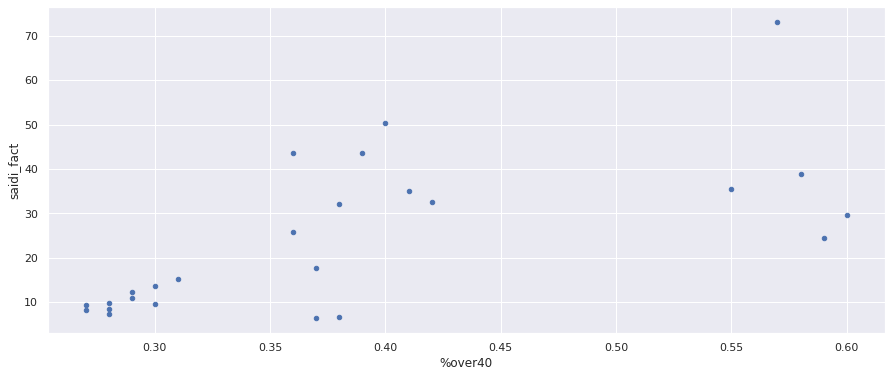

In [138]:
# построение визуализации для предварительной оценки наличия корреляции показателя saifi от износа сетей
df_corr_merged.plot(kind='scatter', x='%over40', y='saidi_fact')

--------------------

Визуально имеется заметная корреляция между износом электрических сетей и показателями надежности saidi, saifi.

--------------------

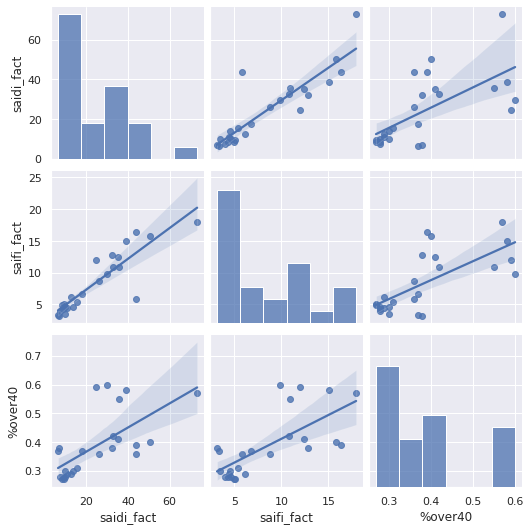

In [139]:
sns.pairplot(df_corr_merged[['saidi_fact', 'saifi_fact', '%over40']], kind='reg')

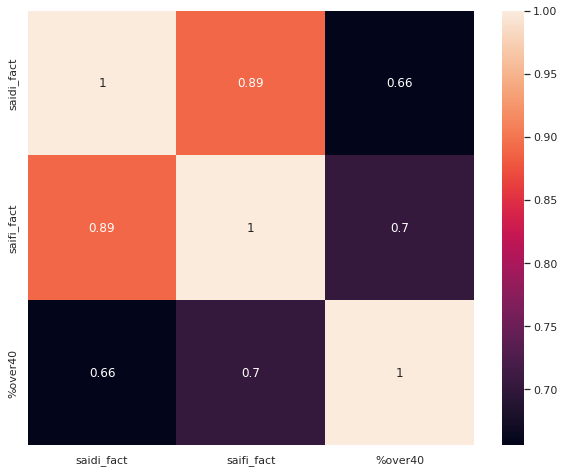

In [140]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.heatmap(df_corr_merged[['saidi_fact', 'saifi_fact', '%over40']].corr(), annot=True)

-------------------------

- Корреляция между показателями saidi и saifi является естественной и анализироваться не будет.

- Корреляция между износом сетей и показателем saidi составляет 0.66, показателем saifi - 0.70, что указывают на сильную взаимосвязь показателей.

- Вероятно, зависимыми величинами являются показатели надежности, независимой - уровень износа сетей (т.е. чем сильнее износ - тем выше (хуже) показатели надежности).

-------------------------

In [141]:
# коэффициент корреляции Пирсона
df_corr_merged[['%over40', 'saidi_fact', 'saifi_fact']].corr()

,%over40,saidi_fact,saifi_fact
%over40,1.000,0.655,0.703
saidi_fact,0.655,1.000,0.890
saifi_fact,0.703,0.890,1.000


In [142]:
# коэффициент корреляции Спирмена
df_corr_merged[['%over40', 'saidi_fact', 'saifi_fact']].corr(method='spearman')

,%over40,saidi_fact,saifi_fact
%over40,1.000,0.684,0.686
saidi_fact,0.684,1.000,0.896
saifi_fact,0.686,0.896,1.000


In [143]:
# Оба метода расчета коэффициента корреляции показывают сильную положительную корреляцию

#### Построение модели регрессии:

- Зависимость показателя надежности saidi от износа электрических сетей:

In [144]:
X = df_corr_merged[['%over40']]
y = df_corr_merged['saidi_fact']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [145]:
# в связи с малым объемом выборки, для повышения качества оценки точности предсказания принято решение провести бутстреппинг:

AccuracyValues = []
n_times = 5

for i in range(n_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=83+i)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Коэффициент: {model.coef_[0]}, интерсепт: {model.intercept_}, коэффициент детерминации: {model.score(X_test, y_test)}')
    Accuracy = 100 - (np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    AccuracyValues.append(np.round(Accuracy))

print('Полученные значения точности модели: ', AccuracyValues)
print('Итоговая оценка точности модели: ', np.mean(AccuracyValues))

Коэффициент: 75.53456981763755, интерсепт: -7.410968614483632, коэффициент детерминации: 0.36622423327413234
Коэффициент: 98.33545012238548, интерсепт: -15.116652540920114, коэффициент детерминации: 0.4144066091046209
Коэффициент: 106.84446076086007, интерсепт: -15.05831335496033, коэффициент детерминации: 0.4457712523448042
Коэффициент: 86.98920607080214, интерсепт: -10.988589828001544, коэффициент детерминации: 0.3840029039120525
Коэффициент: 98.14926938166694, интерсепт: -14.201375587390782, коэффициент детерминации: 0.5309600926392948
Полученные значения точности модели:  [64.0, 64.0, 33.0, 55.0, 68.0]
Итоговая оценка точности модели:  56.8


Модель зависимости saidi от износа имеет вид (результат бустреппинга с максимальным коэффициентом детерминации):
- y = 98.1493 * x - 14.2014

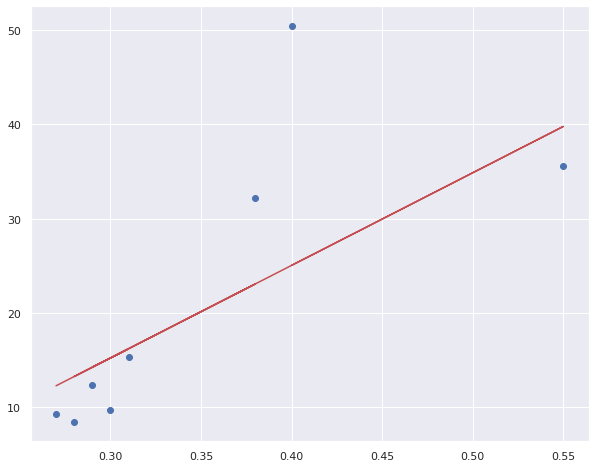

In [146]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c='r')

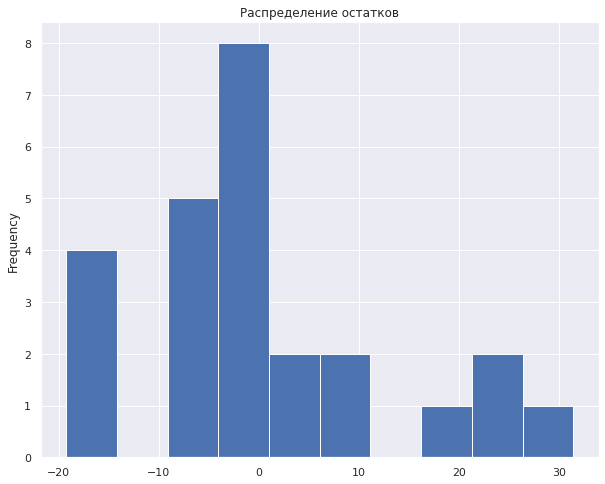

In [147]:
# построение гистограммы остатков:

df_corr_merged['resid'] = df_corr_merged['saidi_fact'] - (98.1493 * df_corr_merged['%over40'] - 14.2014)
df_corr_merged['resid'].plot(kind='hist', 
                     title='Распределение остатков', bins=10)

Распределение остатков имеет не нормальный характер. Объем исходных данных для более высокого качества модели недостаточен.

- Зависимость показателя надежности saifi от износа электрических сетей:

In [148]:
X = df_corr_merged[['%over40']]
y = df_corr_merged['saifi_fact']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [149]:
# в связи с малым объемом выборки, для повышения качества оценки точности предсказания принято решение провести бутстреппинг:

AccuracyValues = []
n_times = 5

for i in range(n_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=83+i)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Коэффициент: {model.coef_[0]}, интерсепт: {model.intercept_}, коэффициент детерминации: {model.score(X_test, y_test)}')
    Accuracy = 100 - (np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    AccuracyValues.append(np.round(Accuracy))

print('Полученные значения точности модели: ', AccuracyValues)
print('Итоговая оценка точности модели: ', np.mean(AccuracyValues))

Коэффициент: 25.765836646966306, интерсепт: -1.675993401375834, коэффициент детерминации: 0.749697443745602
Коэффициент: 29.6575173463477, интерсепт: -3.552476691793503, коэффициент детерминации: 0.29690247485725674
Коэффициент: 34.07584407771488, интерсепт: -4.162802339060278, коэффициент детерминации: 0.5682055701697918
Коэффициент: 26.377047210898038, интерсепт: -2.4601698188494945, коэффициент детерминации: 0.3766156108947044
Коэффициент: 30.48846386780422, интерсепт: -3.7206147013655873, коэффициент детерминации: 0.39088122931910374
Полученные значения точности модели:  [80.0, 70.0, 65.0, 71.0, 74.0]
Итоговая оценка точности модели:  72.0


Модель зависимости saifi от износа имеет вид (результат бустреппинга с максимальным коэффициентом детерминации):
- y = 25.7658 * x - 1.6760

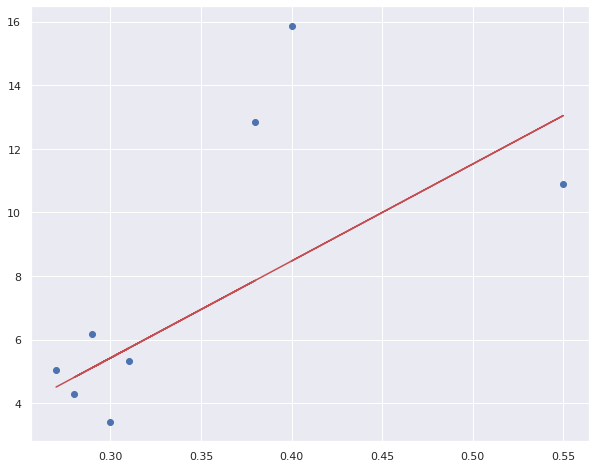

In [150]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c='r')

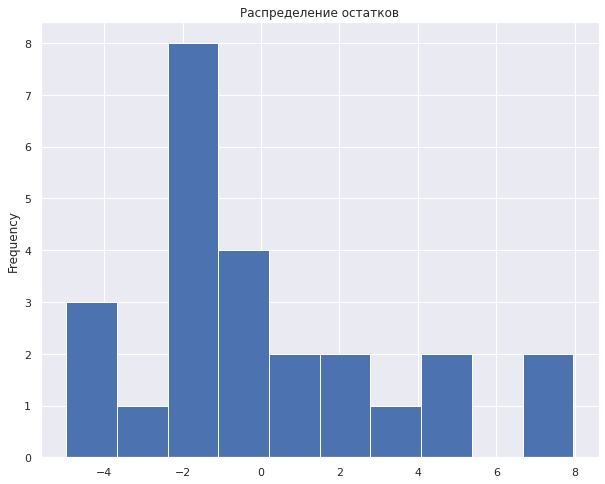

In [151]:
# построение гистограммы остатков:

df_corr_merged['resid'] = df_corr_merged['saifi_fact'] - (25.7658 * df_corr_merged['%over40'] - 1.6760)
df_corr_merged['resid'].plot(kind='hist', 
                     title='Распределение остатков', bins=10)

Распределение остатков имеет не нормальный характер. Объем исходных данных для более высокого качества модели недостаточен.

## Часть 3. Проверка гипотез

*Подготовка данных для проверки гипотез, основанных на показателе "Длительность обесточения потребителей" (09_duration):*

In [152]:
df['09_duration'].describe()

count            114,666.000
mean                   2.949
std                   12.158
min                    0.000
25%                    0.783
50%                    1.783
75%                    3.700
max                2,209.350
Name: 09_duration, dtype: float64

In [153]:
df_stats = df.groupby('02_TSO')['09_duration'].describe()
df_stats

,count,mean,std,min,25%,50%,75%,max
02_TSO,,,,,,,,
ТСО № 1,"23,734.000",2.428,2.348,0.000,0.733,1.817,3.317,46.033
ТСО № 2,"69,411.000",2.683,3.242,0.000,0.833,1.783,3.767,150.583
ТСО № 3,"9,843.000",5.412,35.083,0.000,0.730,1.967,4.350,"2,209.350"
ТСО № 4,"5,930.000",2.904,10.210,0.000,0.630,1.780,3.900,746.870
ТСО № 5,"5,748.000",4.136,23.886,0.000,0.650,1.467,3.333,744.683


<ipython-input-154-6dcce1342e3b>:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  remove_outliers = df_cur[df_cur['09_duration'].between(lower_bound, upper_bound, inclusive=True)]


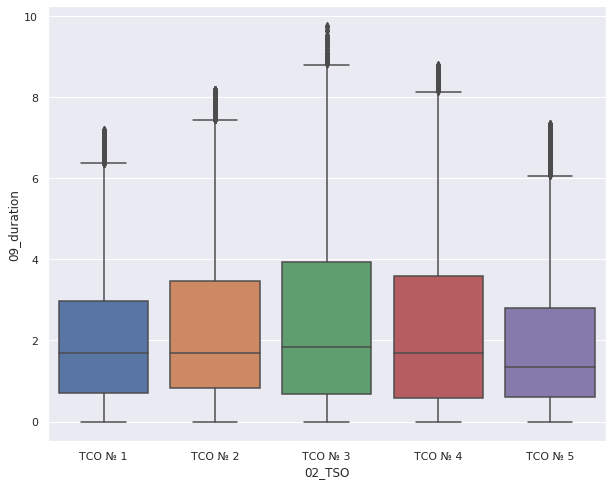

In [154]:
# удаление выбросов по каждому ТСО и построение боксплотов по длительности обесточений:

cols = list(df.columns)
cummulative = pd.DataFrame(columns=cols)    # создание пустого дф для последующего накопления обработанных данных

for TSO in TSO_list:
    df_cur = df[df['02_TSO'] == TSO]
    q1 = df_cur['09_duration'].quantile(0.25)
    q3 = df_cur['09_duration'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    remove_outliers = df_cur[df_cur['09_duration'].between(lower_bound, upper_bound, inclusive=True)]
    cummulative = pd.concat([cummulative, remove_outliers])

sns.boxplot(x=cummulative['02_TSO'], y=cummulative['09_duration'])

(array([1.9927e+04, 1.4998e+04, 1.4540e+04, 1.1462e+04, 9.6270e+03,
        7.2450e+03, 5.4360e+03, 4.4270e+03, 3.9340e+03, 3.5140e+03,
        3.3250e+03, 3.1140e+03, 2.8830e+03, 2.1750e+03, 1.8480e+03,
        9.3400e+02, 7.2100e+02, 1.1700e+02, 5.9000e+01, 1.8000e+01]),
 array([0.    , 0.4875, 0.975 , 1.4625, 1.95  , 2.4375, 2.925 , 3.4125,
        3.9   , 4.3875, 4.875 , 5.3625, 5.85  , 6.3375, 6.825 , 7.3125,
        7.8   , 8.2875, 8.775 , 9.2625, 9.75  ]),
 <a list of 20 Patch objects>)

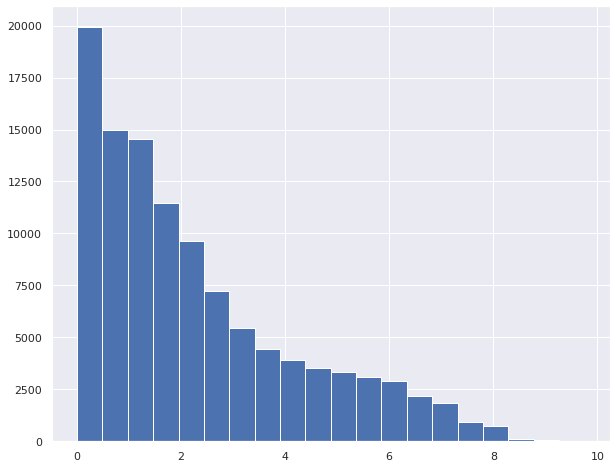

In [155]:
plt.hist(cummulative['09_duration'], bins=20)

In [156]:
# Распределение, очевидно, не имеет нормальных характер
# Дополнительная проверка нормальности тестом Шапиро (H0 - данные имеют нормальное распределение):
data = cummulative['09_duration']
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.5f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Данные, вероятно, имеют нормальное распределение (нельзя отклонить нулевую гипотезу H0)')
else:
    print('Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)')

Statistics=0.897, p=0.00000
Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как распределение имеет не нормальный характер, будут использоваться непараметрические методы тестирования гипотез:
   - тест Крускала-Уоллиса
   - тест Манна-Уитни
   - тест Данна

-------------------------

**Гипотеза № 1.**

H0: Длительность обесточения потребителей при авариях по причинам природных воздействий не отличается от аварий по другим причинам.

H1: Длительность обесточения потребителей при авариях по причинам природных воздействий отличается от аварий по другим причинам.

-------------------------

1) Тест Крускала-Уоллиса:

In [157]:
data = cummulative
data_1 = data['09_duration'][data['reason_class'] == 'Природные воздействия']      # выборка отключений из-за природных воздействий
data_2 = data['09_duration'][data['reason_class'] == 'Недостатки эксплуатации']    # выборка отключений из-за недостатков эксплуатации
data_3 = data['09_duration'][data['reason_class'] == 'Сторонние воздействия']      # выборка отключений из-за сторонних воздействий
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры выборок: 16733, 13208, 10066 элементов


In [158]:
# приведение выборок к одинаковому размеру:
data_1 = data_1.sample(n=len(data_3))
data_2 = data_2.sample(n=len(data_3))
print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры итоговых выборок: 10066, 10066, 10066 элементов


In [159]:
result = st.kruskal(data_1, data_2, data_3)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=328.457, p=0.0000000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Заключение:
- продолжительность обесточения потребителей при авариях по разным причинам - различается
- тест Крускала-Уоллиса не позволяет определить источник различий в разрезе конкретных выборок

2) Тест Манна-Уитни:

In [160]:
data = cummulative[['09_duration', 'reason_class']]
subset_1 = data[data['reason_class'] == 'Природные воздействия']['09_duration']
subset_2 = data[data['reason_class'].isin(['Недостатки эксплуатации', 'Сторонние воздействия'])]['09_duration']
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 16733, 23274 элементов


In [161]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 16733, 16733 элементов


In [162]:
print(f'Среднее значение по выборке отключений из-за ПРИРОДНЫХ ВОЗДЕЙСТВИЙ: {subset_1.mean():.3f} ч.')
print(f'Среднее значение по выборке отключений из-за прочих причин: {subset_2.mean():.3f} ч.')

Среднее значение по выборке отключений из-за ПРИРОДНЫХ ВОЗДЕЙСТВИЙ: 1.430 ч.
Среднее значение по выборке отключений из-за прочих причин: 1.249 ч.


In [163]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=143691937.500, p=0.0000275
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Заключение:
- продолжительность обесточения потребителей при авариях из-за природных воздействий выше, чем при авариях из-за других причин

**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 1:**

Продолжительность обесточения потребителей при авариях из-за природных воздействий выше, чем при авариях из-за других причин.

-------------------------

**Гипотеза № 2.**

H0: Длительность обесточения потребителей при плановых отключениях и при внеплановых / аварийных отключениях не отличается.

H1: Длительность обесточения потребителей при плановых отключениях и при внеплановых / аварийных отключениях отличается.

-------------------------

Тест Крускала-Уоллиса:

In [164]:
data = cummulative
data_1 = data['09_duration'][data['08_outage_type'] == 'П']      # выборка плановых отключений
data_2 = data['09_duration'][data['08_outage_type'] == 'В']      # выборка внеплановых отключений
data_3 = data['09_duration'][data['08_outage_type'] == 'А']      # выборка аварийных отключений
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры выборок: 69628, 39738, 938 элементов


In [165]:
# приведение выборок к одинаковому размеру:
data_1 = data_1.sample(n=len(data_3))
data_2 = data_2.sample(n=len(data_3))
print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры итоговых выборок: 938, 938, 938 элементов


In [166]:
result = st.kruskal(data_1, data_2, data_3)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=758.964, p=0.0000000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


ЗАКЛЮЧЕНИЕ:
- продолжительность обесточения потребителей при разных типах отключений - различается
- тест Крускала-Уоллиса не позволяет определить источник различий в разрезе конкретных выборок

Тест Манна-Уитни:

In [167]:
# Тест Манна-Уитни
data = cummulative[['09_duration', '08_outage_type']]
subset_1 = data[data['08_outage_type'] == 'П']['09_duration']
subset_2 = data[data['08_outage_type'].isin(['А', 'В'])]['09_duration']
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 69628, 40676 элементов


In [168]:
# приведение выборок к одинаковому размеру:
subset_1 = subset_1.sample(n=len(subset_2))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 40676, 40676 элементов


In [169]:
print(f'Среднее значение по выборке ПЛАНОВЫХ отключений: {subset_1.mean():.3f} ч.')
print(f'Среднее значение по выборке внеплановых и аварийных отключений: {subset_2.mean():.3f} ч.')

Среднее значение по выборке ПЛАНОВЫХ отключений: 2.842 ч.
Среднее значение по выборке внеплановых и аварийных отключений: 1.315 ч.


In [170]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=1261222096.000, p=0.0000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


ЗАКЛЮЧЕНИЕ:
- продолжительность обесточения потребителей при плановых отключениях выше, чем при внеплановых и аварийных отключениях

**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 2:**

Продолжительность обесточения потребителей при плановых отключениях выше, чем при внеплановых и аварийных отключениях.

-------------------------

**Гипотеза № 3.**

H0: Длительность обесточения потребителей в разных ТСО не отличается.

H1: Длительность обесточения потребителей в разных ТСО отличается.

-------------------------

Тест Крускала-Уоллиса:

In [247]:
data = cummulative
data_1 = data['09_duration'][data['02_TSO'] == TSO_list[0]]      # выборка отключений в ТСО № 1
data_2 = data['09_duration'][data['02_TSO'] == TSO_list[1]]      # выборка отключений в ТСО № 2
data_3 = data['09_duration'][data['02_TSO'] == TSO_list[2]]      # выборка отключений в ТСО № 3
data_4 = data['09_duration'][data['02_TSO'] == TSO_list[3]]      # выборка отключений в ТСО № 4
data_5 = data['09_duration'][data['02_TSO'] == TSO_list[4]]      # выборка отключений в ТСО № 5
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры выборок: 20281, 59557, 8468, 5355, 4839 элементов


In [248]:
# приведение выборок к одинаковому размеру:
data_1 = data_1.sample(n=len(data_5))
data_2 = data_2.sample(n=len(data_5))
data_3 = data_3.sample(n=len(data_5))
data_4 = data_4.sample(n=len(data_5))
print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры итоговых выборок: 4839, 4839, 4839, 4839, 4839 элементов


In [249]:
result = st.kruskal(data_1, data_2, data_3, data_4, data_5)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=113.871, p=0.0000000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


ЗАКЛЮЧЕНИЕ:
- продолжительность обесточения потребителей в разных ТСО различается
- тест Крускала-Уоллиса не позволяет определить источник различий в разрезе конкретных выборок

Тест Манна-Уитни:

In [250]:
data = cummulative[['09_duration', '02_TSO']]
subset_1 = data[data['02_TSO'] == TSO_list[2]]['09_duration']       # выборка для ТСО № 3 (исходя из боксплот-визуализации распределения значений - худшее ТСО)
subset_2 = data[data['02_TSO'].isin([TSO_list[0], TSO_list[1], TSO_list[3], TSO_list[4]])]['09_duration']         # выборка по прочим ТСО
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 8468, 90032 элементов


In [251]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 8468, 8468 элементов


In [252]:
print(f'Среднее значение по выборке отключений по ТСО № 3: {subset_1.mean():.3f} ч.')
print(f'Среднее значение по выборке отключений по остальным ТСО: {subset_2.mean():.3f} ч.')

Среднее значение по выборке отключений по ТСО № 3: 4.496 ч.
Среднее значение по выборке отключений по остальным ТСО: 2.288 ч.


In [253]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=37662883.500, p=0.0000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Тест Данна:

In [254]:
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры выборок: 4839, 4839, 4839, 4839, 4839 элементов


In [263]:
# при выполнении теста применяем поправку Сидака:

result = sp.posthoc_dunn([data_1, data_2, data_3, data_4, data_5], p_adjust = 'sidak')
print(result)

                     1                    2                    3  \
1                1.000                0.355                0.000   
2                0.355                1.000                0.279   
3                0.000                0.279                1.000   
4                0.978                0.974                0.015   
5                0.000                0.000                0.000   

                     4                    5  
1                0.978                0.000  
2                0.974                0.000  
3                0.015                0.000  
4                1.000                0.000  
5                0.000                1.000  


ЗАКЛЮЧЕНИЕ:
- продолжительность обесточения потребителей ТСО № 2 и № 3 отличается (выше) от других ТСО

Дополнительная проверка - сравнение распределений по ТСО № 3 и ТСО № 2 (как ТСО с рисками невыполнения предельных показателей надежности, по которым в рамках теста Данна не было выявлено значимых статистических различий)

Тест Манна-Уитни:



In [178]:
data = cummulative[['09_duration', '02_TSO']]
subset_1 = data[data['02_TSO'] == TSO_list[2]]['09_duration']                   # выборка для ТСО № 3
subset_2 = data[data['02_TSO'] == TSO_list[1]]['09_duration']                   # выборка для ТСО № 2
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 9427, 67216 элементов


In [179]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 9427, 9427 элементов


In [180]:
print(f'Среднее значение по выборке отключений по ТСО № 3: {subset_1.mean():.3f} ч.')
print(f'Среднее значение по выборке отключений по ТСО № 2: {subset_2.mean():.3f} ч.')

Среднее значение по выборке отключений по ТСО № 3: 2.551 ч.
Среднее значение по выборке отключений по ТСО № 2: 2.320 ч.


In [181]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=45560566.500, p=0.0025718
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 3:**

Продолжительность обесточения потребителей по ТСО № 3 выше, чем по остальным ТСО.

-------------------------

*Подготовка данных для проверки гипотез, основанных на показателе "Масштабы обесточения потребителей" (scale_full):*

In [182]:
df['scale_full'].describe()

count            114,666.000
mean                 407.691
std                2,361.716
min                    0.000
25%                   10.998
50%                   57.750
75%                  246.411
max              470,591.550
Name: scale_full, dtype: float64

In [183]:
df_stats = df.groupby('02_TSO')['scale_full'].describe()
df_stats

,count,mean,std,min,25%,50%,75%,max
02_TSO,,,,,,,,
ТСО № 1,"23,734.000",403.663,"1,216.807",0.000,7.800,50.133,241.500,"42,426.900"
ТСО № 2,"69,411.000",383.741,"1,413.048",0.000,12.950,58.000,233.333,"145,288.000"
ТСО № 3,"9,843.000",575.370,"5,957.597",0.000,4.438,52.800,288.083,"470,591.550"
ТСО № 4,"5,930.000",303.610,944.817,0.000,11.977,81.950,296.362,"51,534.030"
ТСО № 5,"5,748.000",533.762,"4,389.854",0.000,21.294,69.096,292.325,"311,349.750"


<ipython-input-184-4deb9662bcad>:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  remove_outliers = df_cur[df_cur['scale_full'].between(lower_bound, upper_bound, inclusive=True)]


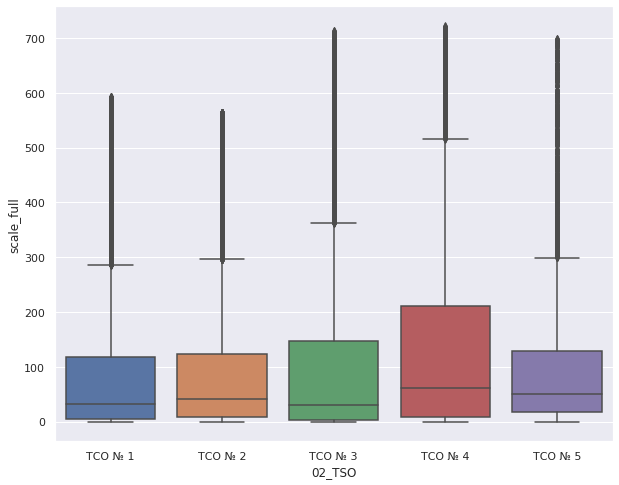

In [184]:
# удаление выбросов по каждому ТСО и построение боксплотов по длительности обесточений:

cols = list(df.columns)
cummulative = pd.DataFrame(columns=cols)    # создание пустого дф для последующего накопления обработанных данных

for TSO in TSO_list:
    df_cur = df[df['02_TSO'] == TSO]
    q1 = df_cur['scale_full'].quantile(0.25)
    q3 = df_cur['scale_full'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    remove_outliers = df_cur[df_cur['scale_full'].between(lower_bound, upper_bound, inclusive=True)]
    cummulative = pd.concat([cummulative, remove_outliers])

sns.boxplot(x=cummulative['02_TSO'], y=cummulative['scale_full'])

(array([39913., 13564.,  8535.,  6048.,  4512.,  3667.,  2936.,  2518.,
         2116.,  1794.,  1555.,  1371.,  1271.,  1127.,   993.,   886.,
          845.,   770.,   733.,   669.,   594.,   612.,   552.,   326.,
          152.,   102.,    86.,    96.,    99.,    58.]),
 array([  0.        ,  24.05111111,  48.10222222,  72.15333333,
         96.20444444, 120.25555555, 144.30666666, 168.35777777,
        192.40888888, 216.45999999, 240.5111111 , 264.56222221,
        288.61333332, 312.66444444, 336.71555555, 360.76666666,
        384.81777777, 408.86888888, 432.91999999, 456.9711111 ,
        481.02222221, 505.07333332, 529.12444443, 553.17555554,
        577.22666665, 601.27777776, 625.32888887, 649.37999998,
        673.43111109, 697.4822222 , 721.53333331]),
 <a list of 30 Patch objects>)

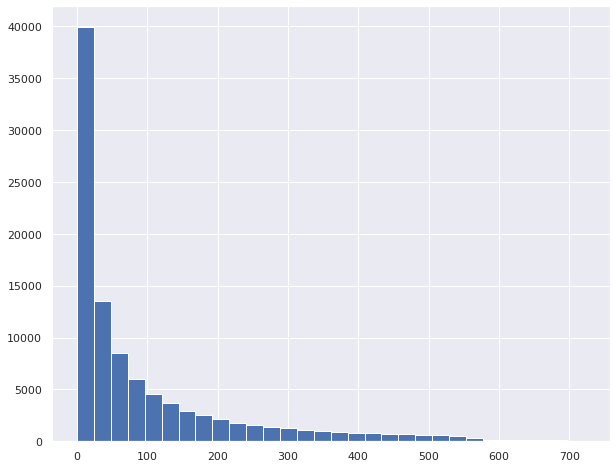

In [185]:
plt.hist(cummulative['scale_full'], bins=30)

In [186]:
# Распределение, очевидно, не имеет нормальных характер
# Дополнительная проверка нормальности тестом Шапиро (H0 - данные имеют нормальное распределение):
data = cummulative['scale_full']
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.5f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Данные, вероятно, имеют нормальное распределение (нельзя отклонить нулевую гипотезу H0)')
else:
    print('Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)')

Statistics=0.734, p=0.00000
Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как распределение имеет не нормальный характер, будут использоваться непараметрические методы тестирования гипотез:
   - тест Манна-Уитни
   - тест Крускала-Уоллиса

-------------------------

**Гипотеза № 4.**

H0: Масштаб единичного обесточения потребителей в разных ТСО не отличается.

H1: Масштаб единичного обесточения потребителей в разных ТСО отличается.

-------------------------

Тест Крускала-Уоллиса:

In [264]:
data = cummulative
data_1 = data['scale_full'][data['02_TSO'] == TSO_list[0]]      # выборка отключений в ТСО № 1
data_2 = data['scale_full'][data['02_TSO'] == TSO_list[1]]      # выборка отключений в ТСО № 2
data_3 = data['scale_full'][data['02_TSO'] == TSO_list[2]]      # выборка отключений в ТСО № 3
data_4 = data['scale_full'][data['02_TSO'] == TSO_list[3]]      # выборка отключений в ТСО № 4
data_5 = data['scale_full'][data['02_TSO'] == TSO_list[4]]      # выборка отключений в ТСО № 5
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры выборок: 20281, 59557, 8468, 5355, 4839 элементов


In [265]:
# приведение выборок к одинаковому размеру:
data_1 = data_1.sample(n=len(data_5))
data_2 = data_2.sample(n=len(data_5))
data_3 = data_3.sample(n=len(data_5))
data_4 = data_4.sample(n=len(data_5))
print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры итоговых выборок: 4839, 4839, 4839, 4839, 4839 элементов


In [266]:
result = st.kruskal(data_1, data_2, data_3, data_4, data_5)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=247.018, p=0.0000000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


ЗАКЛЮЧЕНИЕ:
- масштаб единичного обесточения потребителей в разных ТСО отличается
- тест Крускала-Уоллиса не позволяет определить источник различий в разрезе конкретных выборок

Тест Манна-Уитни:

In [267]:
data = cummulative[['scale_full', '02_TSO']]
subset_1 = data[data['02_TSO'] == TSO_list[3]]['scale_full']      # выборка для ТСО № 4 (с учетом визуализации-боксплота - ТСО № 4 визуально наихудшее)
subset_2 = data[data['02_TSO'].isin([TSO_list[0], TSO_list[1], TSO_list[2], TSO_list[4]])]['scale_full']      # выборка по прочим ТСО
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 5355, 93145 элементов


In [268]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 5355, 5355 элементов


In [269]:
print(f'Средний масштаб обесточения по выборке отключений по ТСО № 4: {subset_1.mean():.3f} ч.')
print(f'Среднее масштаб обесточения по выборке отключений по остальным ТСО: {subset_2.mean():.3f} ч.')

Средний масштаб обесточения по выборке отключений по ТСО № 4: 139.016 ч.
Среднее масштаб обесточения по выборке отключений по остальным ТСО: 92.309 ч.


In [270]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=15918680.500, p=0.0000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


Тест Данна:

In [271]:
 print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры итоговых выборок: 4839, 4839, 4839, 4839, 4839 элементов


In [272]:
# при выполнении теста применяем поправку Сидака:

result = sp.posthoc_dunn([data_1, data_2, data_3, data_4, data_5], p_adjust = 'sidak')
print(result)

                     1                    2                    3  \
1                1.000                0.000                1.000   
2                0.000                1.000                0.000   
3                1.000                0.000                1.000   
4                0.000                0.000                0.000   
5                0.000                0.000                0.000   

                     4                    5  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                1.000                0.610  
5                0.610                1.000  


ЗАКЛЮЧЕНИЕ:
- масштаб обесточения потребителей в ТСО № 4 и № 5 отличается (выше), чем в среднем по остальным ТСО

Дополнительная проверка - сравнение распределений по ТСО № 4 и ТСО № 5

Тест Манна-Уитни:

In [273]:
data = cummulative[['scale_full', '02_TSO']]
subset_1 = data[data['02_TSO'] == TSO_list[3]]['scale_full']                   # выборка для ТСО № 4
subset_2 = data[data['02_TSO'] == TSO_list[4]]['scale_full']                   # выборка для ТСО № 3
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 5355, 4839 элементов


In [274]:
# приведение выборок к одинаковому размеру:
subset_1 = subset_1.sample(n=len(subset_2))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 4839, 4839 элементов


In [275]:
print(f'Среднее значение по выборке отключений по ТСО № 4: {subset_1.mean():.3f} ч.')
print(f'Среднее значение по выборке отключений по ТСО № 5: {subset_2.mean():.3f} ч.')

Среднее значение по выборке отключений по ТСО № 4: 139.310 ч.
Среднее значение по выборке отключений по ТСО № 5: 107.399 ч.


In [276]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=12083954.500, p=0.0061962
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 4:**

Масштабы обесточения потребителей по ТСО № 4 выше, чем по остальным ТСО.

-------------------------

**Гипотеза № 5.**

H0: Масштаб обесточения потребителей при отключении по вине ТСО не отличается от масштаба обесточения по причинам, не связанным с виной ТСО.

H1: Масштаб обесточения потребителей при отключении по вине ТСО отличается от масштаба обесточения по причинам, не связанным с виной ТСО.

-------------------------

In [198]:
# создание атрибута (столбца) с указанием нужной категории вины ТСО (ранее создавался на базе другого датафрейма)
cummulative.loc[cummulative['25_org_code'].isin(reasons_to_blame), 'TSO_blame'] = 'Вина ТСО'
cummulative.loc[cummulative['25_org_code'].isin(reasons_no_blame), 'TSO_blame'] = 'Нет вины ТСО'
cummulative.loc[cummulative['25_org_code'].isin(reasons_uncertain_blame), 'TSO_blame'] = 'Определяется при расследовании'

Тест Крускала-Уоллиса:

In [199]:
data = cummulative
data_1 = data['scale_full'][data['TSO_blame'] == 'Вина ТСО']      # выборка отключений с виной ТСО
data_2 = data['scale_full'][data['TSO_blame'] == 'Нет вины ТСО']      # выборка отключений без вины ТСО
data_3 = data['scale_full'][data['TSO_blame'] == 'Определяется при расследовании']      # выборка отключений с неопределенной виной ТСО
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры выборок: 12309, 6807, 18312 элементов


In [200]:
# приведение выборок к одинаковому размеру:
data_1 = data_1.sample(n=len(data_2))
data_3 = data_3.sample(n=len(data_2))
print(f'Размеры итоговых выборок: {len(data_1)}, {len(data_2)}, {len(data_3)} элементов')

Размеры итоговых выборок: 6807, 6807, 6807 элементов


In [201]:
result = st.kruskal(data_1, data_2, data_3)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=71.340, p=0.0000000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


ЗАКЛЮЧЕНИЕ:
- масштаб обесточения потребителей в зависимости от наличия вины ТСО различается
- тест Крускала-Уоллиса не позволяет определить источник различий в разрезе конкретных выборок

Тест Манна-Уитни:

In [202]:
data = cummulative[['scale_full', 'TSO_blame']]
subset_1 = data[data['TSO_blame'] == 'Вина ТСО']['scale_full']      # выборка по отключениям по вине ТСО
subset_2 = data[data['TSO_blame'].isin(['Нет вины ТСО'])]['scale_full']      # выборка по прочим отключениям
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 12309, 6807 элементов


In [203]:
# приведение выборок к одинаковому размеру:
subset_1 = subset_1.sample(n=len(subset_2))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 6807, 6807 элементов


In [204]:
print(f'Средний масштаб обесточения по выборке отключений по вине ТСО: {subset_1.mean():.3f} ч.')
print(f'Среднее масштаб обесточения по выборке отключений по прочим причинам: {subset_2.mean():.3f} ч.')

Средний масштаб обесточения по выборке отключений по вине ТСО: 71.246 ч.
Среднее масштаб обесточения по выборке отключений по прочим причинам: 77.659 ч.


In [205]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=25127497.500, p=0.0000000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 5:**

Масштабы обесточения потребителей при отключениях по причинам, связанным с виной ТСО, ниже, чем при отключениях, причина которых не связана с виной ТСО.

-------------------------

**Гипотеза № 6.**

H0: Масштаб обесточения потребителей из-за внеплановых и аварийных отключений в мае-сентябре (период активной ремонтной кампании и ослабления схем сетей) не отличается от остальных месяцев года.

H1: Масштаб обесточения потребителей из-за внеплановых и аварийных отключений в мае-сентябре (период активной ремонтной кампании и ослабления схем сетей) отличается от остальных месяцев года.

-------------------------

Тест Манна-Уитни:

In [206]:
data = cummulative[['year', 'month', 'scale_full']][cummulative['08_outage_type'].isin(['А', 'В'])]
data = data.groupby(['year', 'month']).sum()['scale_full'].reset_index()
data = data[['month', 'scale_full']]
subset_1 = data[data['month'].isin([5, 6, 7, 8, 9])]['scale_full']      # выборка по отключениям в мае-сентябре
subset_2 = data[~data['month'].isin([5, 6, 7, 8, 9])]['scale_full']      # выборка по отключениям в другие месяцы
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 25, 32 элементов


In [207]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 25, 25 элементов


In [208]:
print(f'Средний масштаб обесточения в мае-сентябре: {subset_1.mean():.3f} ч.')
print(f'Среднее масштаб обесточения в остальные месяцы года: {subset_2.mean():.3f} ч.')

Средний масштаб обесточения в мае-сентябре: 67092.640 ч.
Среднее масштаб обесточения в остальные месяцы года: 38852.887 ч.


In [209]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=508.000, p=0.0001546
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 6:**

Масштабы обесточения потребителей из-за внеплановых и аварийных отключений в период проведения активной ремонтной кампании (май-сентябрь) выше, чем в остальные месяцы года.

-------------------------

**Гипотеза № 7.**

H0: Доля масштабов обесточения потребителей из-за природных воздействий в ТСО, расположенных в приморских регионах, не отличается от других ТСО.

H1: Доля масштабов обесточения потребителей из-за природных воздействий в ТСО, расположенных в приморских регионах, отличается от других ТСО.

-------------------------

In [278]:
# группировка масштаба обесточения потребителей в разрезе ТСО, годов и групп причин аварий:
reasons_table = df[df['reason_class'].notnull()].groupby(['02_TSO', 'year', 'reason_class']).sum()['scale_full'].reset_index()
reasons_table

,02_TSO,year,reason_class,scale_full
0,ТСО № 1,2018,Недостатки эксплуатации,"35,340.825"
1,ТСО № 1,2018,Природные воздействия,"77,328.612"
2,ТСО № 1,2018,Сторонние воздействия,"98,578.664"
3,ТСО № 1,2019,Недостатки эксплуатации,"186,632.893"
4,ТСО № 1,2019,Природные воздействия,"171,940.265"
...,...,...,...,...
70,ТСО № 5,2021,Природные воздействия,657.883
71,ТСО № 5,2021,Сторонние воздействия,"7,118.673"
72,ТСО № 5,2022,Недостатки эксплуатации,181.437
73,ТСО № 5,2022,Природные воздействия,"1,071.390"


In [279]:
# расчет вклада каждой группы причин аварий (в разрезе ТСО и годов) через оконную функцию:

def share(df):
    total_scale = df['scale_full'].sum()
    df['share_%'] = df['scale_full'] / total_scale * 100

    return df

data = reasons_table.groupby(['02_TSO', 'year']).apply(share).sort_values(['02_TSO', 'year'])
data.head(6)

,02_TSO,year,reason_class,scale_full,share_%
0,ТСО № 1,2018,Недостатки эксплуатации,"35,340.825",16.730
1,ТСО № 1,2018,Природные воздействия,"77,328.612",36.606
2,ТСО № 1,2018,Сторонние воздействия,"98,578.664",46.665
3,ТСО № 1,2019,Недостатки эксплуатации,"186,632.893",39.762
4,ТСО № 1,2019,Природные воздействия,"171,940.265",36.631
5,ТСО № 1,2019,Сторонние воздействия,"110,807.530",23.607


Тест Манна-Уитни:

In [280]:
data = data[['02_TSO', 'reason_class', 'share_%']]
subset_1 = data[  (data['02_TSO'].isin([TSO_list[1], TSO_list[2]]))  &  (data['reason_class'] == 'Природные воздействия')  ]['share_%']         # выборка для ТСО № 2 и № 3 (расположены в приморских регионах)
subset_2 = data[  (~data['02_TSO'].isin([TSO_list[1], TSO_list[2]]))  &  (data['reason_class'] == 'Природные воздействия')  ]['share_%']        # выборка для прочих ТСО (расположены не в приморских регионах)
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 10, 15 элементов


In [281]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 10, 10 элементов


In [282]:
print(f'Среднее значение по выборке отключений по ТСО в приморских регионах: {subset_1.mean():.3f} %')
print(f'Среднее значение по выборке отключений по ТСО № 2: {subset_2.mean():.3f} %')

Среднее значение по выборке отключений по ТСО в приморских регионах: 55.944 %
Среднее значение по выборке отключений по ТСО № 2: 38.114 %


In [283]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=80.000, p=0.0257481
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 7:**

Доля суммарнных масштабов обесточения потребителей из-за природных воздействий в ТСО, расположенных в приморских регионах, выше, чем в ТСО, расположенных не в приморских регионах.

-------------------------

**Гипотеза № 8.**

H0: Доля масштабов обесточения потребителей из-за недостатков эксплуатации в ТСО № 2 не отличается от других ТСО.

H1: Доля масштабов обесточения потребителей из-за недостатков эксплуатации в ТСО № 2 отличается от других ТСО.

-------------------------

Тест Манна-Уитни:

In [284]:
subset_1 = data[  (data['02_TSO'] == TSO_list[1])  &  (data['reason_class'] == 'Недостатки эксплуатации')  ]['share_%']         # выборка для ТСО № 2
subset_2 = data[  (data['02_TSO'] != TSO_list[1])  &  (data['reason_class'] == 'Недостатки эксплуатации')  ]['share_%']        # выборка для прочих ТСО
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 5, 20 элементов


In [285]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 5, 5 элементов


In [286]:
print(f'Среднее значение по выборке отключений из-за недостатков эксплуатации по ТСО № 2: {subset_1.mean():.3f} %')
print(f'Среднее значение по выборке отключений из-за недостатков эксплуатации по прочим ТСО: {subset_2.mean():.3f} %')

Среднее значение по выборке отключений из-за недостатков эксплуатации по ТСО № 2: 31.388 %
Среднее значение по выборке отключений из-за недостатков эксплуатации по прочим ТСО: 8.517 %


In [287]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=25.000, p=0.0079365
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 8:**

Доля суммарнных масштабов обесточения потребителей из-за недостатков эксплуатации в ТСО № 2 выше, чем в прочих ТСО.

-------------------------

**Гипотеза № 9.**

H0: Фактические показатели надежности saidi в ТСО, расположенных в приморских регионах, не отличается от других ТСО.

H1: Фактические показатели надежности saidi в ТСО, расположенных в приморских регионах, отличается от других ТСО.

-------------------------

In [220]:
# для проверки гипотезы используется ранее сформированный датафрейм по фактическим показателям надежности:
saidi_saifi_proper_stacked.head()

,02_TSO,year,scale_full,13_points_overall,max_points,limit_saidi,limit_saifi,sum_limit_saidi,sum_limit_saifi,saidi_fact,saifi_fact,% saidi,% saifi
0,ТСО № 1,2018,"52,548.309",60786,147640,2.530,4.670,"373,529.200","689,478.800",0.356,0.412,14.068,8.816
1,ТСО № 1,2019,"222,271.966",215060,152121,2.490,4.600,"378,781.290","699,756.600",1.461,1.414,58.681,30.734
2,ТСО № 1,2020,"186,312.883",126875,154179,2.450,4.530,"377,738.550","698,430.870",1.208,0.823,49.323,18.166
3,ТСО № 1,2021,"175,634.357",121758,156990,2.420,4.460,"379,915.800","700,175.400",1.119,0.776,46.230,17.390
4,ТСО № 1,2022,"92,990.967",132261,159020,2.380,4.400,"378,467.600","699,688.000",0.585,0.832,24.570,18.903


In [221]:
# оценка нормальности распределения тестом Шапиро:
stat, p = shapiro(saidi_saifi_proper_stacked['saidi_fact'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Данные, вероятно, имеют нормальное распределение (нельзя отклонить нулевую гипотезу H0)')
else:
    print('Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)')

Statistics=0.854, p=0.002
Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)


Тест Манна-Уитни:

In [222]:
data = saidi_saifi_proper_stacked[['02_TSO', 'year', 'saidi_fact']]
subset_1 = data[data['02_TSO'].isin([TSO_list[1], TSO_list[2]])]['saidi_fact']         # выборка для ТСО № 2 и № 3 (расположены в приморских регионах)
subset_2 = data[~data['02_TSO'].isin([TSO_list[1], TSO_list[2]])]['saidi_fact']        # выборка для прочих ТСО (расположены не в приморских регионах)
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 10, 15 элементов


In [223]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 10, 10 элементов


In [224]:
print(f'Среднее значение по выборке по ТСО в приморских регионах: {subset_1.mean():.3f} (час. на 1 точку поставки)')
print(f'Среднее значение по выборке по прочим ТСО: {subset_2.mean():.3f} (час. на 1 точку поставки)')

Среднее значение по выборке по ТСО в приморских регионах: 2.034 (час. на 1 точку поставки)
Среднее значение по выборке по прочим ТСО: 0.974 (час. на 1 точку поставки)


In [225]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=70.000, p=0.1404650
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 9:**

Статистически значимые различия фактических показателей надежности saidi для ТСО в приморских регионах и иных ТСО не выявлены.

*Примечание: размер выборки, вероятно, недостаточен для формирования статистически обоснованного вывода*

-------------------------

**Гипотеза № 10.**

H0: Фактические показатели надежности saifi в ТСО, расположенных в приморских регионах, не отличается от других ТСО.

H1: Фактические показатели надежности saifi в ТСО, расположенных в приморских регионах, отличается от других ТСО.

-------------------------

In [226]:
# оценка нормальности распределения по тесту Шапиро:
stat, p = shapiro(saidi_saifi_proper_stacked['saifi_fact'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Данные, вероятно, имеют нормальное распределение (нельзя отклонить нулевую гипотезу H0)')
else:
    print('Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)')

Statistics=0.896, p=0.015
Данные, вероятно, имеют не нормальное распределение (отклоняется нулевая гипотеза H0)


Тест Манна-Уитни:

In [227]:
data = saidi_saifi_proper_stacked[['02_TSO', 'year', 'saifi_fact']]
subset_1 = data[data['02_TSO'].isin([TSO_list[1], TSO_list[2]])]['saifi_fact']         # выборка для ТСО № 2 и № 3 (расположены в приморских регионах)
subset_2 = data[~data['02_TSO'].isin([TSO_list[1], TSO_list[2]])]['saifi_fact']        # выборка для прочих ТСО (расположены не в приморских регионах)
print(f'Размеры выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры выборок: 10, 15 элементов


In [228]:
# приведение выборок к одинаковому размеру:
subset_2 = subset_2.sample(n=len(subset_1))
print(f'Размеры итоговых выборок: {len(subset_1)}, {len(subset_2)} элементов')

Размеры итоговых выборок: 10, 10 элементов


In [229]:
print(f'Среднее значение по выборке по ТСО в приморских регионах: {subset_1.mean():.3f} (час. на 1 точку поставки)')
print(f'Среднее значение по выборке по прочим ТСО: {subset_2.mean():.3f} (час. на 1 точку поставки)')

Среднее значение по выборке по ТСО в приморских регионах: 1.424 (час. на 1 точку поставки)
Среднее значение по выборке по прочим ТСО: 0.665 (час. на 1 точку поставки)


In [230]:
stat, p = st.mannwhitneyu(subset_1, subset_2)
print(f'Статистика={stat:.3f}, p={p:.7f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=73.000, p=0.0889730
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 10:**

Статистически значимые различия фактических показателей надежности saifi для ТСО в приморских регионах и иных ТСО не выявлены.

*Примечание: размер выборки, вероятно, недостаточен для формирования статистически обоснованного вывода*

-------------------------

**Гипотеза № 11.**

H0: Доля объемов недоотпуска электроэнергии из-за недостатков эксплуатации во всем ТСО одинакова.

H1: Доля объемов недоотпуска электроэнергии из-за недостатков эксплуатации в разных ТСО отличается.

-------------------------

In [231]:
# используется созданный ранее датафрейм:
pwr_table = pwr_table[['02_TSO', 'year', 'reason_class', 'share_power_%']]
pwr_table.head()

,02_TSO,year,reason_class,share_power_%
0,ТСО № 1,2019,Недостатки эксплуатации,19.967
1,ТСО № 1,2019,Природные воздействия,47.958
2,ТСО № 1,2019,Сторонние воздействия,32.076
3,ТСО № 1,2020,Недостатки эксплуатации,19.515
4,ТСО № 1,2020,Природные воздействия,46.145


Тест Крускала-Уоллиса:

In [232]:
data = pwr_table[pwr_table['reason_class'] == 'Недостатки эксплуатации']
data_1 = data['share_power_%'][data['02_TSO'] == TSO_list[0]]      # выборка отключений по ТСО № 1
data_2 = data['share_power_%'][data['02_TSO'] == TSO_list[1]]      # выборка отключений по ТСО № 2
data_3 = data['share_power_%'][data['02_TSO'] == TSO_list[2]]      # выборка отключений по ТСО № 3
data_4 = data['share_power_%'][data['02_TSO'] == TSO_list[3]]      # выборка отключений по ТСО № 4
data_5 = data['share_power_%'][data['02_TSO'] == TSO_list[4]]      # выборка отключений по ТСО № 5
print(f'Размеры выборок: {len(data_1)}, {len(data_2)}, {len(data_3)}, {len(data_4)}, {len(data_5)} элементов')

Размеры выборок: 4, 4, 4, 4, 4 элементов


In [233]:
result = st.kruskal(data_1, data_2, data_3, data_4, data_5)
print()
print(f'Статистика={result[0]:.3f}, p={result[1]:.10f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=7.000, p=0.1358882254
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 11:**

Статистически значимые различия доли недоотпуска электроэнергии из-за недостатков эксплуатации в различных ТСО отсутствуют.

*Примечание: размер выборки, вероятно, недостаточен для формирования статистически обоснованного вывода*

-------------------------

**Гипотеза № 12.**

H0: Отсутствуют отличия порядка учета/неучета в показателях надежности отключений по причинам, входящим в блок "3.4.12. Воздействие повторяющихся стихийных явлений", между ТСО № 1 и № 4 в сравнении с ТСО № 2, № 3 и № 5.

H1: Существуют отличия порядка учета/неучета в показателях надежности отключений по причинам, входящим в блок "3.4.12. Воздействие повторяющихся стихийных явлений", между ТСО № 1 и № 4 в сравнении с ТСО № 2, № 3 и № 5.

-------------------------

In [234]:
# используется сформированный ранее датафрейм:
df_codes_pivot_data = df_codes_pivot_data[df_codes_pivot_data['org_code'].isin(['3.4.12.1', '3.4.12.2', '3.4.12.3', '3.4.12.4', '3.4.12.5', '3.4.12'])]
df_codes_pivot_data.head()

,02_TSO,08_outage_type,25_org_code,27_flag,scale_full,year,org_code,org_reason,TSO_blame
73,ТСО № 1,В,3.4.12.2,0,10.200,2020,3.4.12.2,Ветровые нагрузки,Определяется при расследовании
102,ТСО № 1,В,3.4.12.2,1,40.733,2020,3.4.12.2,Ветровые нагрузки,Определяется при расследовании
104,ТСО № 1,В,3.4.12.1,1,0.000,2020,3.4.12.1,Гололедно-изморозевые отложения,Определяется при расследовании
105,ТСО № 1,В,3.4.12.1,1,0.000,2020,3.4.12.1,Гололедно-изморозевые отложения,Определяется при расследовании
106,ТСО № 1,В,3.4.12.1,1,0.550,2020,3.4.12.1,Гололедно-изморозевые отложения,Определяется при расследовании


In [235]:
# группировка по ТСО в разрезе учета/неучета отключений (0/1):
data = pd.pivot_table(df_codes_pivot_data, values='year', index='02_TSO', columns='27_flag', aggfunc='count', fill_value=0).reset_index()
data

27_flag,02_TSO,0,1
0,ТСО № 1,1,959
1,ТСО № 2,4810,0
2,ТСО № 3,691,54
3,ТСО № 4,133,111
4,ТСО № 5,82,20


Точный критерий Фишера:

In [236]:
# подготовка данных:
data_1 = data[data['02_TSO'].isin([TSO_list[0], TSO_list[3]])]
data_2 = data[~data['02_TSO'].isin([TSO_list[0], TSO_list[3]])]

data_1 = [data_1.iloc[:, [1]].values.sum(), data_1.iloc[:, [2]].values.sum()]
data_2 = [data_2.iloc[:, [1]].values.sum(), data_2.iloc[:, [2]].values.sum()]
print(data_1)
print(data_2)

[134, 1070]
[5583, 74]


In [237]:
x = [data_1, data_2]

oddsratio, p = st.fisher_exact(x) # Точный тест Фишера

print('Статистика=%.3f, p=%.10f' % (oddsratio, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, выборки, вероятно, независимы')
else:
    print('Отклоняем нулевую гипотезу, вероятно, есть некоторая зависимость')

Статистика=0.002, p=0.0000000000
Отклоняем нулевую гипотезу, вероятно, есть некоторая зависимость


**ИТОГОВОЕ ЗАКЛЮЧЕНИЕ по итогам статистической проверки гипотезы № 12:**

Порядок учета/неучета в показателях надежности отключений по причинам, входящим в блок "Воздействие повторяющихся стихийных явлений", в ТСО № 1 и № 4 отличается от порядка учета в ТСО № 2, № 3 и № 5.

Указанный факт может вносить значительные искажения в показатели надежности saidi, saifi.

Требуется анализ причин различий и, при необходимости, проведение методологической работы по приведению порядка учета отключений из-за воздействия повторяющихся стихийных явлений к единым принципам во всех ТСО.

-------------------------

-------------------------

**ОБЩЕЕ ЗАКЛЮЧЕНИЕ ПО ПРОВЕДЕННОМУ АНАЛИЗУ:**

1) По результатам проведенного анализа в деятельности 5 рассмотренных ТСО выявлен ряд рисков по следующим показателям и направлениям:
- превышение предельных отраслевых показателей надежности;
-	ухудшение динамики показателей надежности;
-	нарушение нормативов максимально допустимой длительности перерывов электроснабжения по потребителям 1, 2 и 3 категорий надежности;
-	рост масштабов недоотпуска электроэнергии потребителям;
-	недостаточный уровень готовности к проведению аварийно-восстановительных работ для скорейшего восстановления электроснабжения;
-	высокий уровень износа электрических сетей;
-	недостаточное качество ведения отчетной информации;
-	отсутствие приоритезации включения в производственные программы объектов, вносящих наибольший вклад в показатели надежности;
-	возможная некорректность классификации причин аварий;
-	возможная некорректность определения типов отключений;
-	отсутствие единых методологических подходов к учету в показателях надежности аварий, связанных с воздействием повторяющихся стихийных явлений;
-	недостаточная работа с подрядными и строительными организациями, осуществляющими несогласованные действия в охранных зонах ВЛ.

2) Из рассмотренных ТСО наиболее высокий интегральный риск отмечается, по оценке автора исследования, в ТСО № 2.

3) В ходе анализа сформировано 24 рекомендации, направленных на достижение следующих целей:
-	повышение корректности расчета показателей надежности;
-	повышение качества расследования причин аварий;
-	повышение качества планирования технических воздействий;
-	обеспечение готовности к ликвидации аварийных ситуаций;
-	минимизация факторов, влияющих на аварийность энергообъектов;
-	обеспечение корректного ведения отчетной информации

4) Холдингу рекомендуется, в случае признания рекомендаций валидными, в течение 2 календарных месяцев организовать разработку комплекса организационно-технических мероприятий по устранению выявленных несоответствий и снижению рисков.

-------------------------